# Model Comparison


In [1]:
import DataLoader, Training, HelperFunctions, os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler
from mne.decoding import CSP

In [ ]:
data_path = "F:/Masterthesis/Data/"
preprocessing = "light"
model_name = "eegnet"
model_folder = "ModelComparison"
n_epochs = 25
n_splits = 10

for model_name in ["shallow", "deep", "eegnet"]:
    if model_name == "eegnet":
        lr = 0.03
    else:
        lr = 0.01
    for task in ["N170", "N400", "P3", "N2pc", "MMN", "ERN", "LRP"]:
        df = DataLoader.load_df(data_path, task, preprocessing)
        data, labels = DataLoader.create_data_labels(df)
        Training.run_exp(data, labels, task, preprocessing, model_folder, model_name, 
                lr, n_epochs, n_splits, batch_size=64)

In [44]:
data_path = "F:/Masterthesis/Data/"
preprocessing = "medium"

df_svm = pd.DataFrame()
for task in ["ERN"]:
#for task in ["MMN"]:
    df = DataLoader.load_df(data_path, task, preprocessing)
    data, labels = DataLoader.create_data_labels(df)
    #class_weights=class_weight.compute_class_weight('balanced',np.unique(labels),labels)
    cv = StratifiedShuffleSplit(10, test_size=0.2, random_state=42)
    cv_split = cv.split(data, labels)
    svc = LinearSVC(class_weight="balanced")
    #svc = SVC(C=1, kernel='linear', class_weight="balanced")
    #csp = CSP(n_components=3)
    #clf = Pipeline([("StandardScaler",StandardScaler()), ('LinearSVC', svc)])
    clf = Pipeline([('LinearSVC', svc)])
    # memory issues
    if task == "MMN":
        scores = cross_val_score(clf, data.reshape(-1, 30*251), labels, cv=cv, n_jobs=5, scoring="balanced_accuracy")
    else:
        scores = cross_val_score(clf, data.reshape(-1, 30*251), labels, cv=cv, n_jobs=10, scoring="balanced_accuracy")
    for score in scores:
        data = {'Task': task,
                'Model': "SVM",
                'Preprocessing': "medium",
                'Validation Balanced Accuracy': score}
        df_svm = df_svm.append(data, ignore_index=True)
    #class_balance = np.mean(labels == labels[0])
    #class_balance = max(class_balance, 1. - class_balance)
    print(task+": "+str(np.mean(scores)))
    #print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
    #                                                          class_balance))
df_path = os.getcwd()+"\\ModelComparison\\"
df_svm.to_csv(df_path+"df_svmERN.csv",index=False)

ERN: 0.7342981860023322


In [2]:
data_path = "F:/Masterthesis/Data/"
model_name = "eegnet"
model_folder = "ModelComparison"
n_epochs = 25
n_splits = 10

# Get Results
results = []
for model_name in ["eegnet","shallow","deep"]:
    for preprocessing in ["medium"]:
        for task in ["N170", "N400", "P3", "N2pc", "MMN", "ERN", "LRP"]:
            df = Training.load_exp(model_folder, model_name, task, preprocessing, n_splits)
            df["Model"] = model_name
            df["Preprocessing"] = preprocessing
            df["Task"] = task
            results.append(df.iloc[-1])
df_results = pd.concat(results, axis=1)
df_results = df_results.transpose().reset_index()
# Put results in correct dataframe for seaborn plot
df_task = df_results[["Task", "Model", "Preprocessing","valid_balanced_accuracy"]]
df_task = df_task.rename(columns={"valid_balanced_accuracy": "Validation Balanced Accuracy"})
list = []
for i in range(3,13):
    list.append(df_task.iloc[:,[0,1,2,i]])
df_task = pd.concat(list, axis=0)
df_task

Task   Model Preprocessing Validation Balanced Accuracy
0   N170  eegnet        medium                     0.774126
1   N400  eegnet        medium                     0.759575
2     P3  eegnet        medium                     0.746587
3   N2pc  eegnet        medium                     0.662003
4    MMN  eegnet        medium                     0.595574
..   ...     ...           ...                          ...
16    P3    deep        medium                     0.744658
17  N2pc    deep        medium                     0.673445
18   MMN    deep        medium                     0.597462
19   ERN    deep        medium                     0.912473
20   LRP    deep        medium                     0.820563

[210 rows x 4 columns]

In [4]:
for task in ["N170", "N400", "P3", "N2pc", "MMN", "ERN", "LRP"]:
    print(task, df_task[(df_task["Task"]==task) & (df_task["Model"]=="deep")].mean())

N170 Validation Balanced Accuracy    0.790905
dtype: float64
N400 Validation Balanced Accuracy    0.756642
dtype: float64
P3 Validation Balanced Accuracy    0.757549
dtype: float64
N2pc Validation Balanced Accuracy    0.677115
dtype: float64
MMN Validation Balanced Accuracy    0.599255
dtype: float64
ERN Validation Balanced Accuracy    0.907626
dtype: float64
LRP Validation Balanced Accuracy    0.816219
dtype: float64


In [4]:
df_path = os.getcwd()+"\\ModelComparison\\"
df_svm = pd.read_csv(df_path+"df_svm_medium.csv")
df_svm

Model Preprocessing  Task  Validation Balanced Accuracy
0    SVM        medium  N170                      0.672922
1    SVM        medium  N170                      0.672980
2    SVM        medium  N170                      0.679681
3    SVM        medium  N170                      0.689724
4    SVM        medium  N170                      0.679934
..   ...           ...   ...                           ...
65   SVM        medium   LRP                      0.711257
66   SVM        medium   LRP                      0.722944
67   SVM        medium   LRP                      0.731091
68   SVM        medium   LRP                      0.710907
69   SVM        medium   LRP                      0.737392

[70 rows x 4 columns]

In [5]:
df_task = df_task.append(df_svm, ignore_index=True)

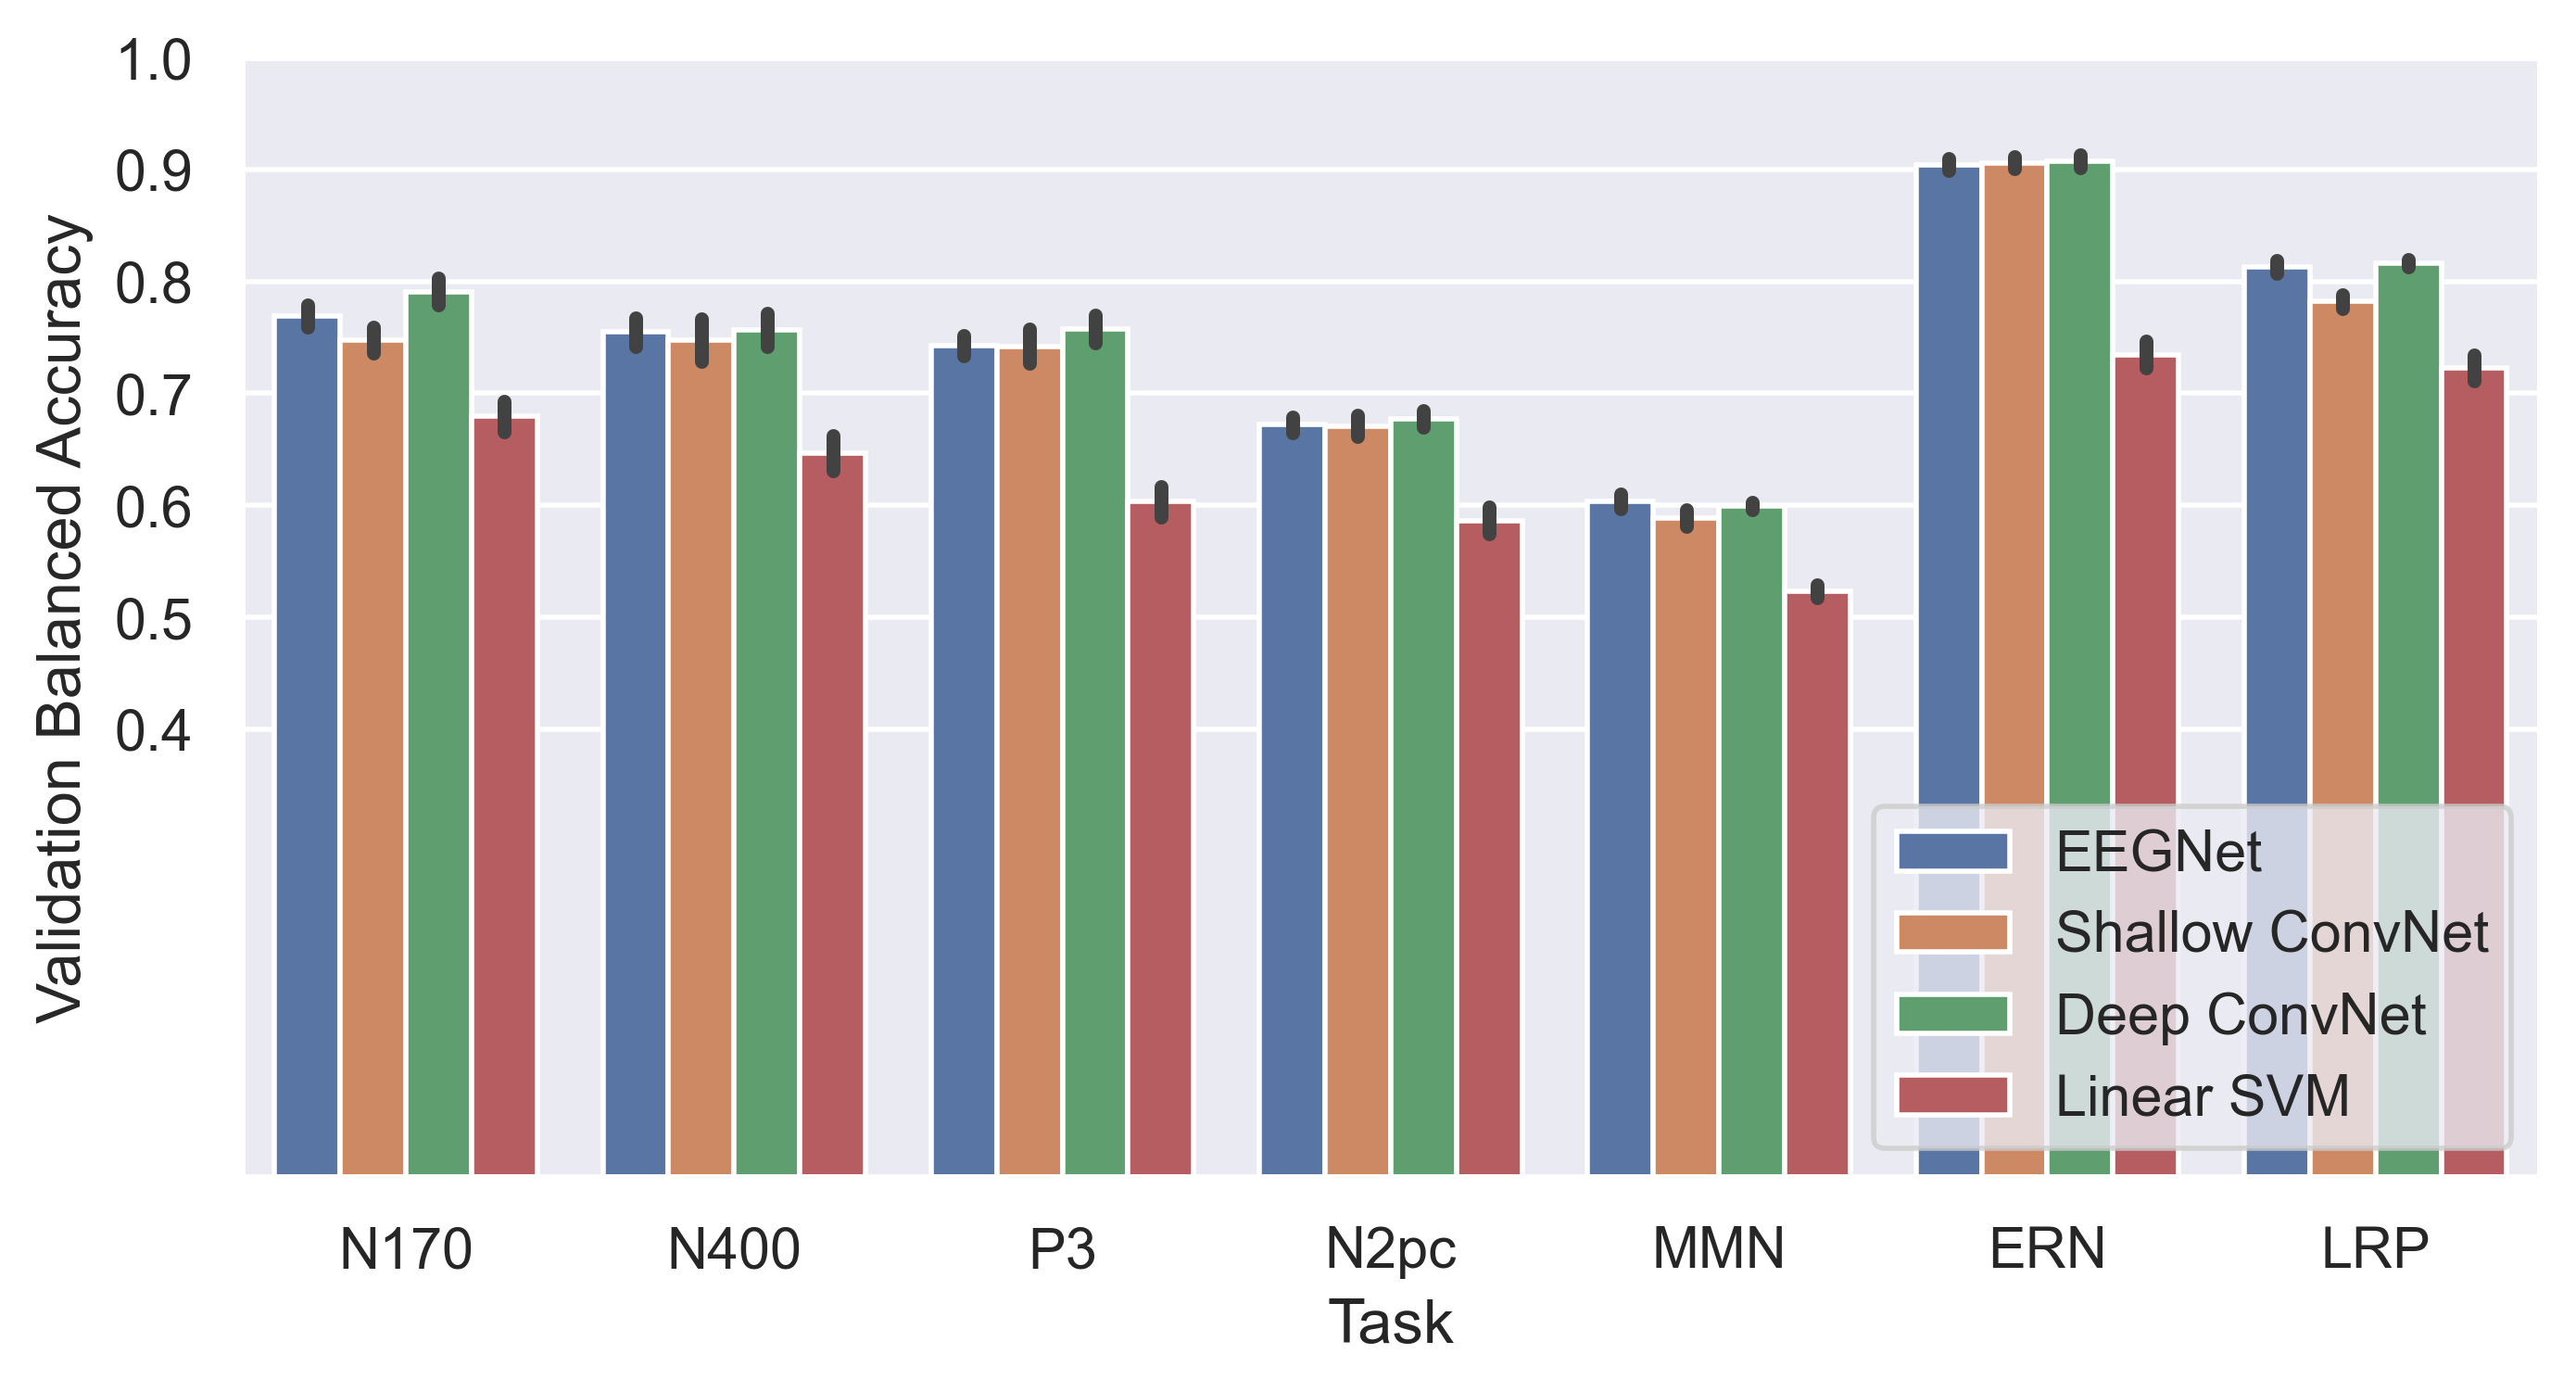

In [7]:
# N170 plot, no downsampling
sns.set(style="darkgrid")
plt.figure(figsize=(8, 4), dpi=400)
g = sns.barplot(x="Task", y="Validation Balanced Accuracy", 
            hue="Model", 
            data=df_task, ci="sd")
g.set_yticks(np.round(np.arange(0.4,1.1,0.1),1))

l = plt.legend(loc='lower right')
l.get_texts()[0].set_text('EEGNet')
l.get_texts()[1].set_text('Shallow ConvNet')
l.get_texts()[2].set_text('Deep ConvNet')
l.get_texts()[3].set_text('Linear SVM')

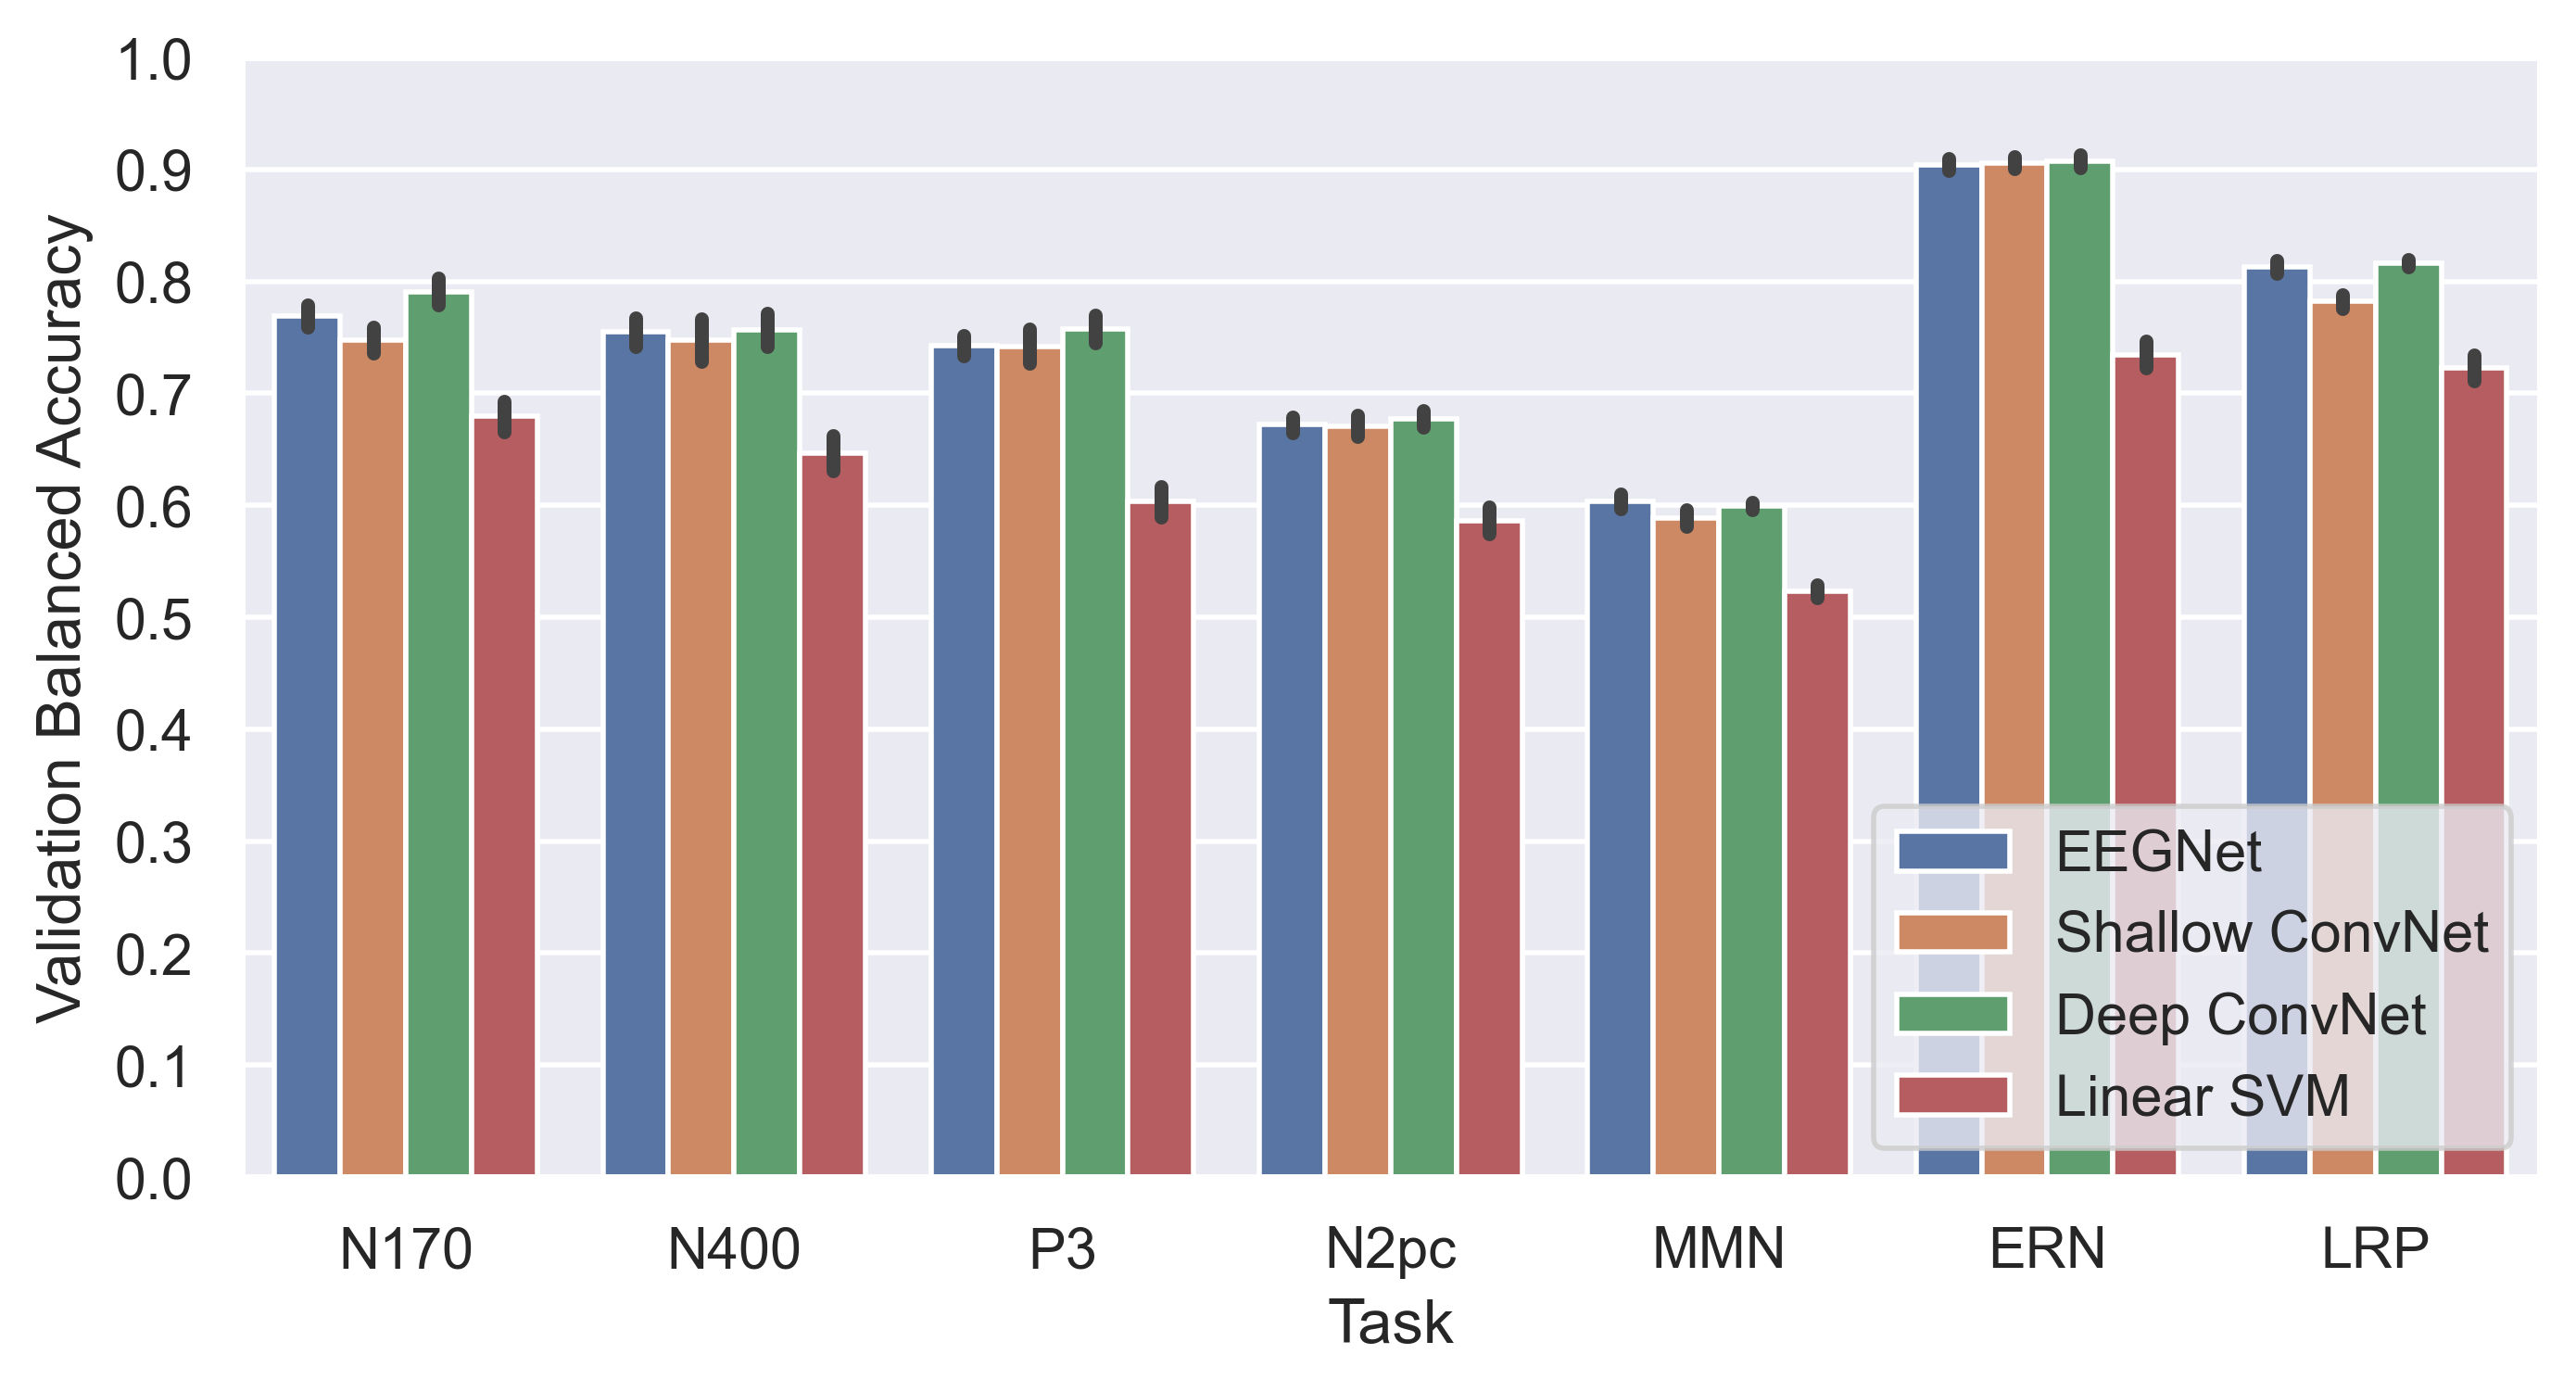

In [121]:
# N170 plot, no downsampling
sns.set(style="darkgrid")
plt.figure(figsize=(8, 4), dpi=400)
g = sns.barplot(x="Task", y="Validation Balanced Accuracy", 
            hue="Model", 
            data=df_task, ci="sd")
g.set_yticks(np.round(np.arange(0,1.1,0.1),1))
l = plt.legend(loc='lower right')
l.get_texts()[0].set_text('EEGNet')
l.get_texts()[1].set_text('Shallow ConvNet')
l.get_texts()[2].set_text('Deep ConvNet')
l.get_texts()[3].set_text('Linear SVM')

## Equal Sample Count

In [40]:
data_path = "F:/Masterthesis/Data/"
preprocessing = "medium"
model_name = "eegnet"
model_folder = "ModelComparison_EqualSamples1000"
n_epochs = 25
n_splits = 10

for model_name in ["shallow", "deep", "eegnet"]:
    if model_name == "eegnet":
        lr = 0.03
    else:
        lr = 0.01
    for task in ["N170", "N400", "P3", "N2pc", "MMN", "ERN", "LRP"]:
        df = DataLoader.load_df(data_path, task, preprocessing)
        # lowest number of samples is P3 condition 0 with 1338 samples
        df = df.groupby(["condition"]).sample(1000, random_state=42)
        data, labels = DataLoader.create_data_labels(df)
        Training.run_exp(data, labels, task, preprocessing, model_folder, model_name, 
                lr, n_epochs, n_splits, batch_size=64)

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.4994        1.5881                     0.5425        0.9094  0.0100  0.2839
      2                     0.5306        0.9213                     0.5575        0.7223  0.0100  0.1726
      3                     0.5094        0.8232                     0.5550        0.6876  0.0098  0.1696
      4                     0.5787        0.7390                     0.5650        0.6904  0.0096  0.1705
      5                     0.5637        0.7374                     0.5925        0.7438  0.0093  0.1735
      6                     0.5969        0.7221                     0.5975        0.7189  0.0090  0.1745
      7                     0.6169        0.7551              

      9                     0.6525        0.6499                     0.6100        0.6552  0.0075  0.1696
     10                     0.6869        0.6228                     0.6500        0.6338  0.0069  0.1686
     11                     0.6925        0.6125                     0.6300        0.6662  0.0063  0.1676
     12                     0.6963        0.6003                     0.6550        0.6437  0.0057  0.1702
     13                     0.7150        0.5799                     0.6225        0.6783  0.0050  0.1676
     14                     0.7206        0.5663                     0.6775        0.6300  0.0043  0.1675
     15                     0.7294        0.5313                     0.6550        0.6450  0.0037  0.1691
     16                     0.7069        0.5564                     0.6350        0.6705  0.0031  0.1676
     17                     0.7450        0.5198                     0.6650        0.6499  0.0025  0.1676
     18                     0.7681        0.49

     20                     0.7356        0.5321                     0.6675        0.5999  0.0010  0.1667
     21                     0.7363        0.5314                     0.6625        0.6042  0.0007  0.1694
     22                     0.7469        0.5201                     0.6700        0.5980  0.0004  0.1675
     23                     0.7506        0.5165                     0.6725        0.5979  0.0002  0.1670
     24                     0.7675        0.4957                     0.6750        0.5989  0.0000  0.1696
     25                     0.7475        0.4995                     0.6750        0.5987  0.0000  0.1666
Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.5219        1.6320              

      3                     0.5144        0.9279                     0.5500        0.6937  0.0098  0.1676
      4                     0.5431        0.7884                     0.5725        0.6853  0.0096  0.1685
      5                     0.5775        0.7188                     0.5975        0.6604  0.0093  0.1676
      6                     0.5875        0.7069                     0.5750        0.6695  0.0090  0.1676
      7                     0.6044        0.6852                     0.5700        0.6770  0.0085  0.1695
      8                     0.6100        0.6767                     0.6100        0.6525  0.0080  0.1676
      9                     0.6256        0.6601                     0.6125        0.6507  0.0075  0.1676
     10                     0.6544        0.6336                     0.6000        0.6516  0.0069  0.1686
     11                     0.6581        0.6405                     0.6300        0.6490  0.0063  0.1670
     12                     0.6750        0.61

     13                     0.6794        0.6124                     0.6725        0.6149  0.0050  0.1689
     14                     0.6675        0.6185                     0.6650        0.6167  0.0043  0.1682
     15                     0.6975        0.5933                     0.6650        0.6329  0.0037  0.1685
     16                     0.7012        0.5810                     0.6600        0.6440  0.0031  0.1695
     17                     0.6987        0.5796                     0.6475        0.6345  0.0025  0.1676
     18                     0.7150        0.5669                     0.6575        0.5973  0.0020  0.1676
     19                     0.7306        0.5508                     0.6550        0.6009  0.0015  0.1696
     20                     0.7469        0.5234                     0.6575        0.6047  0.0010  0.1676
     21                     0.7556        0.5084                     0.6475        0.6055  0.0007  0.1676
     22                     0.7356        0.53

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


      2                     0.6319        0.8032                     0.6825        0.6128  0.0100  0.1675
      3                     0.6469        0.7120                     0.7175        0.5535  0.0098  0.1676
      4                     0.6881        0.6370                     0.6950        0.5731  0.0096  0.1695
      5                     0.6844        0.6205                     0.7025        0.5777  0.0093  0.1686
      6                     0.7050        0.6267                     0.6225        0.8002  0.0090  0.1676
      7                     0.6706        0.6598                     0.6400        0.6666  0.0085  0.1686
      8                     0.6925        0.6181                     0.7350        0.5452  0.0080  0.1676
      9                     0.7231        0.5831                     0.7300        0.5313  0.0075  0.1677
     10                     0.7325        0.5531                     0.7750        0.5188  0.0069  0.1683
     11                     0.7450        0.53

     13                     0.7769        0.4874                     0.7075        0.5677  0.0050  0.1707
     14                     0.7719        0.4776                     0.7000        0.5845  0.0043  0.1675
     15                     0.7775        0.4751                     0.7300        0.5640  0.0037  0.1670
     16                     0.7812        0.4597                     0.7275        0.5688  0.0031  0.1704
     17                     0.7925        0.4406                     0.7475        0.5670  0.0025  0.1672
     18                     0.8119        0.4188                     0.7325        0.5542  0.0020  0.1705
     19                     0.7900        0.4295                     0.7350        0.5514  0.0015  0.1695
     20                     0.8113        0.4077                     0.7375        0.5666  0.0010  0.1678
     21                     0.8163        0.3973                     0.7375        0.5684  0.0007  0.1685
     22                     0.8181        0.39

     25                     0.8213        0.3903                     0.7150        0.5777  0.0000  0.1696
Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.5544        1.4021                     0.5100        0.9493  0.0100  0.1646
      2                     0.6219        0.8971                     0.7025        0.6121  0.0100  0.1686
      3                     0.6669        0.6732                     0.6475        0.6748  0.0098  0.1676
      4                     0.6631        0.6758                     0.6875        0.5889  0.0096  0.1676
      5                     0.6881        0.6311                     0.7150        0.5638  0.0093  0.1695
      6                     0.6894        0.6255              

      9                     0.7331        0.5546                     0.7425        0.5225  0.0075  0.1666
     10                     0.7438        0.5338                     0.7400        0.5420  0.0069  0.1686
     11                     0.7463        0.5317                     0.7275        0.5741  0.0063  0.1675
     12                     0.7412        0.5357                     0.6825        0.6071  0.0057  0.1686
     13                     0.7519        0.5208                     0.7200        0.5626  0.0050  0.1695
     14                     0.7556        0.5205                     0.7350        0.5587  0.0043  0.1676
     15                     0.7750        0.4850                     0.7325        0.5263  0.0037  0.1677
     16                     0.7756        0.4672                     0.7000        0.5555  0.0031  0.1686
     17                     0.7788        0.4669                     0.7200        0.5233  0.0025  0.1690
     18                     0.7913        0.44

     21                     0.8113        0.4203                     0.7800        0.4809  0.0007  0.1676
     22                     0.8075        0.4156                     0.7875        0.4816  0.0004  0.1688
     23                     0.8069        0.4123                     0.7775        0.4824  0.0002  0.1676
     24                     0.8169        0.4107                     0.7850        0.4824  0.0000  0.1686
     25                     0.8150        0.4060                     0.7800        0.4820  0.0000  0.1696
Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.5181        1.7029                     0.6025        0.8424  0.0100  0.1646


C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


      2                     0.5525        0.9923                     0.5675        0.7248  0.0100  0.1668
      3                     0.5856        0.8058                     0.6300        0.6785  0.0098  0.1696
      4                     0.5881        0.8514                     0.6350        0.6218  0.0096  0.1676
      5                     0.6512        0.6524                     0.6675        0.6291  0.0093  0.1676
      6                     0.6494        0.6712                     0.6850        0.5951  0.0090  0.1696
      7                     0.6813        0.6302                     0.6700        0.5992  0.0085  0.1676
      8                     0.6619        0.6504                     0.6825        0.5759  0.0080  0.1675
      9                     0.6813        0.6281                     0.6600        0.7266  0.0075  0.1685
     10                     0.6919        0.6189                     0.6700        0.6381  0.0069  0.1666
     11                     0.6825        0.61

     14                     0.7312        0.5391                     0.7150        0.5964  0.0043  0.1706
     15                     0.7206        0.5394                     0.6900        0.6129  0.0037  0.1676
     16                     0.7319        0.5689                     0.6725        0.6169  0.0031  0.1676
     17                     0.7375        0.5155                     0.6875        0.6359  0.0025  0.1695
     18                     0.7519        0.5151                     0.6975        0.6076  0.0020  0.1676
     19                     0.7456        0.4948                     0.7200        0.5961  0.0015  0.1686
     20                     0.7500        0.4979                     0.7100        0.6030  0.0010  0.1686
     21                     0.7637        0.4931                     0.7325        0.5805  0.0007  0.1686
     22                     0.7512        0.4952                     0.7225        0.5860  0.0004  0.1685
     23                     0.7512        0.48

Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.5244        1.2863                     0.5850        0.7132  0.0100  0.1656
      2                     0.5881        0.9726                     0.6275        0.6658  0.0100  0.1666
      3                     0.6169        0.7730                     0.5975        0.7692  0.0098  0.1672
      4                     0.6694        0.6796                     0.6450        0.6442  0.0096  0.1696
      5                     0.6694        0.6527                     0.6625        0.6651  0.0093  0.1670
      6                     0.6844        0.6491                     0.6800        0.6680  0.0090  0.1686
      7                     0.6994        0.6301              

     10                     0.6794        0.5985                     0.7250        0.5754  0.0069  0.1679
     11                     0.7075        0.6032                     0.6975        0.5763  0.0063  0.1675
     12                     0.7169        0.5774                     0.7075        0.5982  0.0057  0.1696
     13                     0.7106        0.5737                     0.7375        0.5735  0.0050  0.1676
     14                     0.7281        0.5451                     0.7450        0.5474  0.0043  0.1676
     15                     0.7381        0.5447                     0.7325        0.5658  0.0037  0.1691
     16                     0.7444        0.5118                     0.7000        0.5888  0.0031  0.1676
     17                     0.7525        0.4983                     0.7275        0.5725  0.0025  0.1676
     18                     0.7619        0.4929                     0.7300        0.5466  0.0020  0.1695
     19                     0.7519        0.49

     22                     0.7531        0.5005                     0.6775        0.5578  0.0004  0.1686
     23                     0.7525        0.5131                     0.6800        0.5604  0.0002  0.1695
     24                     0.7575        0.4889                     0.6800        0.5599  0.0000  0.1680
     25                     0.7531        0.4866                     0.6800        0.5603  0.0000  0.1684
Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.4919        2.8853                     0.5175        1.1754  0.0100  0.1636


C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


      2                     0.5300        1.2198                     0.4525        0.7420  0.0100  0.1666
      3                     0.5206        0.9114                     0.5075        0.7019  0.0098  0.1693
      4                     0.4987        0.8527                     0.4925        0.7460  0.0096  0.1686
      5                     0.5069        0.7980                     0.5150        0.7461  0.0093  0.1676
      6                     0.5206        0.7496                     0.5075        0.7041  0.0090  0.1696
      7                     0.5312        0.7449                     0.5325        0.7027  0.0085  0.1676
      8                     0.5250        0.7473                     0.5600        0.6944  0.0080  0.1686
      9                     0.5400        0.7461                     0.5275        0.7249  0.0075  0.1695
     10                     0.5250        0.7286                     0.5075        0.7237  0.0069  0.1676
     11                     0.5475        0.74

     16                     0.6013        0.6776                     0.5425        0.7240  0.0031  0.1676
     17                     0.6100        0.6678                     0.5800        0.6817  0.0025  0.1676
     18                     0.6212        0.6483                     0.5775        0.6880  0.0020  0.1685
     19                     0.5913        0.6711                     0.5750        0.6873  0.0015  0.1705
     20                     0.6231        0.6446                     0.5600        0.6878  0.0010  0.1715
     21                     0.6400        0.6468                     0.5550        0.6916  0.0007  0.1680
     22                     0.6425        0.6410                     0.5675        0.6877  0.0004  0.1676
     23                     0.6381        0.6495                     0.5650        0.6853  0.0002  0.1685
     24                     0.6256        0.6543                     0.5600        0.6863  0.0000  0.1696
     25                     0.6188        0.64

      2                     0.5081        1.1192                     0.4975        0.8842  0.0100  0.1666
      3                     0.5194        0.9263                     0.5125        0.7256  0.0098  0.1676
      4                     0.5381        0.8390                     0.5225        0.8252  0.0096  0.1686
      5                     0.5350        0.8000                     0.5100        0.7940  0.0093  0.1676
      6                     0.5337        0.7801                     0.4925        0.7598  0.0090  0.1676
      7                     0.5169        0.7859                     0.5050        0.8064  0.0085  0.1695
      8                     0.5306        0.7544                     0.5450        0.6953  0.0080  0.1676
      9                     0.5469        0.7279                     0.5575        0.6860  0.0075  0.1685
     10                     0.5650        0.7019                     0.5200        0.6952  0.0069  0.1706
     11                     0.5481        0.74

     15                     0.5531        0.7064                     0.5025        0.6925  0.0037  0.1685
     16                     0.5687        0.7016                     0.5025        0.7147  0.0031  0.1676
     17                     0.5600        0.7017                     0.5275        0.6985  0.0025  0.1675
     18                     0.5681        0.7025                     0.5400        0.6979  0.0020  0.1695
     19                     0.5856        0.6835                     0.5425        0.6943  0.0015  0.1686
     20                     0.5919        0.6798                     0.5350        0.6913  0.0010  0.1672
     21                     0.5819        0.6836                     0.5300        0.6935  0.0007  0.1686
     22                     0.6044        0.6627                     0.5300        0.6948  0.0004  0.1677
     23                     0.5962        0.6686                     0.5350        0.6947  0.0002  0.1676
     24                     0.5938        0.67

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


      2                     0.5125        0.9797                     0.4875        0.7489  0.0100  0.1726
      3                     0.5019        0.9183                     0.5025        0.7326  0.0098  0.1676
      4                     0.5294        0.9322                     0.4900        0.8354  0.0096  0.1685
      5                     0.5031        1.0106                     0.5000        2.3364  0.0093  0.1676
      6                     0.5206        1.0882                     0.5050        0.8223  0.0090  0.1695
      7                     0.5344        0.9090                     0.5300        0.7022  0.0085  0.1686
      8                     0.5713        0.7611                     0.5000        0.7733  0.0080  0.1676
      9                     0.5575        0.7351                     0.5400        0.6978  0.0075  0.1698
     10                     0.5913        0.6952                     0.5325        0.7733  0.0069  0.1685
     11                     0.5506        0.72

     17                     0.5969        0.6784                     0.5100        0.7169  0.0025  0.1696
     18                     0.6013        0.6881                     0.5000        0.7161  0.0020  0.1676
     19                     0.5881        0.6746                     0.4975        0.7209  0.0015  0.1681
     20                     0.6025        0.6685                     0.4875        0.7211  0.0010  0.1705
     21                     0.5969        0.6670                     0.4925        0.7198  0.0007  0.1676
     22                     0.6287        0.6557                     0.4925        0.7158  0.0004  0.1678
     23                     0.6150        0.6586                     0.4975        0.7155  0.0002  0.1701
     24                     0.5881        0.6672                     0.5000        0.7151  0.0000  0.1676
     25                     0.6025        0.6732                     0.5000        0.7153  0.0000  0.1678
Re-initializing optimizer because the followin

      3                     0.4962        0.9941                     0.5175        0.7601  0.0098  0.1706
      4                     0.5156        0.8305                     0.5200        0.7269  0.0096  0.1682
      5                     0.5469        0.7539                     0.5200        0.7016  0.0093  0.1676
      6                     0.5350        0.7638                     0.5225        0.7098  0.0090  0.1705
      7                     0.5388        0.7276                     0.4925        0.7151  0.0085  0.1676
      8                     0.5369        0.7371                     0.5250        0.7289  0.0080  0.1681
      9                     0.5363        0.7594                     0.5025        0.8829  0.0075  0.1686
     10                     0.5413        0.7286                     0.5225        0.6999  0.0069  0.1676
     11                     0.5706        0.7022                     0.5050        0.7480  0.0063  0.1676
     12                     0.5875        0.70

     17                     0.6144        0.6663                     0.4800        0.7278  0.0025  0.1684
     18                     0.6044        0.6620                     0.4700        0.7267  0.0020  0.1686
     19                     0.6169        0.6548                     0.4925        0.7177  0.0015  0.1676
     20                     0.6275        0.6504                     0.5025        0.7196  0.0010  0.1686
     21                     0.6387        0.6417                     0.4900        0.7214  0.0007  0.1696
     22                     0.6194        0.6501                     0.4875        0.7222  0.0004  0.1675
     23                     0.6444        0.6361                     0.5000        0.7215  0.0002  0.1676
     24                     0.6444        0.6335                     0.4800        0.7223  0.0000  0.1705
     25                     0.6519        0.6368                     0.4800        0.7221  0.0000  0.1678
Re-initializing optimizer because the followin

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


      2                     0.7106        0.6804                     0.8325        0.4142  0.0100  0.1696
      3                     0.7750        0.5110                     0.8500        0.4049  0.0098  0.1686
      4                     0.8037        0.4505                     0.8500        0.3751  0.0096  0.1685
      5                     0.8144        0.4335                     0.8550        0.3495  0.0093  0.1676
      6                     0.8331        0.4160                     0.8350        0.4071  0.0090  0.1705
      7                     0.8356        0.3828                     0.8675        0.3490  0.0085  0.1686
      8                     0.8356        0.3818                     0.8550        0.3422  0.0080  0.1676
      9                     0.8387        0.3922                     0.8425        0.3964  0.0075  0.1695
     10                     0.8556        0.3464                     0.8625        0.3646  0.0069  0.1676
     11                     0.8619        0.33

     13                     0.8706        0.3039                     0.8850        0.3123  0.0050  0.1685
     14                     0.8787        0.3011                     0.8450        0.3466  0.0043  0.1703
     15                     0.8775        0.3010                     0.8775        0.3298  0.0037  0.1696
     16                     0.8875        0.2762                     0.8725        0.3172  0.0031  0.1685
     17                     0.8900        0.2600                     0.8625        0.3691  0.0025  0.1696
     18                     0.8925        0.2860                     0.8700        0.3465  0.0020  0.1686
     19                     0.8919        0.2613                     0.8825        0.3128  0.0015  0.1676
     20                     0.8975        0.2502                     0.8825        0.3271  0.0010  0.1695
     21                     0.8994        0.2392                     0.8825        0.3216  0.0007  0.1686
     22                     0.9144        0.24

     24                     0.9075        0.2392                     0.8700        0.3218  0.0000  0.1765
     25                     0.9138        0.2208                     0.8700        0.3217  0.0000  0.1765
Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.5950        1.2328                     0.6200        0.8201  0.0100  0.1705
      2                     0.6919        0.7842                     0.7475        0.5555  0.0100  0.1745
      3                     0.7394        0.5729                     0.8050        0.4169  0.0098  0.1755
      4                     0.7763        0.4861                     0.8225        0.4093  0.0096  0.1815
      5                     0.7937        0.4869              

      7                     0.8262        0.4016                     0.8700        0.3435  0.0085  0.1745
      8                     0.8444        0.3684                     0.8200        0.3989  0.0080  0.1775
      9                     0.8556        0.3710                     0.8625        0.3364  0.0075  0.1775
     10                     0.8538        0.3551                     0.8375        0.3785  0.0069  0.1745
     11                     0.8525        0.3584                     0.8200        0.3748  0.0063  0.1785
     12                     0.8419        0.3727                     0.8775        0.3208  0.0057  0.1755
     13                     0.8738        0.3094                     0.8500        0.3785  0.0050  0.1755
     14                     0.8750        0.3113                     0.8650        0.3198  0.0043  0.1765
     15                     0.8781        0.2798                     0.8725        0.3204  0.0037  0.1755
     16                     0.8869        0.27

     18                     0.9038        0.2634                     0.8600        0.3572  0.0020  0.1745
     19                     0.8919        0.2621                     0.8600        0.3485  0.0015  0.1755
     20                     0.9081        0.2252                     0.8725        0.3521  0.0010  0.1755
     21                     0.9025        0.2289                     0.8725        0.3537  0.0007  0.1745
     22                     0.9213        0.2126                     0.8700        0.3510  0.0004  0.1755
     23                     0.8969        0.2454                     0.8775        0.3518  0.0002  0.1726
     24                     0.9125        0.2204                     0.8750        0.3516  0.0000  0.1755
     25                     0.9175        0.2167                     0.8775        0.3510  0.0000  0.1775
Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_bala

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


      2                     0.5337        0.8650                     0.5300        0.7071  0.0100  0.1765
      3                     0.5131        0.8131                     0.5325        0.7132  0.0098  0.1755
      4                     0.5487        0.7592                     0.5425        0.7116  0.0096  0.1745
      5                     0.5494        0.7959                     0.5275        0.8759  0.0093  0.1755
      6                     0.5669        0.8911                     0.5175        1.1683  0.0090  0.1735
      7                     0.5744        0.8172                     0.5500        0.7462  0.0085  0.1745
      8                     0.6081        0.7194                     0.5875        0.6959  0.0080  0.1745
      9                     0.6325        0.6720                     0.5950        0.6702  0.0075  0.1745
     10                     0.6706        0.6309                     0.6125        0.6778  0.0069  0.1765
     11                     0.6781        0.61

     12                     0.7069        0.5792                     0.6000        0.6822  0.0057  0.1745
     13                     0.7231        0.5773                     0.6350        0.6715  0.0050  0.1765
     14                     0.7156        0.5624                     0.6350        0.6730  0.0043  0.1735
     15                     0.7450        0.5332                     0.6550        0.6524  0.0037  0.1735
     16                     0.7531        0.5133                     0.6300        0.6712  0.0031  0.1755
     17                     0.7588        0.4984                     0.6450        0.6692  0.0025  0.1745
     18                     0.7725        0.4816                     0.6650        0.6522  0.0020  0.1746
     19                     0.7769        0.4776                     0.6275        0.6966  0.0015  0.1766
     20                     0.7869        0.4643                     0.6475        0.6670  0.0010  0.1735
     21                     0.7956        0.44

     22                     0.7869        0.4497                     0.6775        0.6148  0.0004  0.1745
     23                     0.7963        0.4350                     0.6800        0.6187  0.0002  0.1756
     24                     0.7994        0.4358                     0.6800        0.6181  0.0000  0.1735
     25                     0.7781        0.4358                     0.6800        0.6178  0.0000  0.1725
Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.5106        1.4002                     0.5075        0.7764  0.0100  0.1715
      2                     0.5175        0.9312                     0.5225        0.7249  0.0100  0.1726
      3                     0.5050        0.8235              

      5                     0.5637        0.7904                     0.6075        0.6803  0.0093  0.1735
      6                     0.5913        0.7405                     0.5700        0.7851  0.0090  0.1735
      7                     0.6100        0.7247                     0.6225        0.6690  0.0085  0.1745
      8                     0.6162        0.7250                     0.5975        0.6976  0.0080  0.1725
      9                     0.6644        0.6377                     0.6550        0.6141  0.0075  0.1735
     10                     0.6756        0.6194                     0.6775        0.5948  0.0069  0.1755
     11                     0.6856        0.5929                     0.6450        0.6273  0.0063  0.1735
     12                     0.6994        0.5767                     0.7025        0.6001  0.0057  0.1736
     13                     0.7038        0.5827                     0.6675        0.5940  0.0050  0.1745
     14                     0.7094        0.57

     14                     0.7081        0.5680                     0.6675        0.5885  0.0043  0.1755
     15                     0.7131        0.5665                     0.6800        0.5946  0.0037  0.1735
     16                     0.7306        0.5493                     0.7150        0.5493  0.0031  0.1735
     17                     0.7356        0.5462                     0.7175        0.5664  0.0025  0.1736
     18                     0.7488        0.5305                     0.6825        0.5604  0.0020  0.1715
     19                     0.7644        0.4909                     0.7050        0.5499  0.0015  0.1695
     20                     0.7544        0.5044                     0.6975        0.5487  0.0010  0.1744
     21                     0.7462        0.4948                     0.7000        0.5427  0.0007  0.1725
     22                     0.7775        0.4762                     0.6975        0.5456  0.0004  0.1735
     23                     0.7637        0.48

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.5288        1.6085                     0.5925        1.1303  0.0100  0.2194
      2                     0.5606        0.7897                     0.5550        1.1117  0.0100  0.1716
      3                     0.6088        0.7958                     0.6175        0.6909  0.0098  0.1685
      4                     0.6081        0.7898                     0.5875        0.8115  0.0096  0.1705
      5                     0.6413        0.7269                     0.6675        0.6604  0.0093  0.1695
      6                     0.6806        0.6105                     0.6675        0.6564  0.0090  0.1676
      7                     0.6700        0.6798              

     10                     0.7256        0.5753                     0.7175        0.5593  0.0069  0.1696
     11                     0.7544        0.5256                     0.7100        0.5595  0.0063  0.1665
     12                     0.7437        0.5289                     0.7250        0.5526  0.0057  0.1646
     13                     0.7506        0.5308                     0.7275        0.5505  0.0050  0.1646
     14                     0.7700        0.4914                     0.7425        0.5247  0.0043  0.1646
     15                     0.7775        0.4804                     0.7400        0.5304  0.0037  0.1636
     16                     0.7806        0.4661                     0.7400        0.5321  0.0031  0.1685
     17                     0.7925        0.4470                     0.7400        0.5337  0.0025  0.1655
     18                     0.7900        0.4365                     0.7425        0.5661  0.0020  0.1626
     19                     0.8056        0.42

     21                     0.8213        0.3997                     0.7450        0.5614  0.0007  0.1645
     22                     0.8162        0.4071                     0.7500        0.5572  0.0004  0.1706
     23                     0.8213        0.3979                     0.7525        0.5592  0.0002  0.1685
     24                     0.8331        0.3771                     0.7475        0.5605  0.0000  0.1686
     25                     0.8206        0.4051                     0.7500        0.5607  0.0000  0.1695
Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.5244        1.6017                     0.5500        0.8552  0.0100  0.1695
      2                     0.5662        0.8207              

      5                     0.6425        0.7324                     0.5800        0.9355  0.0093  0.1676
      6                     0.6738        0.6655                     0.5275        0.8786  0.0090  0.1696
      7                     0.6750        0.6632                     0.6575        0.6750  0.0085  0.1676
      8                     0.7063        0.6042                     0.6700        0.6580  0.0080  0.1705
      9                     0.6837        0.6354                     0.6350        0.6886  0.0075  0.1695
     10                     0.7381        0.5444                     0.6750        0.6206  0.0069  0.1675
     11                     0.7406        0.5499                     0.6125        0.7716  0.0063  0.1685
     12                     0.7131        0.5841                     0.6650        0.6254  0.0057  0.1676
     13                     0.7569        0.5108                     0.6650        0.6478  0.0050  0.1696
     14                     0.7494        0.49

     16                     0.7706        0.4926                     0.7125        0.5269  0.0031  0.1656
     17                     0.7794        0.4720                     0.7175        0.5614  0.0025  0.1626
     18                     0.7788        0.4787                     0.7325        0.5098  0.0020  0.1656
     19                     0.8044        0.4371                     0.7225        0.5253  0.0015  0.1661
     20                     0.7950        0.4441                     0.7425        0.5051  0.0010  0.1626
     21                     0.8025        0.4342                     0.7400        0.5142  0.0007  0.1635
     22                     0.8163        0.4183                     0.7300        0.5093  0.0004  0.1656
     23                     0.8013        0.4394                     0.7325        0.5117  0.0002  0.1626
     24                     0.8156        0.4165                     0.7375        0.5098  0.0000  0.1656
     25                     0.8125        0.41

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


      2                     0.6769        0.6513                     0.6775        0.6248  0.0100  0.1683
      3                     0.6775        0.6393                     0.7350        0.5760  0.0098  0.1676
      4                     0.6931        0.6244                     0.7000        0.5757  0.0096  0.1636
      5                     0.6856        0.6235                     0.7550        0.5272  0.0093  0.1646
      6                     0.7056        0.5856                     0.7500        0.5182  0.0090  0.1616
      7                     0.7225        0.5466                     0.7700        0.5153  0.0085  0.1625
      8                     0.7244        0.5798                     0.7675        0.5175  0.0080  0.1652
      9                     0.7156        0.5964                     0.7425        0.5305  0.0075  0.1626
     10                     0.7375        0.5402                     0.6950        0.5387  0.0069  0.1616
     11                     0.7263        0.54

     13                     0.7575        0.5066                     0.7375        0.6162  0.0050  0.1626
     14                     0.7475        0.4983                     0.7350        0.5577  0.0043  0.1616
     15                     0.7625        0.4829                     0.7175        0.5551  0.0037  0.1636
     16                     0.7631        0.4759                     0.7325        0.5555  0.0031  0.1626
     17                     0.7681        0.4648                     0.7350        0.5452  0.0025  0.1626
     18                     0.7700        0.4592                     0.7325        0.5404  0.0020  0.1646
     19                     0.7806        0.4455                     0.7525        0.5343  0.0015  0.1626
     20                     0.7875        0.4421                     0.7525        0.5489  0.0010  0.1626
     21                     0.7806        0.4485                     0.7425        0.5426  0.0007  0.1656
     22                     0.7844        0.43

     25                     0.7837        0.4446                     0.7300        0.5031  0.0000  0.1653
Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.5925        1.5578                     0.5550        1.7495  0.0100  0.1636
      2                     0.6288        0.9752                     0.7050        0.6362  0.0100  0.1635
      3                     0.6831        0.7576                     0.5750        0.7527  0.0098  0.1627
      4                     0.6963        0.6197                     0.7375        0.5826  0.0096  0.1616
      5                     0.6956        0.6323                     0.7400        0.5540  0.0093  0.1650
      6                     0.7037        0.5821              

     10                     0.7356        0.5314                     0.7000        0.5587  0.0069  0.1616
     11                     0.7350        0.5209                     0.7525        0.5198  0.0063  0.1616
     12                     0.7694        0.4893                     0.7200        0.5552  0.0057  0.1655
     13                     0.7556        0.4871                     0.7375        0.5331  0.0050  0.1626
     14                     0.7706        0.4738                     0.7525        0.5267  0.0043  0.1616
     15                     0.7750        0.4726                     0.7375        0.5270  0.0037  0.1656
     16                     0.7675        0.4734                     0.7475        0.5185  0.0031  0.1656
     17                     0.7762        0.4655                     0.7475        0.5053  0.0025  0.1634
     18                     0.7963        0.4398                     0.7650        0.5086  0.0020  0.1637
     19                     0.7850        0.45

     22                     0.7863        0.4424                     0.8025        0.4713  0.0004  0.1636
     23                     0.7894        0.4351                     0.7975        0.4706  0.0002  0.1626
     24                     0.8000        0.4274                     0.8000        0.4718  0.0000  0.1616
     25                     0.8019        0.4263                     0.8000        0.4728  0.0000  0.1654
Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.5288        1.6899                     0.6000        1.8912  0.0100  0.1636


C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


      2                     0.6081        0.9458                     0.6675        0.6125  0.0100  0.1636
      3                     0.6350        0.7510                     0.6400        0.7018  0.0098  0.1656
      4                     0.6600        0.6588                     0.6150        0.7317  0.0096  0.1636
      5                     0.6863        0.6198                     0.6750        0.6196  0.0093  0.1616
      6                     0.6856        0.6153                     0.6650        0.6652  0.0090  0.1655
      7                     0.6900        0.6220                     0.6200        0.7126  0.0085  0.1646
      8                     0.6919        0.6107                     0.6750        0.6026  0.0080  0.1616
      9                     0.6987        0.5926                     0.6975        0.6143  0.0075  0.1646
     10                     0.7094        0.6066                     0.7075        0.5740  0.0069  0.1645
     11                     0.7106        0.58

     14                     0.7112        0.5594                     0.6975        0.6027  0.0043  0.1616
     15                     0.7431        0.5121                     0.6925        0.5838  0.0037  0.1616
     16                     0.7450        0.4969                     0.7225        0.5896  0.0031  0.1646
     17                     0.7550        0.4989                     0.7100        0.6143  0.0025  0.1616
     18                     0.7412        0.4995                     0.7075        0.5851  0.0020  0.1636
     19                     0.7525        0.4861                     0.7100        0.6108  0.0015  0.1616
     20                     0.7631        0.4803                     0.7175        0.5870  0.0010  0.1636
     21                     0.7788        0.4636                     0.7150        0.5847  0.0007  0.1626
     22                     0.7731        0.4771                     0.6975        0.5852  0.0004  0.1636
     23                     0.7844        0.46

  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.5687        1.6308                     0.5350        1.9958  0.0100  0.1646
      2                     0.6025        0.9031                     0.5725        0.8783  0.0100  0.1636
      3                     0.6538        0.6902                     0.6500        0.6564  0.0098  0.1616
      4                     0.6731        0.6407                     0.6625        0.6892  0.0096  0.1636
      5                     0.6950        0.6496                     0.6375        0.7041  0.0093  0.1616
      6                     0.6931        0.6608                     0.6425        0.8372  0.0090  0.1626
      7                     0.6769        0.6672                     0.6625        0.6655  0.0085  0.1646
      8                     0.7131        0.60

     12                     0.6781        0.6431                     0.7025        0.5677  0.0057  0.1616
     13                     0.7169        0.5607                     0.7150        0.5431  0.0050  0.1619
     14                     0.7356        0.5527                     0.7100        0.5631  0.0043  0.1646
     15                     0.7338        0.5382                     0.7000        0.5362  0.0037  0.1646
     16                     0.7294        0.5472                     0.6900        0.5492  0.0031  0.1636
     17                     0.7356        0.5253                     0.7175        0.5412  0.0025  0.1636
     18                     0.7500        0.5150                     0.7325        0.5482  0.0020  0.1626
     19                     0.7662        0.5059                     0.7300        0.5383  0.0015  0.1625
     20                     0.7525        0.5098                     0.7350        0.5279  0.0010  0.1656
     21                     0.7444        0.51

     25                     0.7781        0.4765                     0.7050        0.5752  0.0000  0.1626
Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.4888        1.2764                     0.5175        0.8160  0.0100  0.1646


C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


      2                     0.5125        0.9160                     0.5025        0.7101  0.0100  0.1666
      3                     0.5006        1.0617                     0.4900        0.8819  0.0098  0.1646
      4                     0.4900        0.9167                     0.4975        0.7177  0.0096  0.1626
      5                     0.5175        1.0388                     0.5250        0.7513  0.0093  0.1636
      6                     0.5225        0.9369                     0.5750        0.7082  0.0090  0.1636
      7                     0.5719        0.7649                     0.5050        0.7701  0.0085  0.1616
      8                     0.5500        0.8038                     0.5750        0.7002  0.0080  0.1617
      9                     0.5850        0.7470                     0.5700        0.6916  0.0075  0.1646
     10                     0.5875        0.7456                     0.6150        0.6777  0.0069  0.1626
     11                     0.6100        0.69

     14                     0.5675        0.7230                     0.4900        0.7902  0.0043  0.1655
     15                     0.5644        0.7378                     0.5625        0.7471  0.0037  0.1626
     16                     0.5719        0.6955                     0.5625        0.7032  0.0031  0.1646
     17                     0.6125        0.6674                     0.5725        0.7317  0.0025  0.1616
     18                     0.6056        0.6703                     0.5625        0.6842  0.0020  0.1616
     19                     0.6262        0.6573                     0.5775        0.6882  0.0015  0.1626
     20                     0.6462        0.6543                     0.5750        0.6766  0.0010  0.1616
     21                     0.6450        0.6447                     0.5900        0.7030  0.0007  0.1614
     22                     0.6450        0.6316                     0.5925        0.6881  0.0004  0.1646
     23                     0.6606        0.63

Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.4950        1.7597                     0.5075        1.1020  0.0100  0.1636
      2                     0.5038        0.9141                     0.4925        0.7243  0.0100  0.1635
      3                     0.5188        0.8339                     0.5650        0.7566  0.0098  0.1636
      4                     0.5137        0.8759                     0.5125        0.8378  0.0096  0.1619
      5                     0.4994        0.8576                     0.5200        0.8671  0.0093  0.1616
      6                     0.5006        0.7893                     0.5025        0.7236  0.0090  0.1626
      7                     0.4925        0.7747              

     11                     0.6062        0.6916                     0.5175        0.7397  0.0063  0.1636
     12                     0.5962        0.7080                     0.5950        0.6961  0.0057  0.1616
     13                     0.6250        0.6762                     0.5800        0.6808  0.0050  0.1629
     14                     0.6169        0.6697                     0.5850        0.6745  0.0043  0.1636
     15                     0.6325        0.6560                     0.6075        0.6819  0.0037  0.1660
     16                     0.6406        0.6451                     0.6200        0.6524  0.0031  0.1636
     17                     0.6431        0.6354                     0.6275        0.6621  0.0025  0.1636
     18                     0.6725        0.6217                     0.6375        0.6601  0.0020  0.1646
     19                     0.6706        0.6246                     0.6325        0.6465  0.0015  0.1646
     20                     0.6681        0.61

     23                     0.6975        0.6031                     0.6475        0.6422  0.0002  0.1634
     24                     0.6844        0.6107                     0.6500        0.6458  0.0000  0.1625
     25                     0.6894        0.6028                     0.6500        0.6449  0.0000  0.1626
Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.5012        1.4086                     0.5600        0.9307  0.0100  0.1715


C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


      2                     0.5381        0.9757                     0.5100        0.9578  0.0100  0.1665
      3                     0.5406        0.8992                     0.5225        0.7503  0.0098  0.1616
      4                     0.5675        0.7578                     0.5025        0.7440  0.0096  0.1636
      5                     0.5419        0.9723                     0.5600        0.7155  0.0093  0.1634
      6                     0.5363        0.9188                     0.5225        0.7194  0.0090  0.1626
      7                     0.5413        0.8274                     0.4900        0.7562  0.0085  0.1616
      8                     0.5756        0.7643                     0.5425        0.7024  0.0080  0.1636
      9                     0.5650        0.7047                     0.5675        0.6987  0.0075  0.1626
     10                     0.5881        0.6993                     0.5000        0.7469  0.0069  0.1616
     11                     0.5919        0.69

     16                     0.5919        0.6809                     0.5750        0.7040  0.0031  0.1621
     17                     0.6131        0.6703                     0.5925        0.6720  0.0025  0.1619
     18                     0.6175        0.6626                     0.6025        0.6784  0.0020  0.1636
     19                     0.6175        0.6563                     0.6050        0.6829  0.0015  0.1615
     20                     0.6038        0.6572                     0.5950        0.6733  0.0010  0.1616
     21                     0.5969        0.6617                     0.6025        0.7019  0.0007  0.1656
     22                     0.6056        0.6736                     0.6100        0.6885  0.0004  0.1616
     23                     0.6244        0.6570                     0.6025        0.6813  0.0002  0.1626
     24                     0.6169        0.6603                     0.6000        0.6820  0.0000  0.1656
     25                     0.6169        0.65

      2                     0.5088        1.1030                     0.5375        1.1056  0.0100  0.1636
      3                     0.5137        0.8741                     0.5000        1.0301  0.0098  0.1646
      4                     0.5337        0.9186                     0.5175        0.9086  0.0096  0.1626
      5                     0.5363        0.8601                     0.5175        0.7976  0.0093  0.1616
      6                     0.5188        0.9713                     0.5050        1.0014  0.0090  0.1636
      7                     0.5131        0.8227                     0.5350        0.7906  0.0085  0.1616
      8                     0.5600        0.7886                     0.5150        0.7951  0.0080  0.1616
      9                     0.5669        0.7489                     0.5250        0.7377  0.0075  0.1628
     10                     0.5831        0.7041                     0.5575        0.7041  0.0069  0.1636
     11                     0.5600        0.71

     15                     0.5800        0.7114                     0.5700        0.6940  0.0037  0.1616
     16                     0.6156        0.6616                     0.5750        0.6877  0.0031  0.1636
     17                     0.6069        0.6620                     0.5875        0.6907  0.0025  0.1616
     18                     0.6238        0.6578                     0.5650        0.6796  0.0020  0.1646
     19                     0.6144        0.6549                     0.5825        0.6844  0.0015  0.1615
     20                     0.6088        0.6660                     0.5775        0.6750  0.0010  0.1616
     21                     0.6238        0.6493                     0.5800        0.6755  0.0007  0.1626
     22                     0.6419        0.6473                     0.5700        0.6789  0.0004  0.1655
     23                     0.6412        0.6364                     0.5825        0.6781  0.0002  0.1636
     24                     0.6312        0.64

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


      2                     0.7575        0.5900                     0.8450        0.4532  0.0100  0.1636
      3                     0.7956        0.5105                     0.8275        0.4468  0.0098  0.1635
      4                     0.8125        0.4392                     0.8225        0.4340  0.0096  0.1626
      5                     0.8119        0.4834                     0.8500        0.3985  0.0093  0.1634
      6                     0.8225        0.4278                     0.8250        0.4553  0.0090  0.1616
      7                     0.8319        0.4306                     0.8075        0.4768  0.0085  0.1626
      8                     0.8231        0.4286                     0.8650        0.3318  0.0080  0.1645
      9                     0.8494        0.3573                     0.8425        0.3929  0.0075  0.1613
     10                     0.8387        0.3977                     0.8675        0.3189  0.0069  0.1624
     11                     0.8506        0.37

     15                     0.8875        0.2839                     0.8475        0.4064  0.0037  0.1646
     16                     0.8875        0.2903                     0.8500        0.3662  0.0031  0.1656
     17                     0.8869        0.2913                     0.8400        0.3670  0.0025  0.1623
     18                     0.8887        0.2823                     0.8450        0.3778  0.0020  0.1635
     19                     0.8969        0.2660                     0.8475        0.3653  0.0015  0.1632
     20                     0.9106        0.2442                     0.8400        0.3577  0.0010  0.1620
     21                     0.9025        0.2553                     0.8475        0.3497  0.0007  0.1636
     22                     0.9075        0.2428                     0.8475        0.3606  0.0004  0.1626
     23                     0.9019        0.2523                     0.8450        0.3594  0.0002  0.1616
     24                     0.9119        0.23

      2                     0.7575        0.6175                     0.8250        0.4287  0.0100  0.1626
      3                     0.7919        0.5176                     0.8375        0.4895  0.0098  0.1654
      4                     0.8087        0.4837                     0.8175        0.3871  0.0096  0.1636
      5                     0.8144        0.4434                     0.8500        0.3580  0.0093  0.1626
      6                     0.8400        0.3802                     0.8650        0.3420  0.0090  0.1646
      7                     0.8413        0.3767                     0.8325        0.3838  0.0085  0.1636
      8                     0.8562        0.3769                     0.8425        0.3704  0.0080  0.1626
      9                     0.8419        0.3872                     0.8050        0.5296  0.0075  0.1646
     10                     0.8400        0.3811                     0.8625        0.3496  0.0069  0.1610
     11                     0.8438        0.37

     13                     0.8762        0.3220                     0.8875        0.3190  0.0050  0.1656
     14                     0.8738        0.3283                     0.8675        0.3191  0.0043  0.1633
     15                     0.8719        0.3316                     0.8700        0.3160  0.0037  0.1626
     16                     0.8775        0.3036                     0.8800        0.3180  0.0031  0.1626
     17                     0.8719        0.3296                     0.8625        0.3323  0.0025  0.1616
     18                     0.8800        0.3108                     0.8350        0.3712  0.0020  0.1616
     19                     0.8938        0.2882                     0.9025        0.2796  0.0015  0.1656
     20                     0.8869        0.2778                     0.8925        0.2807  0.0010  0.1616
     21                     0.8894        0.2671                     0.8925        0.2807  0.0007  0.1626
     22                     0.8969        0.26

Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.5025        1.7141                     0.4875        1.2339  0.0100  0.1646


C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


      2                     0.5044        1.0083                     0.5025        1.0809  0.0100  0.1627
      3                     0.5369        0.8556                     0.5075        1.0595  0.0098  0.1626
      4                     0.5388        0.8281                     0.5250        0.7369  0.0096  0.1656
      5                     0.6369        0.6648                     0.6500        0.6715  0.0093  0.1614
      6                     0.7075        0.5833                     0.7475        0.5826  0.0090  0.1616
      7                     0.7031        0.6598                     0.7200        0.5736  0.0085  0.1616
      8                     0.7388        0.5854                     0.7400        0.5824  0.0080  0.1616
      9                     0.7725        0.4994                     0.7250        0.5529  0.0075  0.1616
     10                     0.7737        0.4810                     0.7425        0.5602  0.0069  0.1696
     11                     0.7800        0.50

     12                     0.8044        0.4208                     0.7450        0.5220  0.0057  0.1619
     13                     0.8000        0.4340                     0.7750        0.5304  0.0050  0.1645
     14                     0.8137        0.4120                     0.7500        0.5370  0.0043  0.1636
     15                     0.8156        0.4095                     0.7175        0.5903  0.0037  0.1646
     16                     0.8188        0.4088                     0.7625        0.5095  0.0031  0.1646
     17                     0.8213        0.3827                     0.7475        0.5332  0.0025  0.1646
     18                     0.8363        0.3723                     0.7575        0.5235  0.0020  0.1626
     19                     0.8325        0.3671                     0.7600        0.5326  0.0015  0.1636
     20                     0.8306        0.3564                     0.7450        0.5565  0.0010  0.1636
     21                     0.8369        0.35

     22                     0.8369        0.3843                     0.7850        0.4803  0.0004  0.1646
     23                     0.8237        0.3816                     0.7875        0.4761  0.0002  0.1616
     24                     0.8325        0.3851                     0.7875        0.4754  0.0000  0.1646
     25                     0.8231        0.3841                     0.7900        0.4755  0.0000  0.1616
Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.5150        1.6211                     0.5200        1.3778  0.0100  0.1626
      2                     0.4844        1.0910                     0.5075        0.8792  0.0100  0.1646
      3                     0.5262        0.8126              

      5                     0.7163        0.5568                     0.7650        0.5138  0.0093  0.1616
      6                     0.7562        0.5286                     0.6600        0.6263  0.0090  0.1646
      7                     0.7388        0.5815                     0.7450        0.4947  0.0085  0.1636
      8                     0.7625        0.5312                     0.6875        0.6257  0.0080  0.1636
      9                     0.7331        0.5951                     0.7225        0.6519  0.0075  0.1656
     10                     0.7450        0.5852                     0.7525        0.5028  0.0069  0.1615
     11                     0.7788        0.4839                     0.7775        0.4791  0.0063  0.1645
     12                     0.7900        0.4683                     0.8100        0.4403  0.0057  0.1636
     13                     0.7913        0.4462                     0.8100        0.4378  0.0050  0.1616
     14                     0.8175        0.41

     15                     0.8113        0.4148                     0.7625        0.4929  0.0037  0.1645
     16                     0.8337        0.3894                     0.7700        0.4900  0.0031  0.1656
     17                     0.8256        0.4063                     0.7575        0.5081  0.0025  0.1636
     18                     0.8381        0.3855                     0.7750        0.4838  0.0020  0.1626
     19                     0.8475        0.3679                     0.7800        0.4710  0.0015  0.1646
     20                     0.8356        0.3704                     0.7675        0.4712  0.0010  0.1646
     21                     0.8519        0.3593                     0.7600        0.4714  0.0007  0.1626
     22                     0.8406        0.3536                     0.7650        0.4691  0.0004  0.1636
     23                     0.8494        0.3412                     0.7700        0.4719  0.0002  0.1636
     24                     0.8475        0.35

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.5275        0.8360                     0.5700        0.8426  0.0300  0.5309
      2                     0.5525        0.6892                     0.6050        0.8197  0.0299  0.5266
      3                     0.5850        0.6706                     0.6025        0.7090  0.0295  0.5248
      4                     0.6031        0.6704                     0.5950        0.6921  0.0289  0.5246
      5                     0.5956        0.6655                     0.6000        0.6689  0.0280  0.5232
      6                     0.6444        0.6345                     0.6100        0.6764  0.0269  0.5242
      7                     0.6231        0.6395              

      8                     0.6419        0.6321                     0.6250        0.6453  0.0241  0.5236
      9                     0.6225        0.6393                     0.6550        0.6312  0.0225  0.5273
     10                     0.6575        0.6260                     0.6100        0.6587  0.0207  0.5236
     11                     0.6656        0.6148                     0.6700        0.6146  0.0189  0.5236
     12                     0.6894        0.6037                     0.6525        0.6184  0.0170  0.5247
     13                     0.6900        0.5955                     0.6600        0.6343  0.0150  0.5235
     14                     0.6706        0.6058                     0.6500        0.6242  0.0130  0.5235
     15                     0.6975        0.5883                     0.6700        0.6056  0.0111  0.5242
     16                     0.6981        0.5742                     0.6625        0.6089  0.0093  0.5229
     17                     0.7063        0.56

     18                     0.7388        0.5168                     0.6875        0.6149  0.0059  0.5276
     19                     0.7563        0.5012                     0.6850        0.6213  0.0044  0.5266
     20                     0.7650        0.4964                     0.7025        0.6170  0.0031  0.5256
     21                     0.7481        0.5078                     0.7050        0.6182  0.0020  0.5276
     22                     0.7650        0.4927                     0.6975        0.6178  0.0011  0.5276
     23                     0.7550        0.5005                     0.6950        0.6192  0.0005  0.5256
     24                     0.7719        0.4756                     0.6925        0.6217  0.0001  0.5266
     25                     0.7737        0.4838                     0.6900        0.6238  0.0000  0.5256
Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_bala

      2                     0.5950        0.6858                     0.5575        0.8616  0.0299  0.5256
      3                     0.6394        0.6510                     0.5450        0.7381  0.0295  0.5256
      4                     0.6362        0.6352                     0.5975        0.6868  0.0289  0.5276
      5                     0.6475        0.6286                     0.6400        0.6417  0.0280  0.5256
      6                     0.6775        0.5994                     0.6350        0.6441  0.0269  0.5256
      7                     0.6875        0.6098                     0.6700        0.6122  0.0256  0.5256
      8                     0.7112        0.5760                     0.6950        0.6026  0.0241  0.5256
      9                     0.7119        0.5821                     0.6750        0.6311  0.0225  0.5266
     10                     0.7219        0.5557                     0.6875        0.6042  0.0207  0.5266
     11                     0.7094        0.56

     12                     0.6675        0.6144                     0.6550        0.6291  0.0170  0.5241
     13                     0.6781        0.5948                     0.6900        0.6042  0.0150  0.5243
     14                     0.7075        0.5799                     0.6750        0.6249  0.0130  0.5237
     15                     0.7131        0.5730                     0.6975        0.5911  0.0111  0.5238
     16                     0.7188        0.5547                     0.7050        0.5782  0.0093  0.5235
     17                     0.7319        0.5381                     0.6975        0.5911  0.0075  0.5239
     18                     0.7388        0.5314                     0.7250        0.5710  0.0059  0.5237
     19                     0.7394        0.5345                     0.7050        0.5685  0.0044  0.5236
     20                     0.7444        0.5106                     0.6975        0.5703  0.0031  0.5251
     21                     0.7544        0.50

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.6187        0.7146                     0.6750        1.1000  0.0300  0.5226
      2                     0.6987        0.5809                     0.7150        0.6507  0.0299  0.5236
      3                     0.7069        0.5790                     0.7300        0.5720  0.0295  0.5242
      4                     0.7106        0.5712                     0.7450        0.5456  0.0289  0.5238
      5                     0.7075        0.5723                     0.7475        0.5135  0.0280  0.5236
      6                     0.7181        0.5598                     0.7450        0.5265  0.0269  0.5237
      7                     0.7244        0.5470              

     10                     0.7394        0.5171                     0.7375        0.5219  0.0207  0.5218
     11                     0.7444        0.5068                     0.5175        1.5019  0.0189  0.5221
     12                     0.7606        0.4953                     0.6825        0.5681  0.0170  0.5226
     13                     0.7512        0.5008                     0.6900        0.6431  0.0150  0.5236
     14                     0.7544        0.4940                     0.7350        0.5425  0.0130  0.5237
     15                     0.7650        0.4751                     0.6700        0.6917  0.0111  0.5255
     16                     0.7669        0.4766                     0.5700        0.9450  0.0093  0.5238
     17                     0.7762        0.4713                     0.6900        0.6116  0.0075  0.5239
     18                     0.7812        0.4581                     0.6800        0.7250  0.0059  0.5235
     19                     0.7956        0.44

     24                     0.7831        0.4439                     0.7300        0.5398  0.0001  0.5259
     25                     0.7900        0.4417                     0.7325        0.5348  0.0000  0.5236
Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.6250        0.7046                     0.6150        2.2403  0.0300  0.5261
      2                     0.7000        0.5874                     0.7000        0.6473  0.0299  0.5246
      3                     0.7056        0.5758                     0.7250        0.6278  0.0295  0.5236
      4                     0.6956        0.5825                     0.7025        0.6274  0.0289  0.5246
      5                     0.7194        0.5551              

      9                     0.7212        0.5294                     0.7325        0.5896  0.0225  0.5234
     10                     0.7381        0.5254                     0.7600        0.5326  0.0207  0.5236
     11                     0.7431        0.5175                     0.7475        0.5475  0.0189  0.5236
     12                     0.7400        0.5201                     0.7300        0.5331  0.0170  0.5233
     13                     0.7388        0.5075                     0.6825        0.6421  0.0150  0.5236
     14                     0.7481        0.5049                     0.7500        0.5101  0.0130  0.5236
     15                     0.7481        0.5034                     0.7050        0.5720  0.0111  0.5246
     16                     0.7456        0.4997                     0.7600        0.5059  0.0093  0.5237
     17                     0.7544        0.4857                     0.7650        0.5058  0.0075  0.5232
     18                     0.7844        0.46

     21                     0.7731        0.4657                     0.7275        0.5127  0.0020  0.5234
     22                     0.7781        0.4655                     0.7525        0.5022  0.0011  0.5236
     23                     0.7750        0.4652                     0.7775        0.4896  0.0005  0.5243
     24                     0.7769        0.4616                     0.7775        0.4883  0.0001  0.5236
     25                     0.7812        0.4607                     0.7850        0.4880  0.0000  0.5239


C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.6062        0.7485                     0.6250        1.7312  0.0300  0.5236
      2                     0.6519        0.6309                     0.6450        0.8774  0.0299  0.5245
      3                     0.6712        0.6195                     0.6975        0.6042  0.0295  0.5226
      4                     0.6894        0.5947                     0.6900        0.6117  0.0289  0.5238
      5                     0.6650        0.6055                     0.7050        0.5840  0.0280  0.5227
      6                     0.7006        0.5793                     0.7025        0.6175  0.0269  0.5231
      7                     0.7106        0.5669              

     11                     0.7244        0.5554                     0.6575        0.6210  0.0189  0.5182
     12                     0.7369        0.5404                     0.6825        0.6148  0.0170  0.5166
     13                     0.7338        0.5453                     0.7000        0.6041  0.0150  0.5176
     14                     0.7450        0.5211                     0.7150        0.5915  0.0130  0.5178
     15                     0.7531        0.5151                     0.7000        0.5941  0.0111  0.5180
     16                     0.7612        0.4995                     0.7075        0.5896  0.0093  0.5176
     17                     0.7637        0.4944                     0.6825        0.6175  0.0075  0.5172
     18                     0.7625        0.4973                     0.7050        0.6039  0.0059  0.5175
     19                     0.7644        0.4904                     0.7175        0.5959  0.0044  0.5176
     20                     0.7644        0.49

     23                     0.7812        0.4593                     0.7600        0.5254  0.0005  0.5180
     24                     0.7781        0.4670                     0.7575        0.5240  0.0001  0.5182
     25                     0.7850        0.4545                     0.7525        0.5232  0.0000  0.5177
Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.5794        0.7725                     0.6200        1.3937  0.0300  0.5168
      2                     0.6625        0.6304                     0.6400        0.8456  0.0299  0.5176
      3                     0.6731        0.6057                     0.6825        0.6938  0.0295  0.5176
      4                     0.6700        0.6171              

      7                     0.6994        0.5869                     0.6450        0.6842  0.0256  0.5236
      8                     0.6994        0.5811                     0.5875        0.7164  0.0241  0.5242
      9                     0.7144        0.5662                     0.6475        0.8091  0.0225  0.5238
     10                     0.6937        0.5793                     0.5400        1.2427  0.0207  0.5234
     11                     0.7063        0.5722                     0.6675        0.6204  0.0189  0.5731
     12                     0.7181        0.5567                     0.7075        0.5766  0.0170  0.5814
     13                     0.7262        0.5465                     0.6875        0.5771  0.0150  0.5862
     14                     0.7394        0.5297                     0.7250        0.5683  0.0130  0.5805
     15                     0.7406        0.5390                     0.6200        0.6446  0.0111  0.5456
     16                     0.7506        0.52

     19                     0.7625        0.5082                     0.6850        0.5865  0.0044  0.5217
     20                     0.7644        0.4799                     0.7375        0.5806  0.0031  0.5226
     21                     0.7700        0.4754                     0.7300        0.5470  0.0020  0.5222
     22                     0.7694        0.4774                     0.7250        0.5485  0.0011  0.5218
     23                     0.7731        0.4807                     0.7300        0.5470  0.0005  0.5231
     24                     0.7788        0.4687                     0.7300        0.5421  0.0001  0.5228
     25                     0.7731        0.4717                     0.7350        0.5410  0.0000  0.5232


C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.4894        0.8264                     0.5400        0.9859  0.0300  0.5207
      2                     0.5031        0.7248                     0.5250        0.7420  0.0299  0.5228
      3                     0.5513        0.6925                     0.5250        0.7864  0.0295  0.5238
      4                     0.5469        0.6956                     0.5350        0.6888  0.0289  0.5209
      5                     0.5388        0.6889                     0.5775        0.6806  0.0280  0.5216
      6                     0.5731        0.6858                     0.5075        0.6935  0.0269  0.5208
      7                     0.5756        0.6770              

     10                     0.6587        0.6304                     0.5750        0.6933  0.0207  0.5223
     11                     0.6494        0.6389                     0.5550        0.7210  0.0189  0.5209
     12                     0.6338        0.6393                     0.5525        0.6835  0.0170  0.5223
     13                     0.6550        0.6337                     0.5900        0.6782  0.0150  0.5226
     14                     0.6713        0.6139                     0.5775        0.6775  0.0130  0.5224
     15                     0.6675        0.6102                     0.5800        0.6771  0.0111  0.5220
     16                     0.6663        0.6122                     0.5850        0.6985  0.0093  0.5220
     17                     0.6781        0.6066                     0.5900        0.6988  0.0075  0.5221
     18                     0.6756        0.6051                     0.5675        0.6808  0.0059  0.5226
     19                     0.6819        0.59

     21                     0.6875        0.5993                     0.5950        0.6580  0.0020  0.5227
     22                     0.6869        0.6002                     0.5975        0.6563  0.0011  0.5226
     23                     0.6831        0.5870                     0.5800        0.6632  0.0005  0.5237
     24                     0.6969        0.5909                     0.5975        0.6594  0.0001  0.5221
     25                     0.6825        0.5880                     0.6075        0.6566  0.0000  0.5215
Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.5188        0.8191                     0.4875        1.8791  0.0300  0.5206
      2                     0.5012        0.7551              

      6                     0.5750        0.6797                     0.4900        0.7324  0.0269  0.5218
      7                     0.5875        0.6795                     0.5250        0.6875  0.0256  0.5218
      8                     0.6319        0.6566                     0.5325        0.6962  0.0241  0.5217
      9                     0.5887        0.6742                     0.5275        0.7058  0.0225  0.5217
     10                     0.6000        0.6606                     0.5975        0.6760  0.0207  0.5223
     11                     0.6269        0.6535                     0.5150        0.7045  0.0189  0.5221
     12                     0.6244        0.6504                     0.6200        0.6589  0.0170  0.5221
     13                     0.6481        0.6281                     0.6025        0.6741  0.0150  0.5218
     14                     0.6481        0.6332                     0.6200        0.6643  0.0130  0.5226
     15                     0.6487        0.62

     18                     0.6406        0.6413                     0.5775        0.6776  0.0059  0.5220
     19                     0.6412        0.6310                     0.5750        0.6769  0.0044  0.5233
     20                     0.6456        0.6411                     0.5925        0.6727  0.0031  0.5220
     21                     0.6656        0.6277                     0.5875        0.6711  0.0020  0.5222
     22                     0.6687        0.6165                     0.5975        0.6677  0.0011  0.5224
     23                     0.6525        0.6244                     0.5925        0.6690  0.0005  0.5221
     24                     0.6613        0.6239                     0.5975        0.6683  0.0001  0.5225
     25                     0.6687        0.6234                     0.5950        0.6677  0.0000  0.5227


C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.5200        0.8430                     0.5125        1.2158  0.0300  0.5543
      2                     0.5319        0.7322                     0.5200        0.8703  0.0299  0.5251
      3                     0.5263        0.7090                     0.5600        0.7012  0.0295  0.5261
      4                     0.5737        0.6824                     0.5375        0.7097  0.0289  0.5228
      5                     0.5837        0.6816                     0.5575        0.6927  0.0280  0.5228
      6                     0.5756        0.6802                     0.5700        0.6966  0.0269  0.5215
      7                     0.5887        0.6769              

     10                     0.5813        0.6713                     0.6225        0.6661  0.0207  0.5228
     11                     0.5913        0.6684                     0.6050        0.6672  0.0189  0.5218
     12                     0.5919        0.6778                     0.5700        0.6758  0.0170  0.5226
     13                     0.6025        0.6671                     0.6100        0.6766  0.0150  0.5230
     14                     0.6106        0.6624                     0.5200        0.7407  0.0130  0.5226
     15                     0.5988        0.6647                     0.6000        0.6658  0.0111  0.5234
     16                     0.6156        0.6570                     0.5850        0.6661  0.0093  0.5251
     17                     0.6200        0.6565                     0.5725        0.6775  0.0075  0.5235
     18                     0.6300        0.6524                     0.5375        0.6900  0.0059  0.5214
     19                     0.6281        0.65

     24                     0.6494        0.6333                     0.5825        0.6886  0.0001  0.5232
     25                     0.6450        0.6317                     0.5700        0.6892  0.0000  0.5226
Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.5119        0.8199                     0.4950        2.2422  0.0300  0.5206
      2                     0.5269        0.7266                     0.5750        0.8422  0.0299  0.5224
      3                     0.5650        0.6979                     0.5825        0.7406  0.0295  0.5220
      4                     0.5575        0.6808                     0.5750        0.7004  0.0289  0.5216
      5                     0.5813        0.6773              

      9                     0.5756        0.6721                     0.5900        0.6741  0.0225  0.5217
     10                     0.5975        0.6648                     0.5725        0.6864  0.0207  0.5220
     11                     0.6131        0.6666                     0.5750        0.6767  0.0189  0.5225
     12                     0.6062        0.6652                     0.5575        0.6826  0.0170  0.5220
     13                     0.6181        0.6512                     0.5325        0.6964  0.0150  0.5213
     14                     0.6088        0.6595                     0.5250        0.7037  0.0130  0.5223
     15                     0.6231        0.6556                     0.5825        0.6830  0.0111  0.5222
     16                     0.6212        0.6518                     0.5800        0.6794  0.0093  0.5218
     17                     0.6194        0.6474                     0.5875        0.6880  0.0075  0.5226
     18                     0.6212        0.65

     23                     0.6350        0.6336                     0.5850        0.6835  0.0005  0.5226
     24                     0.6406        0.6311                     0.5875        0.6835  0.0001  0.5237
     25                     0.6294        0.6345                     0.5800        0.6837  0.0000  0.5231


C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.7700        0.5306                     0.8150        1.6720  0.0300  0.5198
      2                     0.8075        0.4427                     0.8400        0.6041  0.0299  0.5242
      3                     0.8344        0.3926                     0.7600        0.5941  0.0295  0.5249
      4                     0.8375        0.3722                     0.8650        0.3635  0.0289  0.5223
      5                     0.8575        0.3624                     0.8375        0.3760  0.0280  0.5218
      6                     0.8481        0.3556                     0.8475        0.3737  0.0269  0.5220
      7                     0.8569        0.3625              

     10                     0.8731        0.3205                     0.8475        0.3840  0.0207  0.5219
     11                     0.8738        0.3295                     0.8225        0.3911  0.0189  0.5225
     12                     0.8781        0.3180                     0.8625        0.3497  0.0170  0.5229
     13                     0.8912        0.3021                     0.8575        0.3496  0.0150  0.5228
     14                     0.8825        0.3095                     0.8575        0.3518  0.0130  0.5226
     15                     0.8850        0.2983                     0.8500        0.3548  0.0111  0.5223
     16                     0.8869        0.2891                     0.8575        0.3593  0.0093  0.5219
     17                     0.8800        0.2983                     0.8375        0.3840  0.0075  0.5226
     18                     0.8956        0.2763                     0.8625        0.3302  0.0059  0.5224
     19                     0.8956        0.27

     22                     0.9062        0.2654                     0.8750        0.3393  0.0011  0.5236
     23                     0.9019        0.2582                     0.8725        0.3447  0.0005  0.5220
     24                     0.9069        0.2638                     0.8725        0.3428  0.0001  0.5221
     25                     0.9069        0.2615                     0.8725        0.3417  0.0000  0.5231
Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.7575        0.5381                     0.8750        0.6678  0.0300  0.5201
      2                     0.8306        0.3892                     0.8750        0.4051  0.0299  0.5220
      3                     0.8287        0.3828              

      6                     0.8488        0.3516                     0.8675        0.3544  0.0269  0.5224
      7                     0.8525        0.3610                     0.8500        0.3438  0.0256  0.5214
      8                     0.8606        0.3450                     0.8475        0.3519  0.0241  0.5217
      9                     0.8669        0.3266                     0.8525        0.3494  0.0225  0.5220
     10                     0.8725        0.3403                     0.8550        0.3413  0.0207  0.5218
     11                     0.8700        0.3234                     0.8800        0.3305  0.0189  0.5217
     12                     0.8719        0.3191                     0.8825        0.3014  0.0170  0.5219
     13                     0.8881        0.3050                     0.8700        0.2940  0.0150  0.5215
     14                     0.8838        0.2949                     0.8775        0.3083  0.0130  0.5224
     15                     0.8881        0.28

     18                     0.8919        0.2713                     0.8675        0.3589  0.0059  0.5256
     19                     0.9044        0.2593                     0.8625        0.3602  0.0044  0.5220
     20                     0.9056        0.2586                     0.8650        0.3358  0.0031  0.5228
     21                     0.9062        0.2570                     0.8625        0.3509  0.0020  0.5224
     22                     0.9031        0.2408                     0.8625        0.3410  0.0011  0.5229
     23                     0.9200        0.2360                     0.8625        0.3399  0.0005  0.5221
     24                     0.9075        0.2367                     0.8650        0.3369  0.0001  0.5232
     25                     0.9094        0.2426                     0.8650        0.3359  0.0000  0.5223


C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.5188        0.7941                     0.5650        1.2396  0.0300  0.5214
      2                     0.6188        0.6640                     0.6375        0.8584  0.0299  0.5238
      3                     0.6800        0.6098                     0.7000        0.7026  0.0295  0.5249
      4                     0.7181        0.5649                     0.7550        0.5571  0.0289  0.5215
      5                     0.7769        0.4939                     0.7300        0.5719  0.0280  0.5224
      6                     0.7525        0.5113                     0.7450        0.5470  0.0269  0.5217
      7                     0.7625        0.5049              

     10                     0.7719        0.4743                     0.6950        0.5785  0.0207  0.5224
     11                     0.7825        0.4637                     0.7650        0.5153  0.0189  0.5227
     12                     0.7869        0.4602                     0.7700        0.5410  0.0170  0.5222
     13                     0.7963        0.4422                     0.7525        0.5153  0.0150  0.5223
     14                     0.8094        0.4332                     0.7450        0.5187  0.0130  0.5218
     15                     0.8037        0.4329                     0.7450        0.5244  0.0111  0.5224
     16                     0.8087        0.4177                     0.7325        0.5575  0.0093  0.5211
     17                     0.8050        0.4220                     0.7525        0.5458  0.0075  0.5230
     18                     0.8225        0.3961                     0.7575        0.5129  0.0059  0.5223
     19                     0.8325        0.39

     22                     0.8337        0.3767                     0.7825        0.5184  0.0011  0.5226
     23                     0.8375        0.3691                     0.7750        0.5135  0.0005  0.5227
     24                     0.8344        0.3619                     0.7750        0.5150  0.0001  0.5233
     25                     0.8325        0.3800                     0.7775        0.5161  0.0000  0.5228
Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.5125        0.8147                     0.5250        2.0780  0.0300  0.5215
      2                     0.6206        0.6784                     0.6075        0.7413  0.0299  0.5234
      3                     0.6794        0.6044              

      5                     0.7338        0.5492                     0.7550        0.5649  0.0280  0.5210
      6                     0.7219        0.5490                     0.7150        0.5485  0.0269  0.5225
      7                     0.7300        0.5444                     0.7900        0.4769  0.0256  0.5223
      8                     0.7331        0.5325                     0.7225        0.5453  0.0241  0.5217
      9                     0.7525        0.5120                     0.7650        0.4649  0.0225  0.5209
     10                     0.7688        0.4898                     0.7500        0.5029  0.0207  0.5215
     11                     0.7662        0.4723                     0.7100        0.5533  0.0189  0.5214
     12                     0.7900        0.4627                     0.6825        0.6196  0.0170  0.5224
     13                     0.7856        0.4668                     0.7100        0.5453  0.0150  0.5221
     14                     0.7975        0.44

     15                     0.8081        0.4555                     0.7600        0.4940  0.0111  0.5236
     16                     0.7962        0.4315                     0.7650        0.5028  0.0093  0.5252
     17                     0.8144        0.4161                     0.7075        0.5950  0.0075  0.5223
     18                     0.8006        0.4311                     0.7475        0.5392  0.0059  0.5222
     19                     0.8156        0.4080                     0.7600        0.5192  0.0044  0.5228
     20                     0.8194        0.4049                     0.7775        0.5272  0.0031  0.5213
     21                     0.8181        0.4090                     0.7750        0.4898  0.0020  0.5223
     22                     0.8269        0.3983                     0.7750        0.4853  0.0011  0.5224
     23                     0.8256        0.3849                     0.7825        0.4862  0.0005  0.5228
     24                     0.8362        0.38

In [41]:
data_path = "F:/Masterthesis/Data/"
preprocessing = "medium"

df_svm = pd.DataFrame()
for task in ["N170", "N400", "P3", "N2pc", "MMN", "ERN", "LRP"]:
#for task in ["MMN"]:
    df = DataLoader.load_df(data_path, task, preprocessing)
    df = df.groupby(["condition"]).sample(1000, random_state=42)
    data, labels = DataLoader.create_data_labels(df)
    cv = StratifiedShuffleSplit(10, test_size=0.2, random_state=42)
    cv_split = cv.split(data, labels)
    svc = LinearSVC(class_weight="balanced")
    clf = Pipeline([('LinearSVC', svc)])
    # memory issues
    #if task == "MMN":
    #    scores = cross_val_score(clf, data.reshape(-1, 30*251), labels, cv=cv, n_jobs=5, scoring="balanced_accuracy")
    #else:
    scores = cross_val_score(clf, data.reshape(-1, 30*251), labels, cv=cv, n_jobs=10, scoring="balanced_accuracy")
    for score in scores:
        data = {'Task': task,
                'Model': "SVM",
                'Preprocessing': "medium",
                'Validation Balanced Accuracy': score}
        df_svm = df_svm.append(data, ignore_index=True)
    print(task+": "+str(np.mean(scores)))
df_path = os.getcwd()+"\\"+model_folder+"\\"
df_svm.to_csv(df_path+"df_svm.csv",index=False)

N170: 0.66875
N400: 0.65075
P3: 0.6285000000000001
N2pc: 0.5820000000000001
MMN: 0.5305
ERN: 0.80525
LRP: 0.725


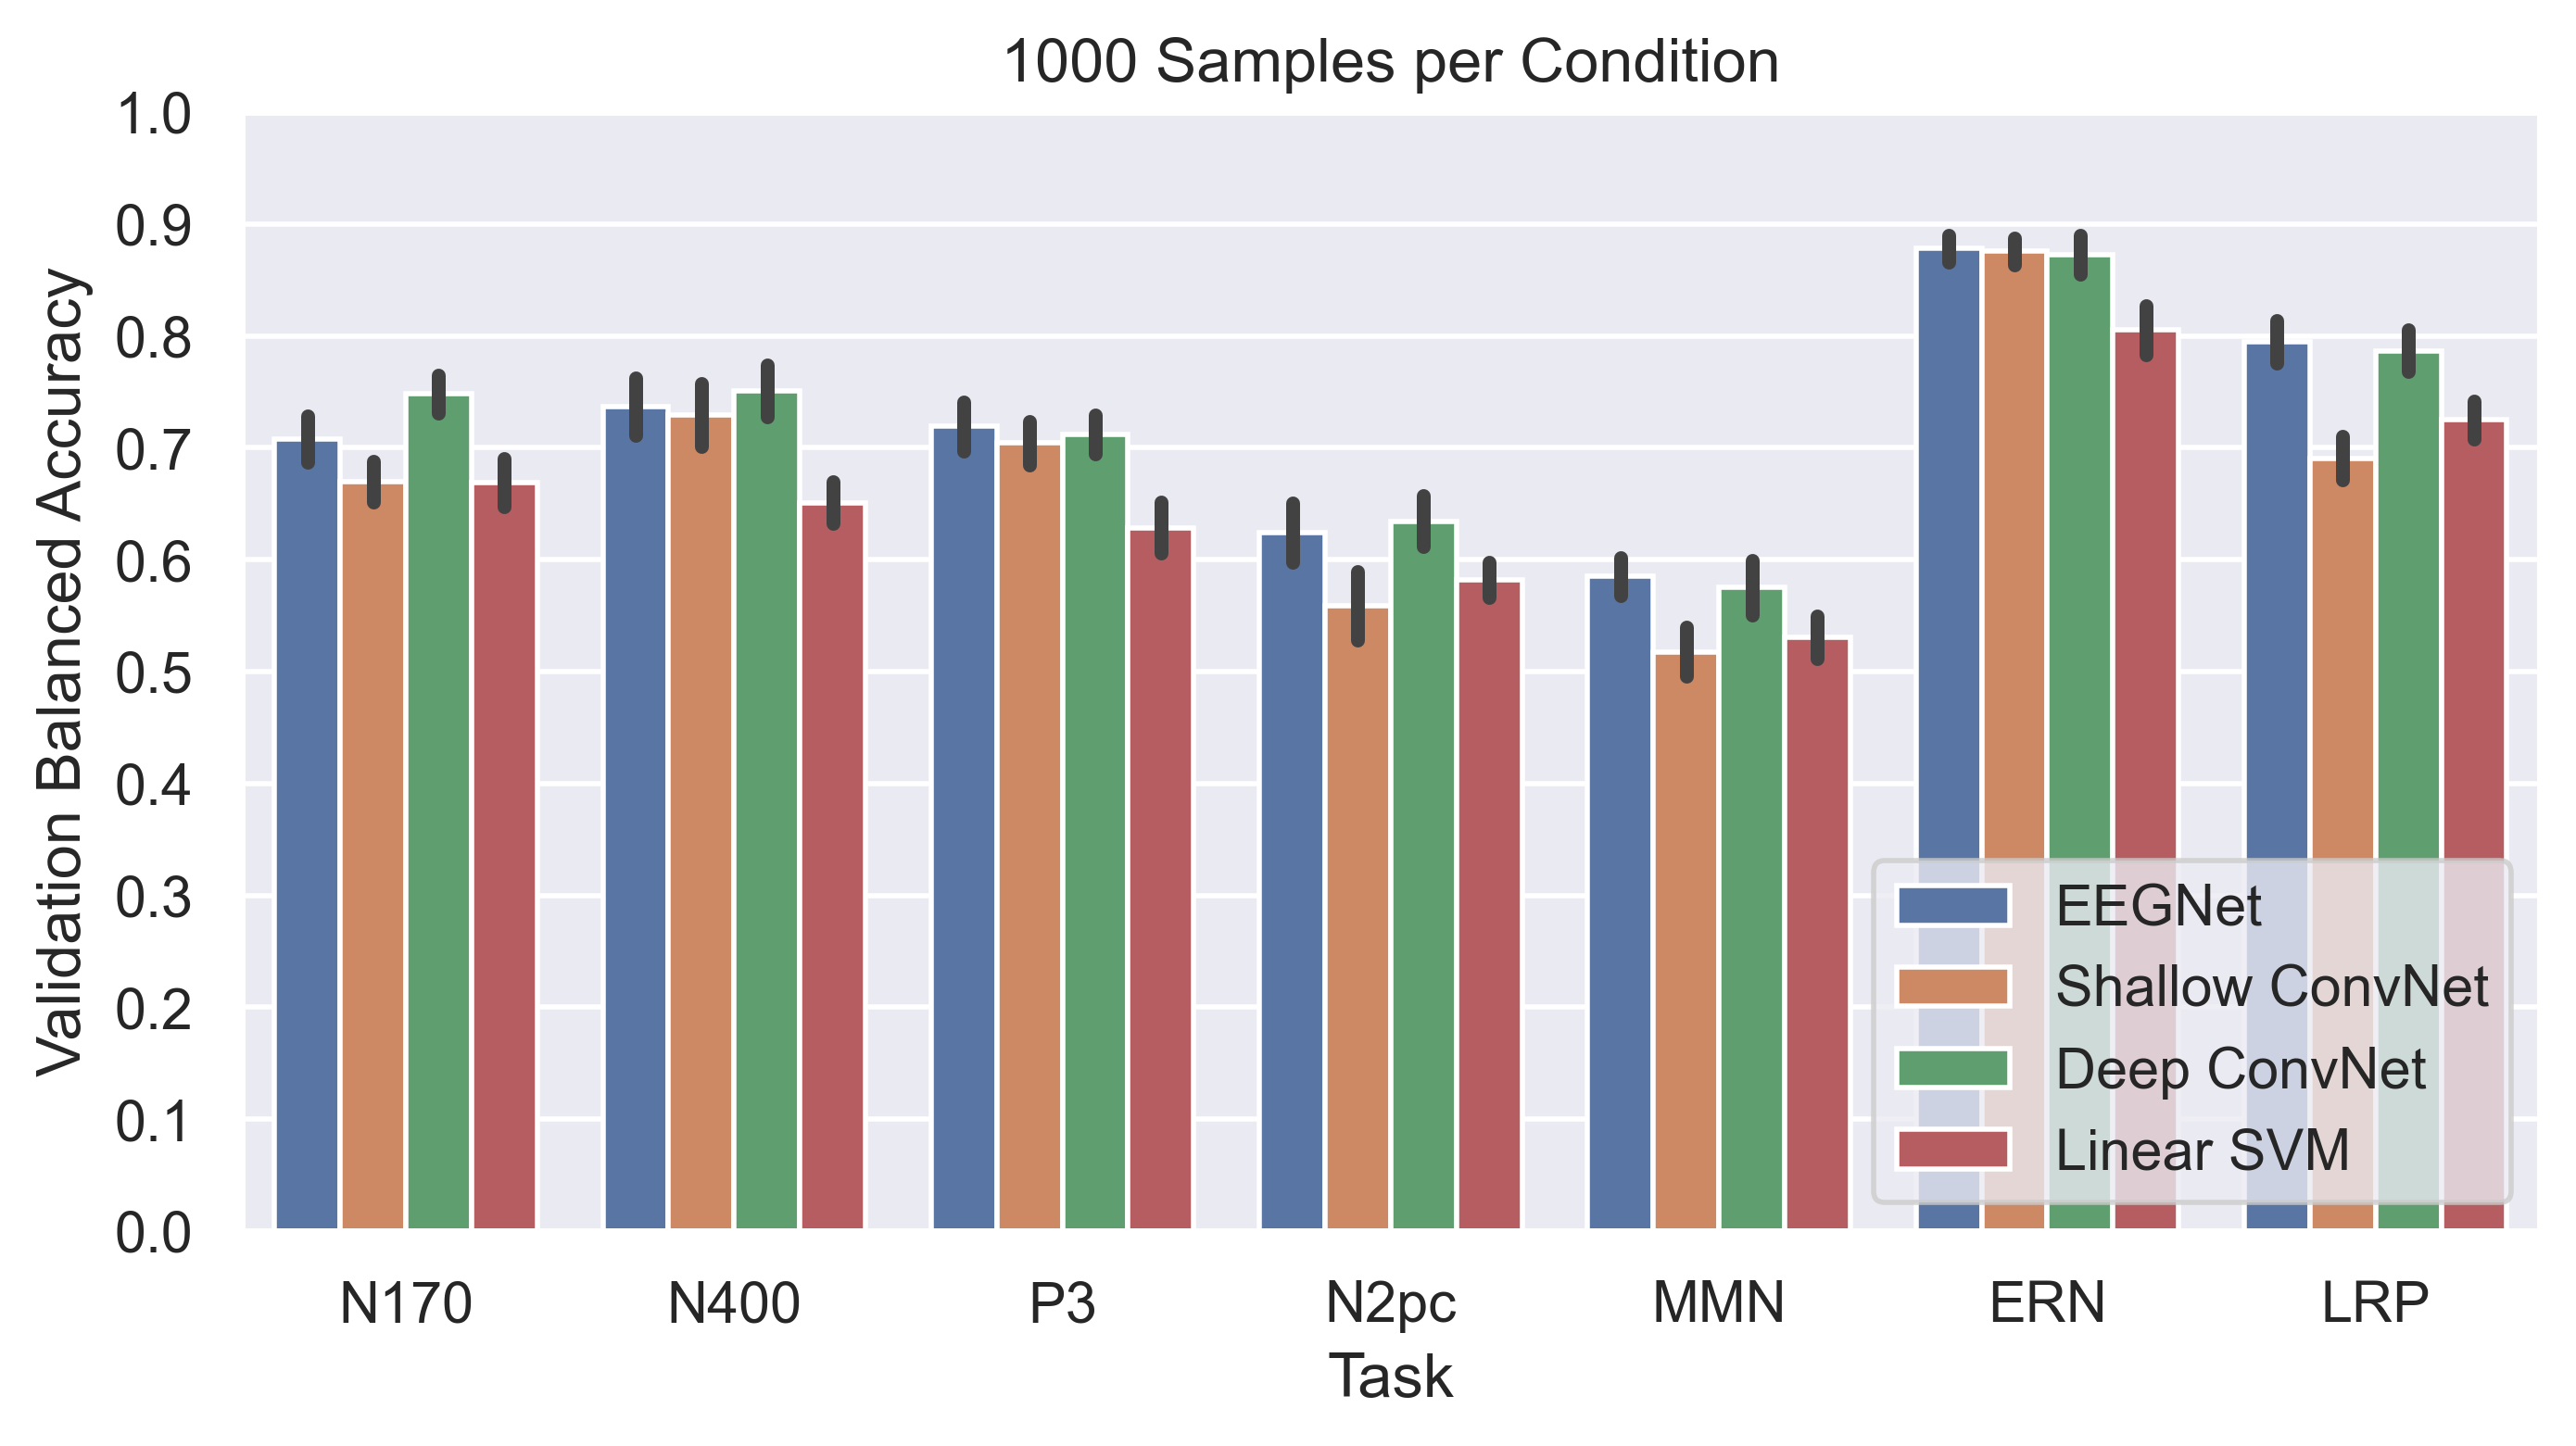

In [122]:
# Load data for 1000 samples and plot

data_path = "F:/Masterthesis/Data/"
model_name = "eegnet"
model_folder = "ModelComparison_EqualSamples1000"
n_epochs = 25
n_splits = 10

# Get Results
results = []
for model_name in ["eegnet","shallow","deep"]:
    for preprocessing in ["medium"]:
        for task in ["N170", "N400", "P3", "N2pc", "MMN", "ERN", "LRP"]:
            df = Training.load_exp(model_folder, model_name, task, preprocessing, n_splits)
            df["Model"] = model_name
            df["Preprocessing"] = preprocessing
            df["Task"] = task
            results.append(df.iloc[-1])
df_results = pd.concat(results, axis=1)
df_results = df_results.transpose().reset_index()
# Put results in correct dataframe for seaborn plot
df_task = df_results[["Task", "Model", "Preprocessing","valid_balanced_accuracy"]]
df_task = df_task.rename(columns={"valid_balanced_accuracy": "Validation Balanced Accuracy"})
list = []
for i in range(3,13):
    list.append(df_task.iloc[:,[0,1,2,i]])
df_task = pd.concat(list, axis=0)
df_task

df_path = os.getcwd()+"\\"+model_folder+"\\"
df_svm = pd.read_csv(df_path+"df_svm.csv")
df_task = df_task.append(df_svm, ignore_index=True)

# N170 plot, no downsampling
sns.set(style="darkgrid")
plt.figure(figsize=(8, 4), dpi=400)
plt.title("1000 Samples per Condition")
g = sns.barplot(x="Task", y="Validation Balanced Accuracy", 
            hue="Model", 
            data=df_task, ci="sd")
g.set_yticks(np.round(np.arange(0,1.1,0.1),1))
l = plt.legend(loc='lower right')
l.get_texts()[0].set_text('EEGNet')
l.get_texts()[1].set_text('Shallow ConvNet')
l.get_texts()[2].set_text('Deep ConvNet')
l.get_texts()[3].set_text('Linear SVM')

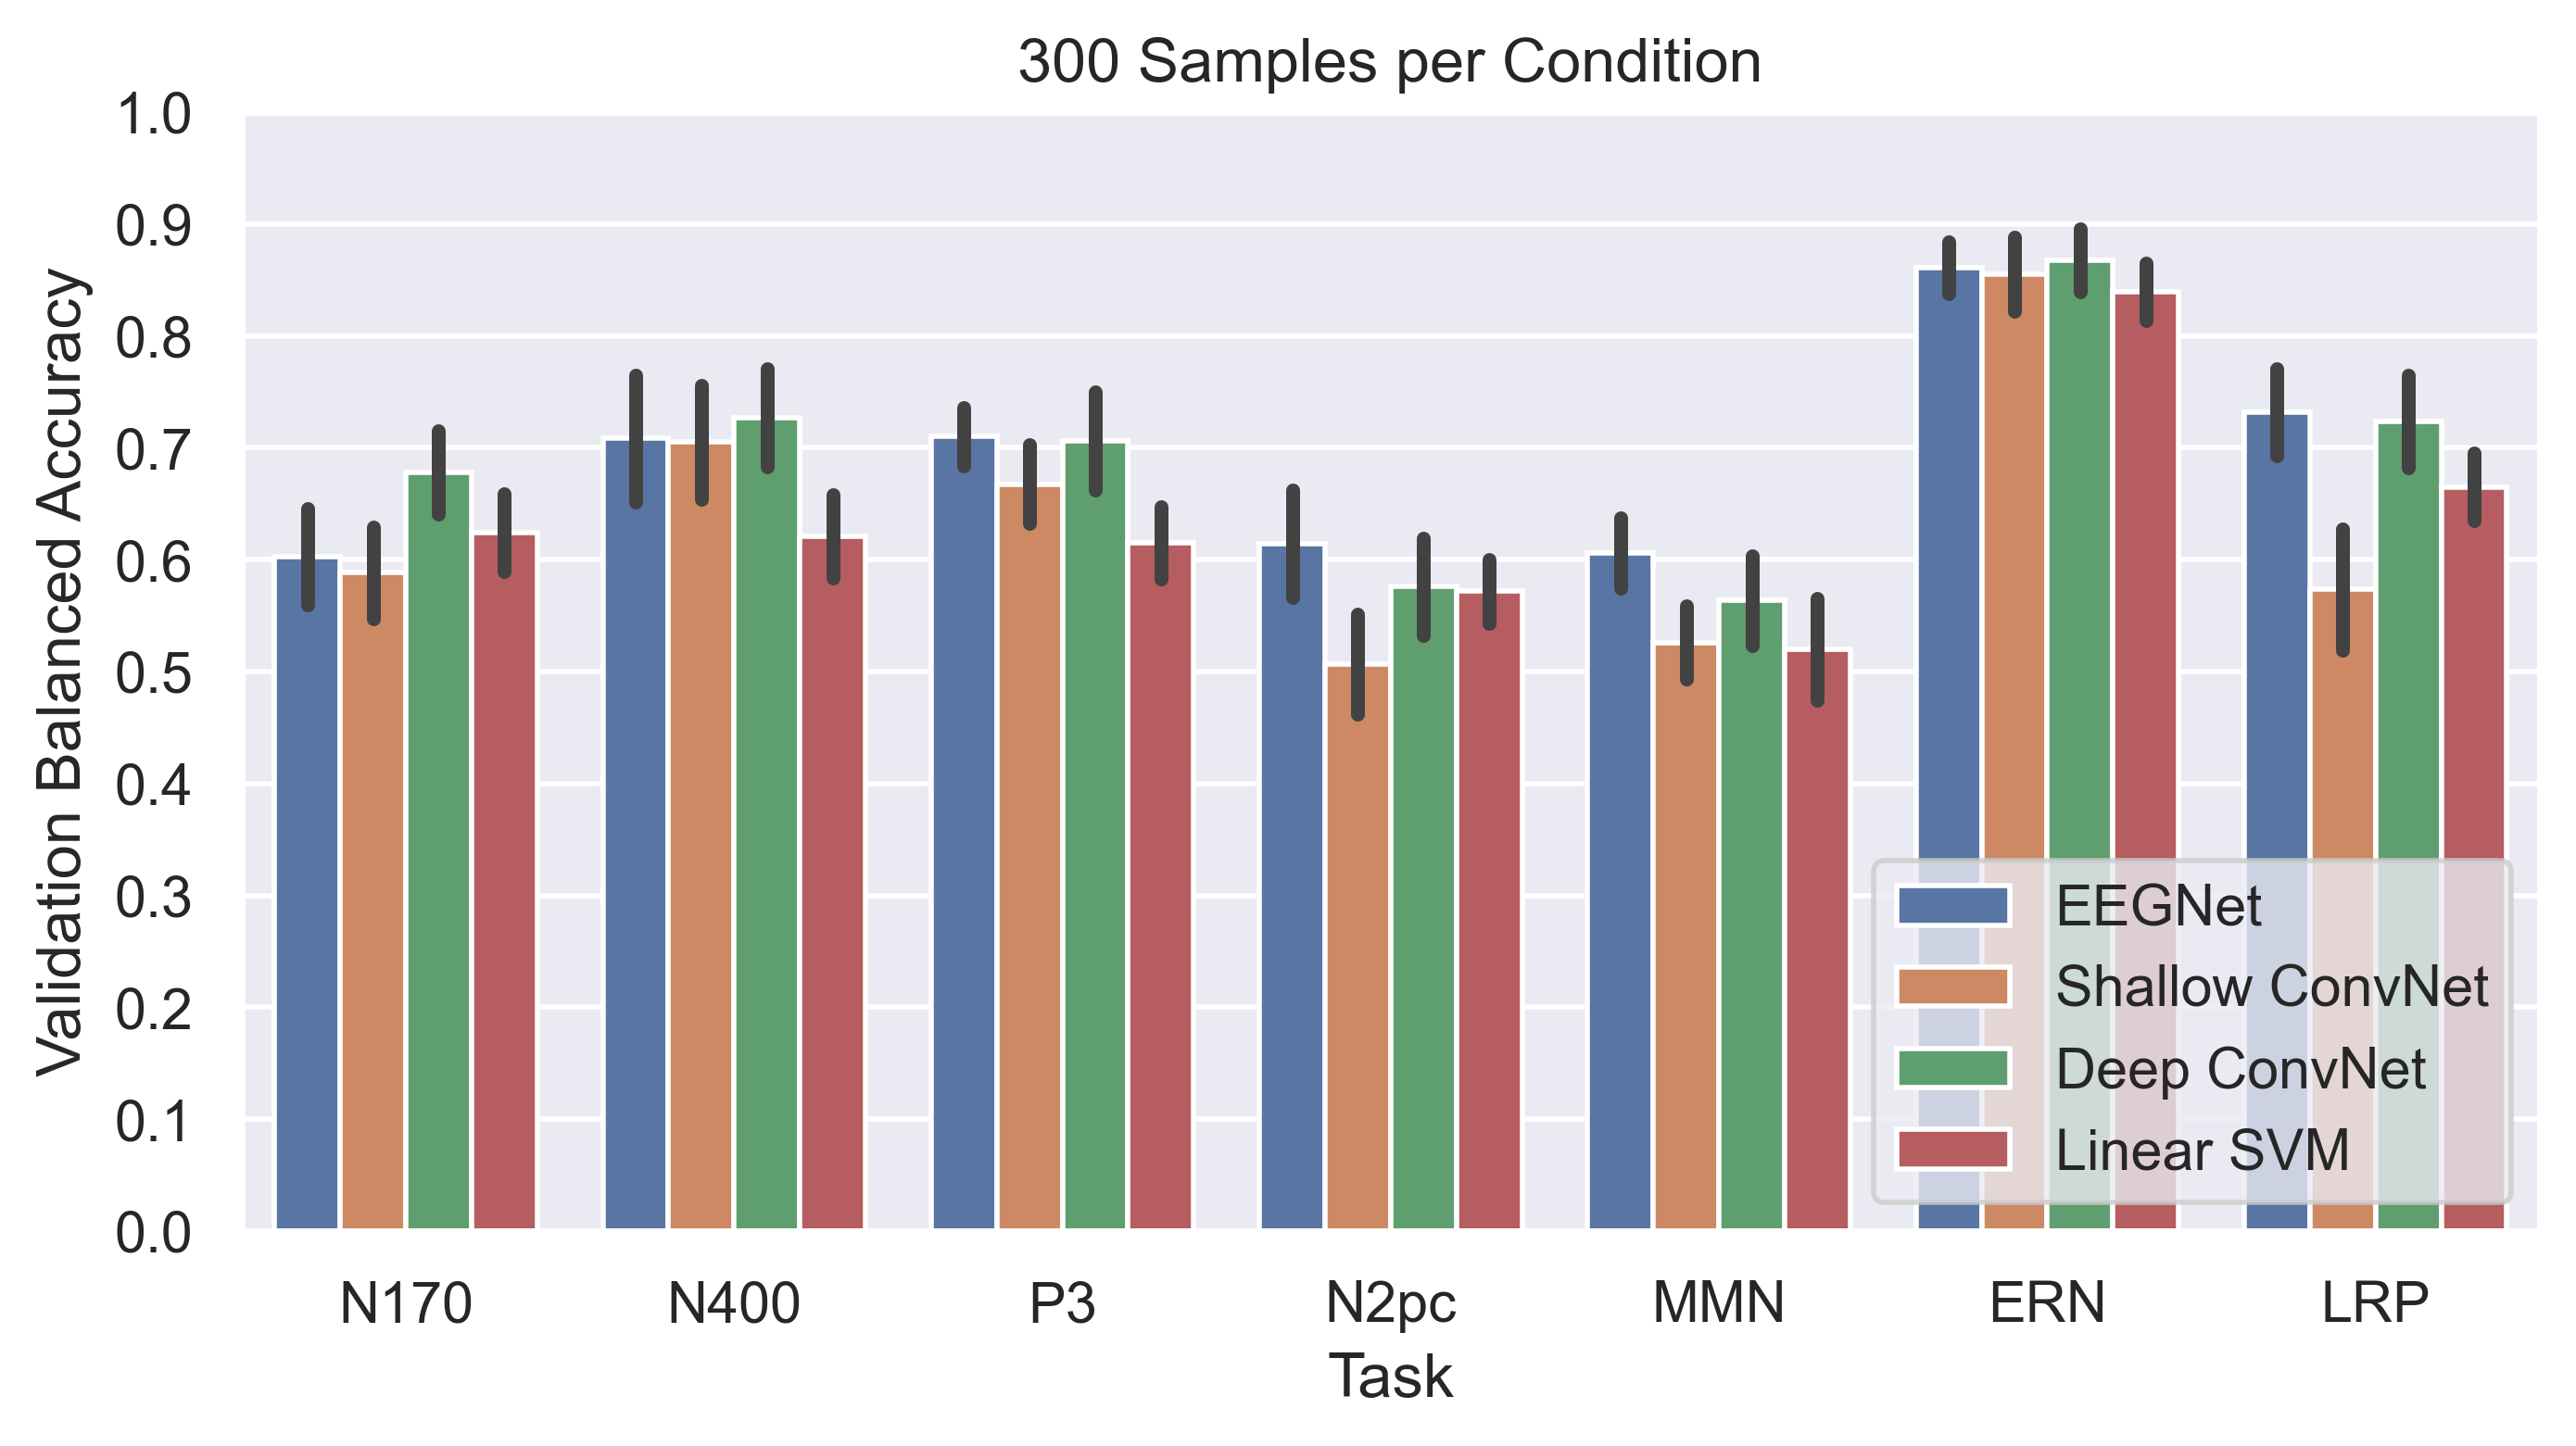

In [123]:
# Load data for 300 samples and plot

data_path = "F:/Masterthesis/Data/"
model_name = "eegnet"
model_folder = "ModelComparison_EqualSamples300"
n_epochs = 25
n_splits = 10

# Get Results
results = []
for model_name in ["eegnet","shallow","deep"]:
    for preprocessing in ["medium"]:
        for task in ["N170", "N400", "P3", "N2pc", "MMN", "ERN", "LRP"]:
            df = Training.load_exp(model_folder, model_name, task, preprocessing, n_splits)
            df["Model"] = model_name
            df["Preprocessing"] = preprocessing
            df["Task"] = task
            results.append(df.iloc[-1])
df_results = pd.concat(results, axis=1)
df_results = df_results.transpose().reset_index()
# Put results in correct dataframe for seaborn plot
df_task = df_results[["Task", "Model", "Preprocessing","valid_balanced_accuracy"]]
df_task = df_task.rename(columns={"valid_balanced_accuracy": "Validation Balanced Accuracy"})
list = []
for i in range(3,13):
    list.append(df_task.iloc[:,[0,1,2,i]])
df_task = pd.concat(list, axis=0)
df_task

df_path = os.getcwd()+"\\"+model_folder+"\\"
df_svm = pd.read_csv(df_path+"df_svm.csv")
df_task = df_task.append(df_svm, ignore_index=True)

# N170 plot, no downsampling
sns.set(style="darkgrid")
plt.figure(figsize=(8, 4), dpi=400)
plt.title("300 Samples per Condition")
g = sns.barplot(x="Task", y="Validation Balanced Accuracy", 
            hue="Model", 
            data=df_task, ci="sd")
g.set_yticks(np.round(np.arange(0,1.1,0.1),1))
l = plt.legend(loc='lower right')
l.get_texts()[0].set_text('EEGNet')
l.get_texts()[1].set_text('Shallow ConvNet')
l.get_texts()[2].set_text('Deep ConvNet')
l.get_texts()[3].set_text('Linear SVM')

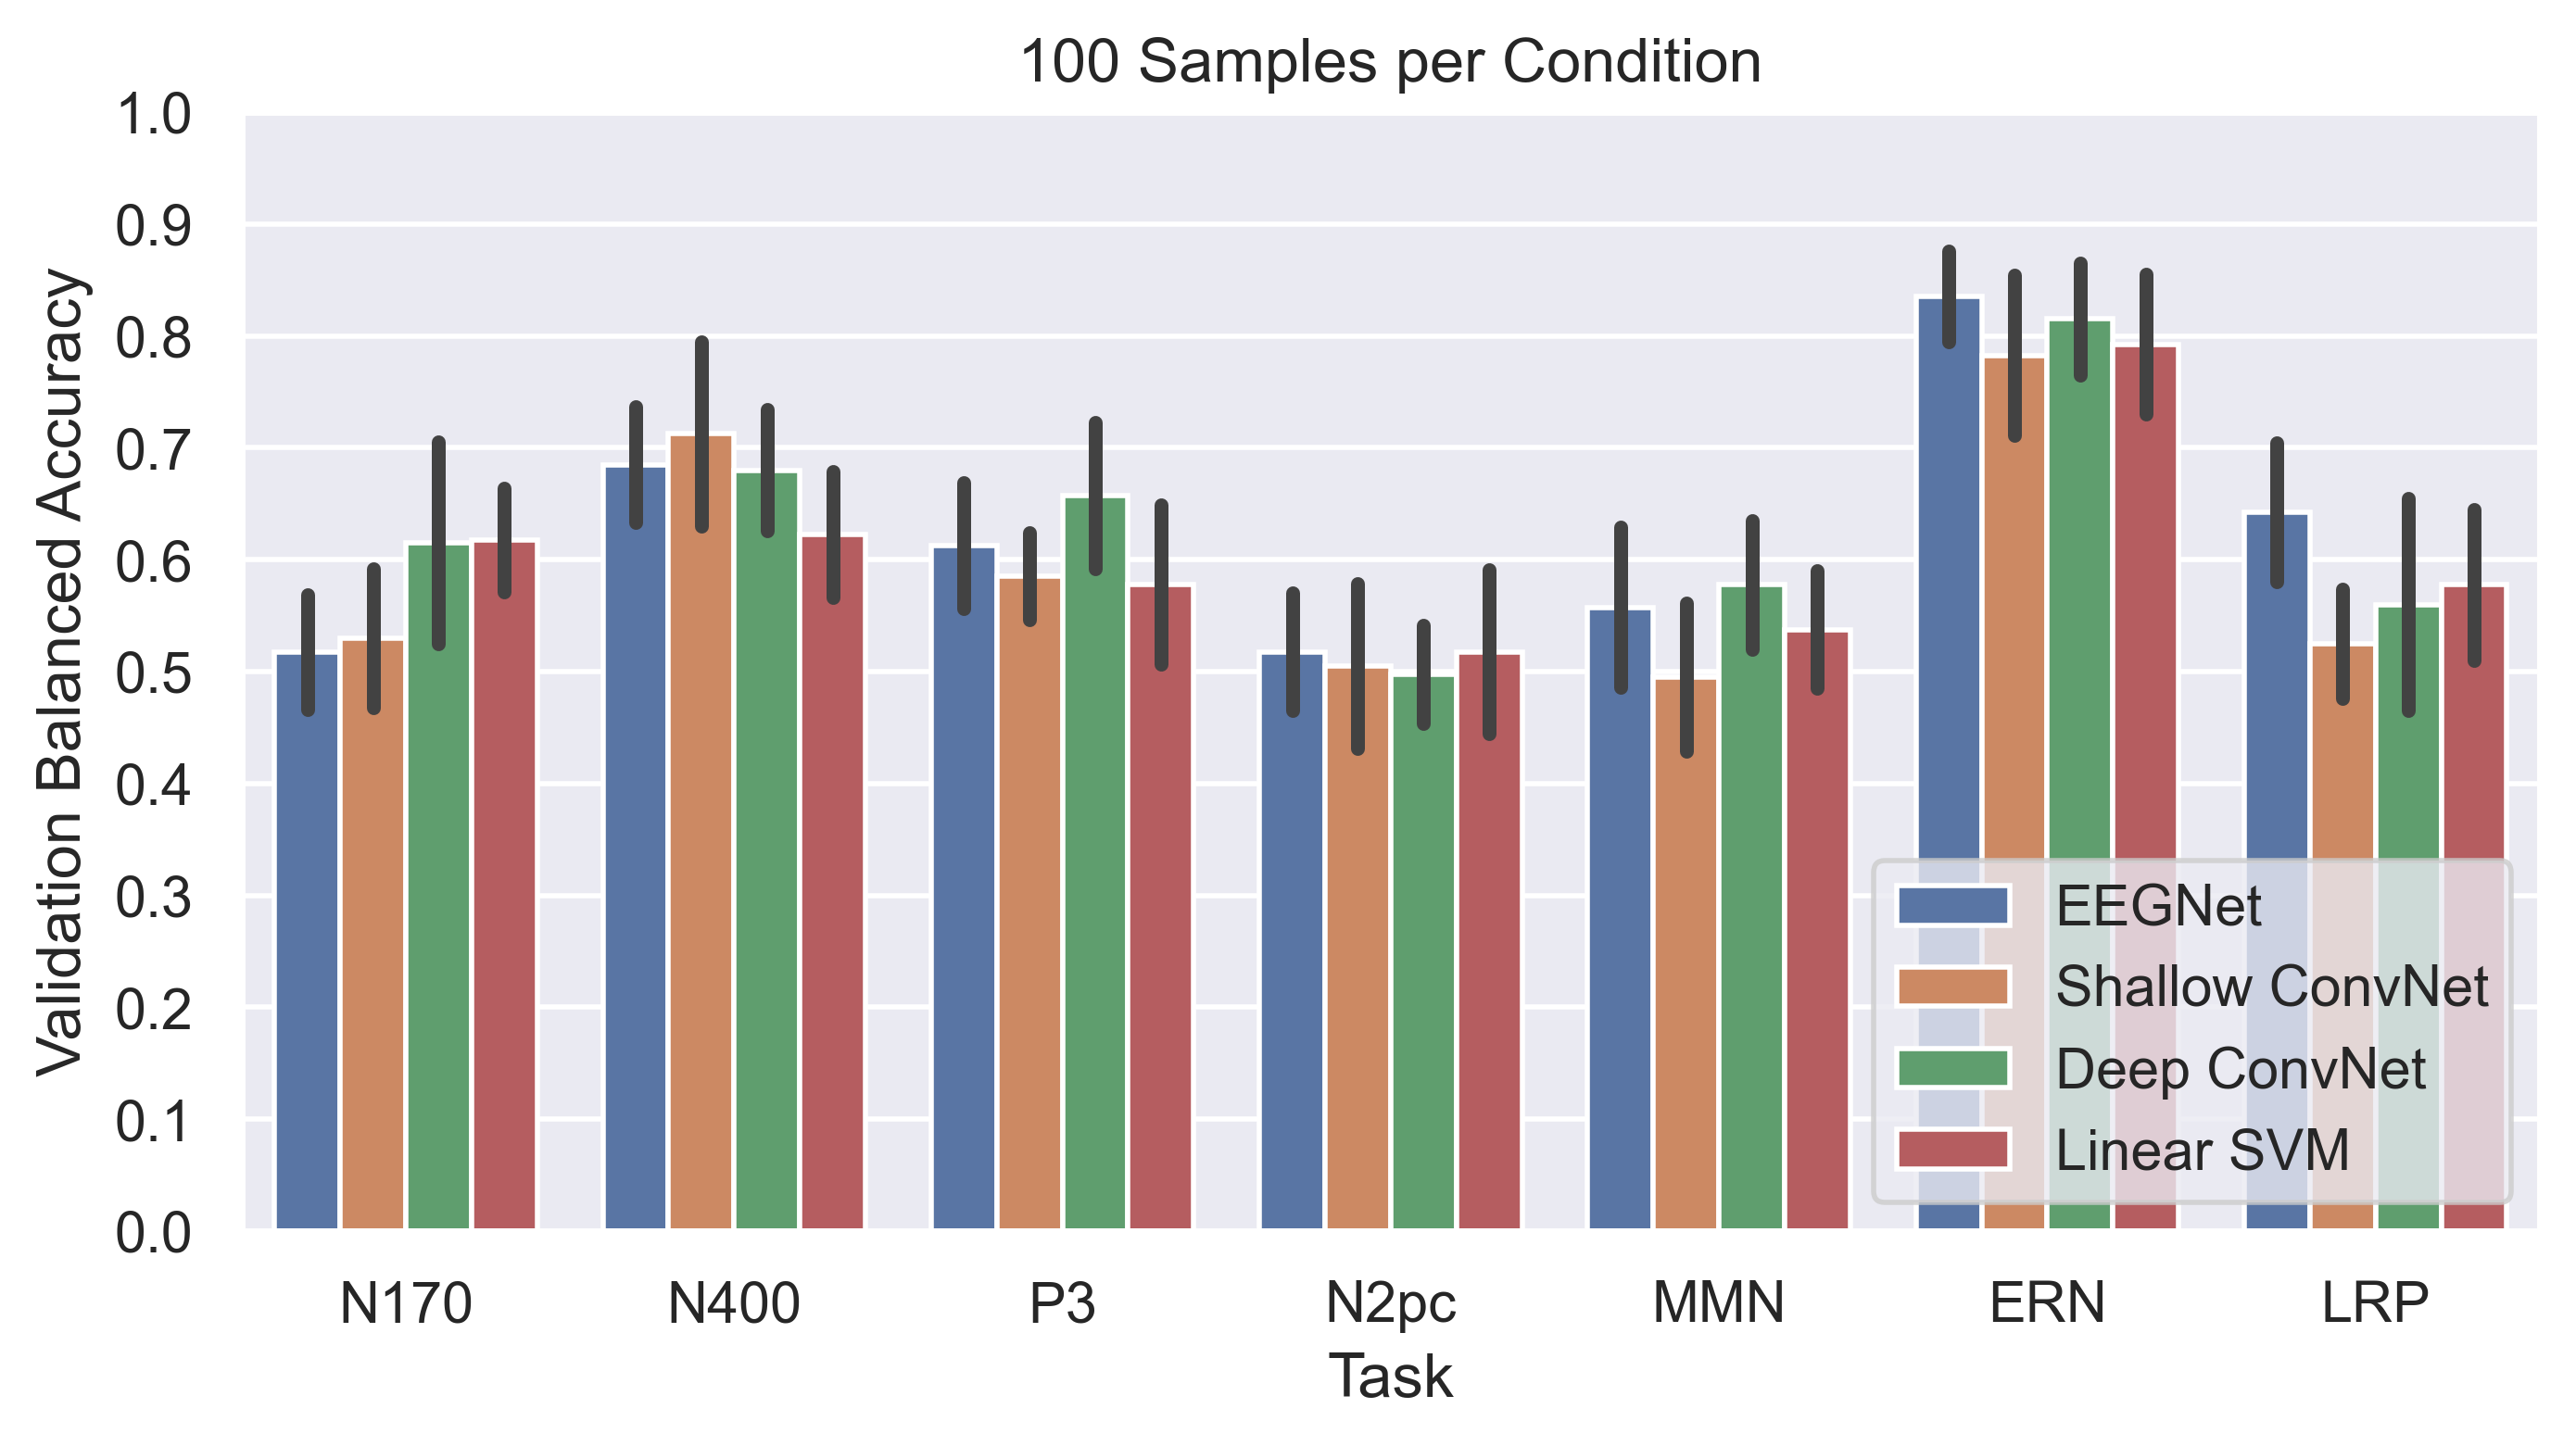

In [125]:
# Load data for 100 samples and plot

data_path = "F:/Masterthesis/Data/"
model_name = "eegnet"
model_folder = "ModelComparison_EqualSamples100"
n_epochs = 25
n_splits = 10

# Get Results
results = []
for model_name in ["eegnet","shallow","deep"]:
    for preprocessing in ["medium"]:
        for task in ["N170", "N400", "P3", "N2pc", "MMN", "ERN", "LRP"]:
            df = Training.load_exp(model_folder, model_name, task, preprocessing, n_splits)
            df["Model"] = model_name
            df["Preprocessing"] = preprocessing
            df["Task"] = task
            results.append(df.iloc[-1])
df_results = pd.concat(results, axis=1)
df_results = df_results.transpose().reset_index()
# Put results in correct dataframe for seaborn plot
df_task = df_results[["Task", "Model", "Preprocessing","valid_balanced_accuracy"]]
df_task = df_task.rename(columns={"valid_balanced_accuracy": "Validation Balanced Accuracy"})
list = []
for i in range(3,13):
    list.append(df_task.iloc[:,[0,1,2,i]])
df_task = pd.concat(list, axis=0)
df_task

df_path = os.getcwd()+"\\"+model_folder+"\\"
df_svm = pd.read_csv(df_path+"df_svm.csv")
df_task = df_task.append(df_svm, ignore_index=True)

# N170 plot, no downsampling
sns.set(style="darkgrid")
plt.figure(figsize=(8, 4), dpi=400)
plt.title("100 Samples per Condition")
g = sns.barplot(x="Task", y="Validation Balanced Accuracy", 
            hue="Model", 
            data=df_task, ci="sd")
g.set_yticks(np.round(np.arange(0,1.1,0.1),1))
l = plt.legend(loc='lower right')
l.get_texts()[0].set_text('EEGNet')
l.get_texts()[1].set_text('Shallow ConvNet')
l.get_texts()[2].set_text('Deep ConvNet')
l.get_texts()[3].set_text('Linear SVM')

In [7]:
# Load data for 100 samples and plot

data_path = "F:/Masterthesis/Data/"
model_name = "eegnet"
n_epochs = 25
n_splits = 10

df_list = []

# Get Results
for samples in ["200", "600", "2000", "All"]:
    if samples == "200":
        model_folder = "ModelComparison_EqualSamples100"
    elif samples == "600":
        model_folder = "ModelComparison_EqualSamples300"
    elif samples == "2000":
        model_folder = "ModelComparison_EqualSamples1000"
    else:
        model_folder = "ModelComparison"
    results = []
    for model_name in ["eegnet","shallow","deep"]:
        for preprocessing in ["medium"]:
            for task in ["N170", "N400", "P3", "N2pc", "MMN", "ERN", "LRP"]:
                df = Training.load_exp(model_folder, model_name, task, preprocessing, n_splits)
                df["Model"] = model_name
                df["Preprocessing"] = preprocessing
                df["Task"] = task
                results.append(df.iloc[-1])
    df_results = pd.concat(results, axis=1)
    df_results = df_results.transpose().reset_index()
    # Put results in correct dataframe for seaborn plot
    df_task = df_results[["Task", "Model", "Preprocessing","valid_balanced_accuracy"]]
    df_task = df_task.rename(columns={"valid_balanced_accuracy": "Validation Balanced Accuracy"})
    list = []
    for i in range(3,13):
        list.append(df_task.iloc[:,[0,1,2,i]])
    df_task = pd.concat(list, axis=0)
    df_path = os.getcwd()+"\\"+model_folder+"\\"
    df_svm = pd.read_csv(df_path+"df_svm.csv")
    df_task = df_task.append(df_svm, ignore_index=True)
    df_task["Sample Count"] = samples
    df_list.append(df_task)
df_task = pd.concat(df_list, axis=0)

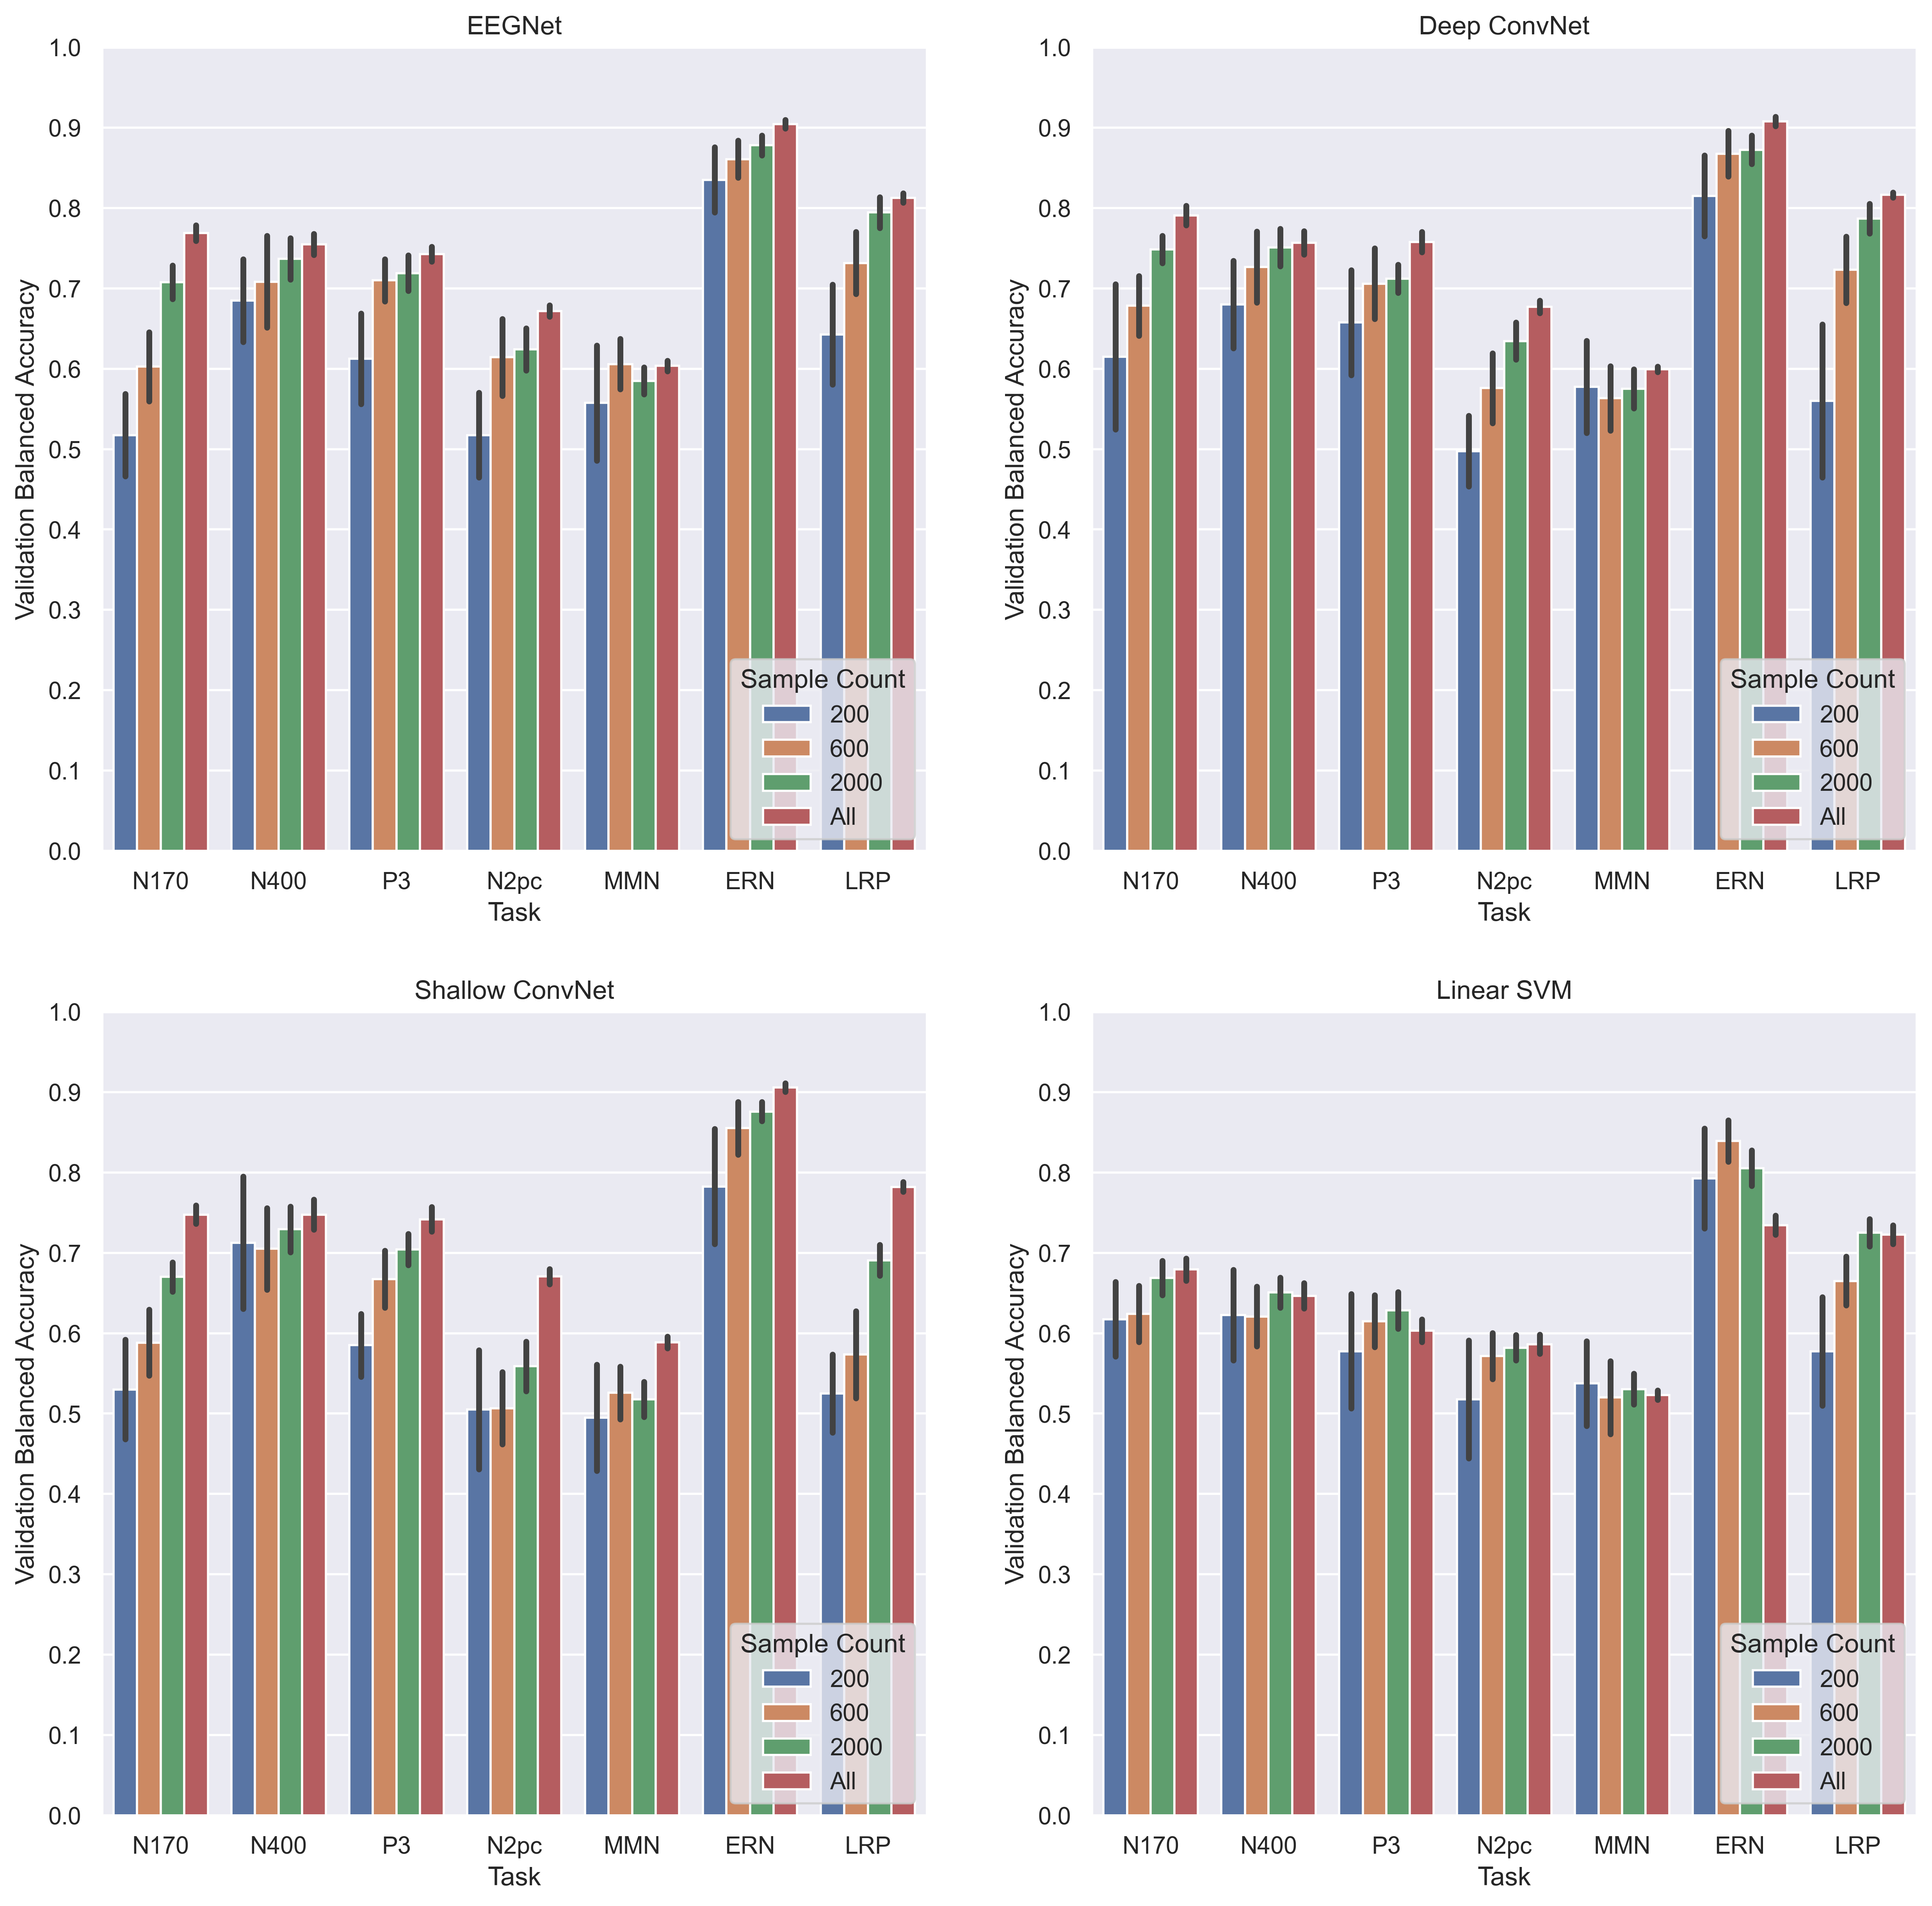

In [8]:
sns.set(style="darkgrid")
fig, axes = plt.subplots(2, 2, figsize=(15, 15), dpi=400)
#axes[0,0].title("EEGNet")
sns.barplot(ax=axes[0,0], x="Task", y="Validation Balanced Accuracy", 
            hue="Sample Count", 
            data=df_task[df_task["Model"]=="eegnet"], ci="sd")
axes[0,0].set_yticks(np.round(np.arange(0,1.1,0.1),1))
axes[0,0].set_title("EEGNet")
axes[0,0].legend(title="Sample Count", loc='lower right');

sns.barplot(ax=axes[0,1], x="Task", y="Validation Balanced Accuracy", 
            hue="Sample Count", 
            data=df_task[df_task["Model"]=="deep"], ci="sd")
axes[0,1].set_yticks(np.round(np.arange(0,1.1,0.1),1))
axes[0,1].set_title("Deep ConvNet")
axes[0,1].legend(title="Sample Count", loc='lower right');

sns.barplot(ax=axes[1,0], x="Task", y="Validation Balanced Accuracy", 
            hue="Sample Count", 
            data=df_task[df_task["Model"]=="shallow"], ci="sd")
axes[1,0].set_yticks(np.round(np.arange(0,1.1,0.1),1))
axes[1,0].set_title("Shallow ConvNet")
axes[1,0].legend(title="Sample Count", loc='lower right');

sns.barplot(ax=axes[1,1], x="Task", y="Validation Balanced Accuracy", 
            hue="Sample Count", 
            data=df_task[df_task["Model"]=="SVM"], ci="sd")
axes[1,1].set_yticks(np.round(np.arange(0,1.1,0.1),1))
axes[1,1].set_title("Linear SVM")
axes[1,1].legend(title="Sample Count", loc='lower right');

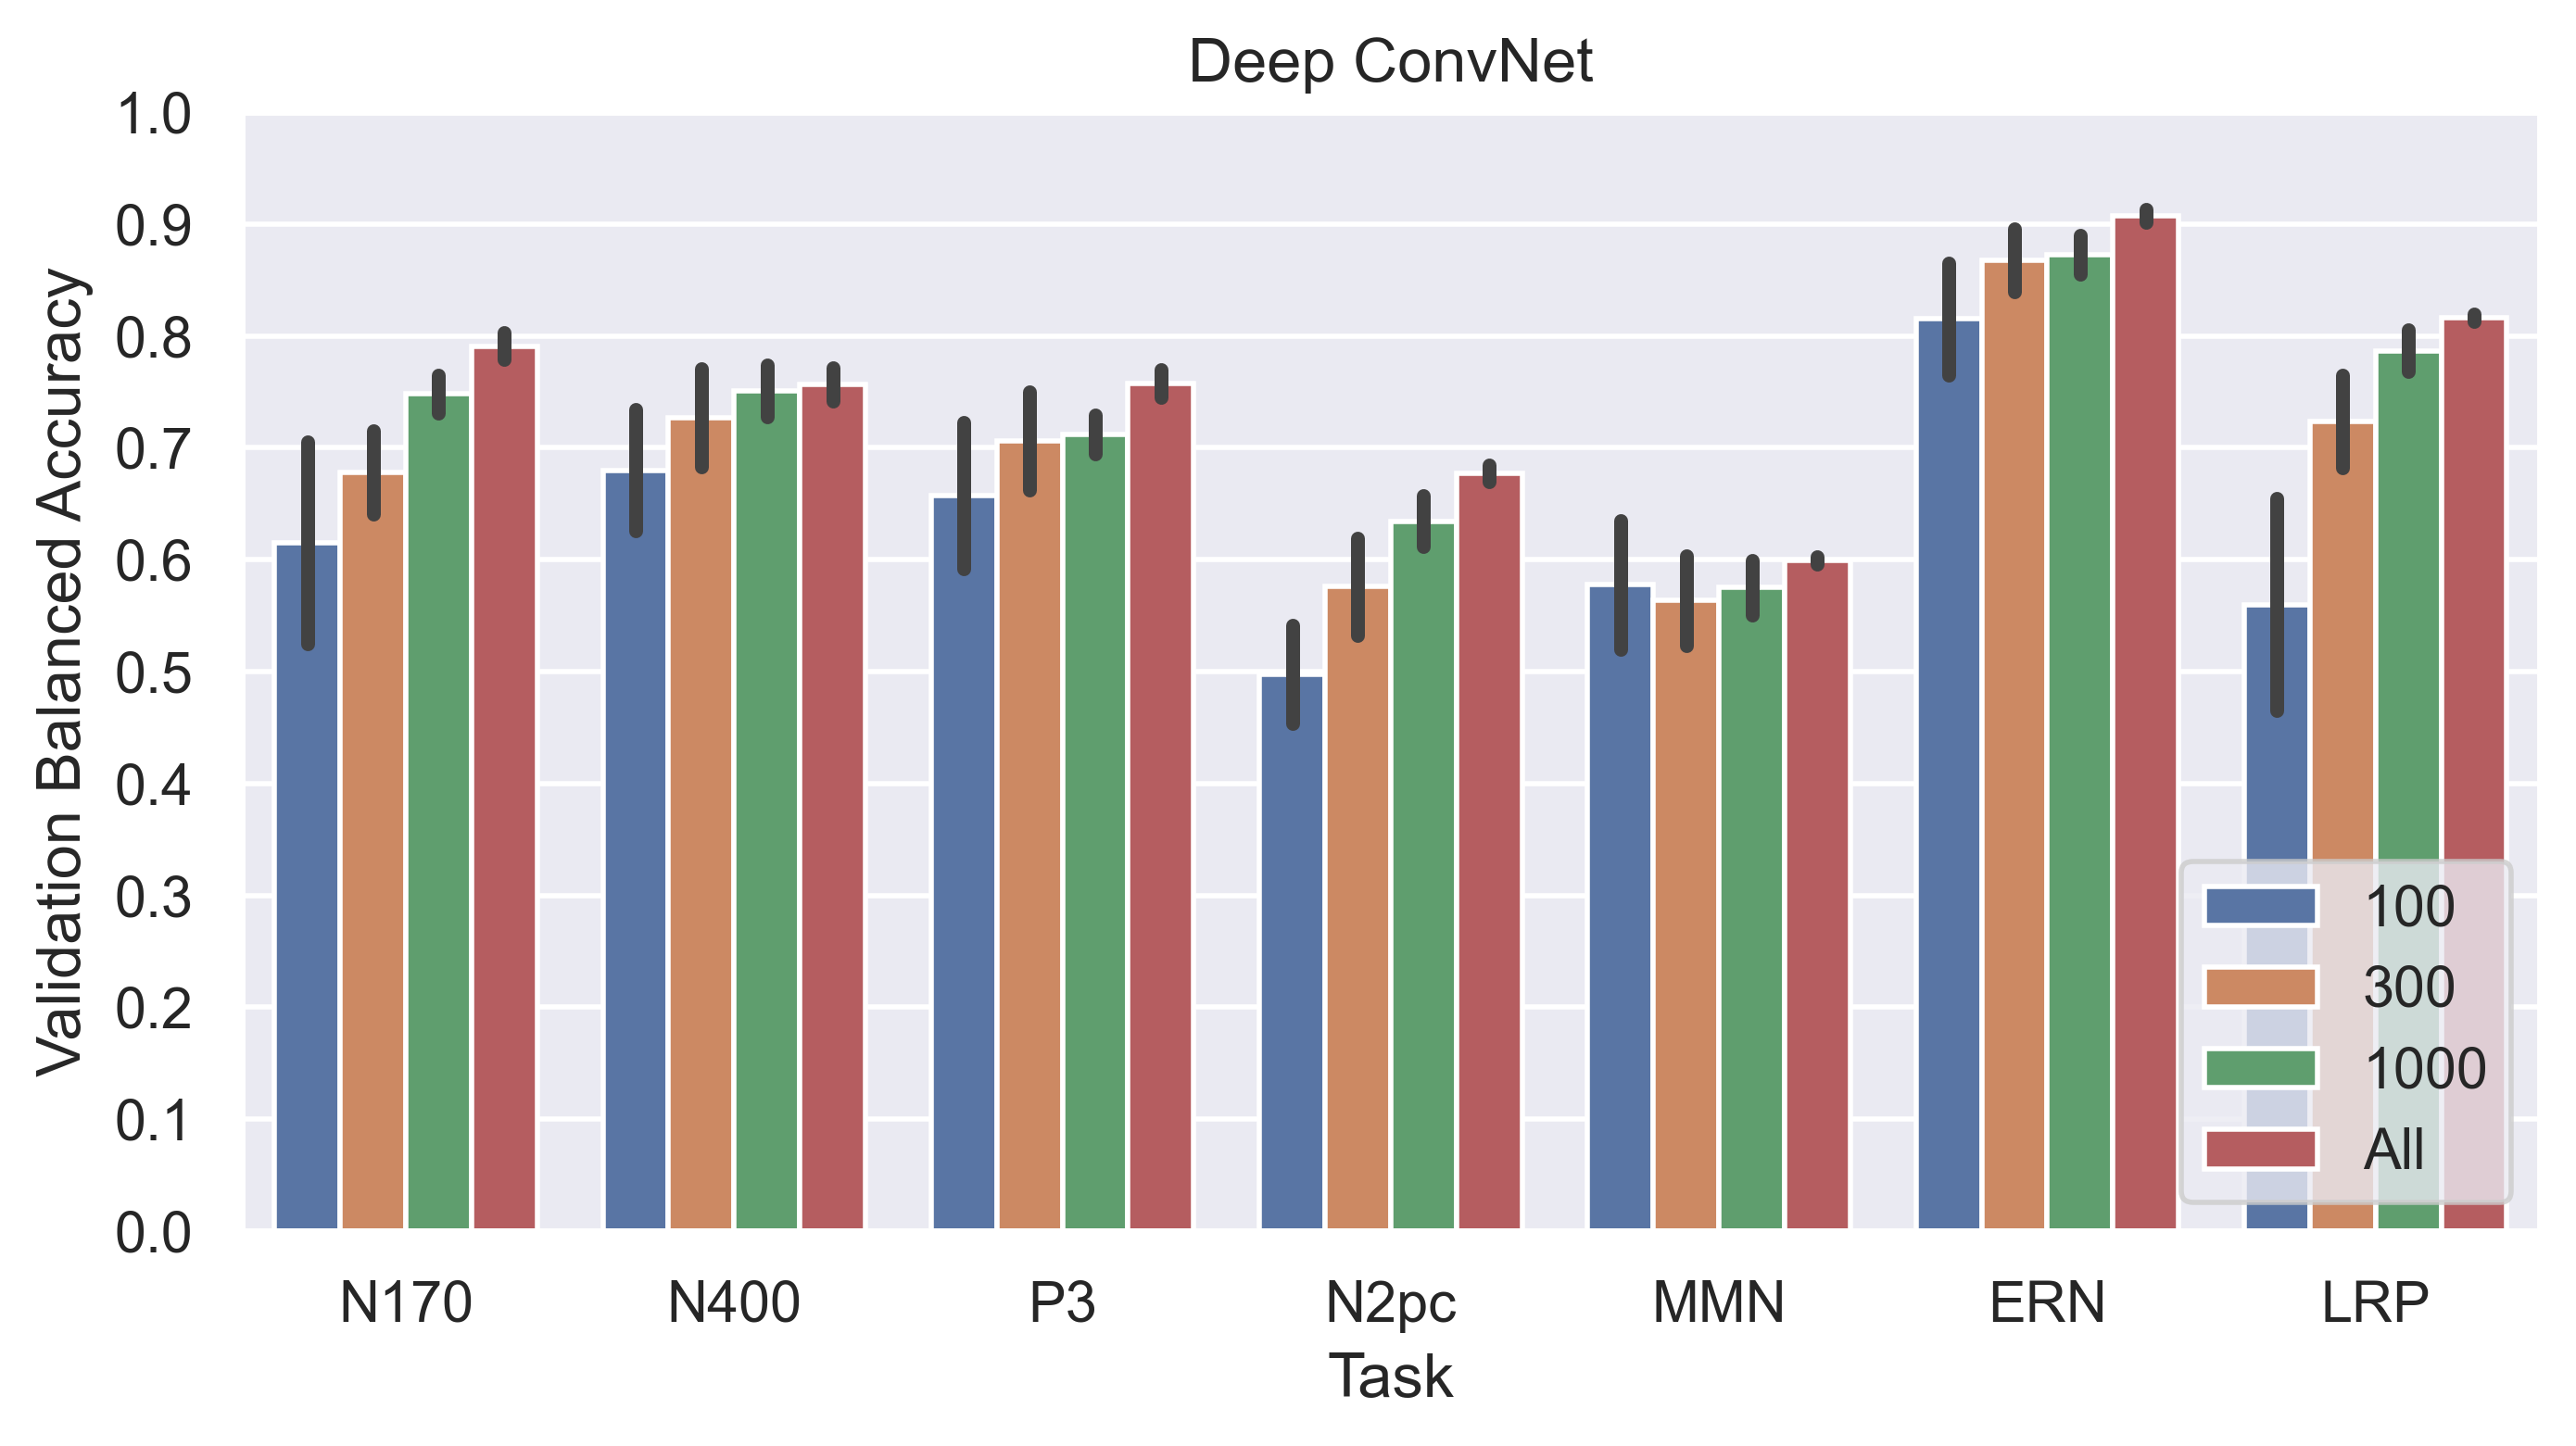

In [172]:
sns.set(style="darkgrid")
plt.figure(figsize=(8, 4), dpi=400)
plt.title("Deep ConvNet")
g = sns.barplot(x="Task", y="Validation Balanced Accuracy", 
            hue="Sample Count", 
            data=df_task[df_task["Model"]=="deep"], ci="sd")
g.set_yticks(np.round(np.arange(0,1.1,0.1),1))
l = plt.legend(loc='lower right');

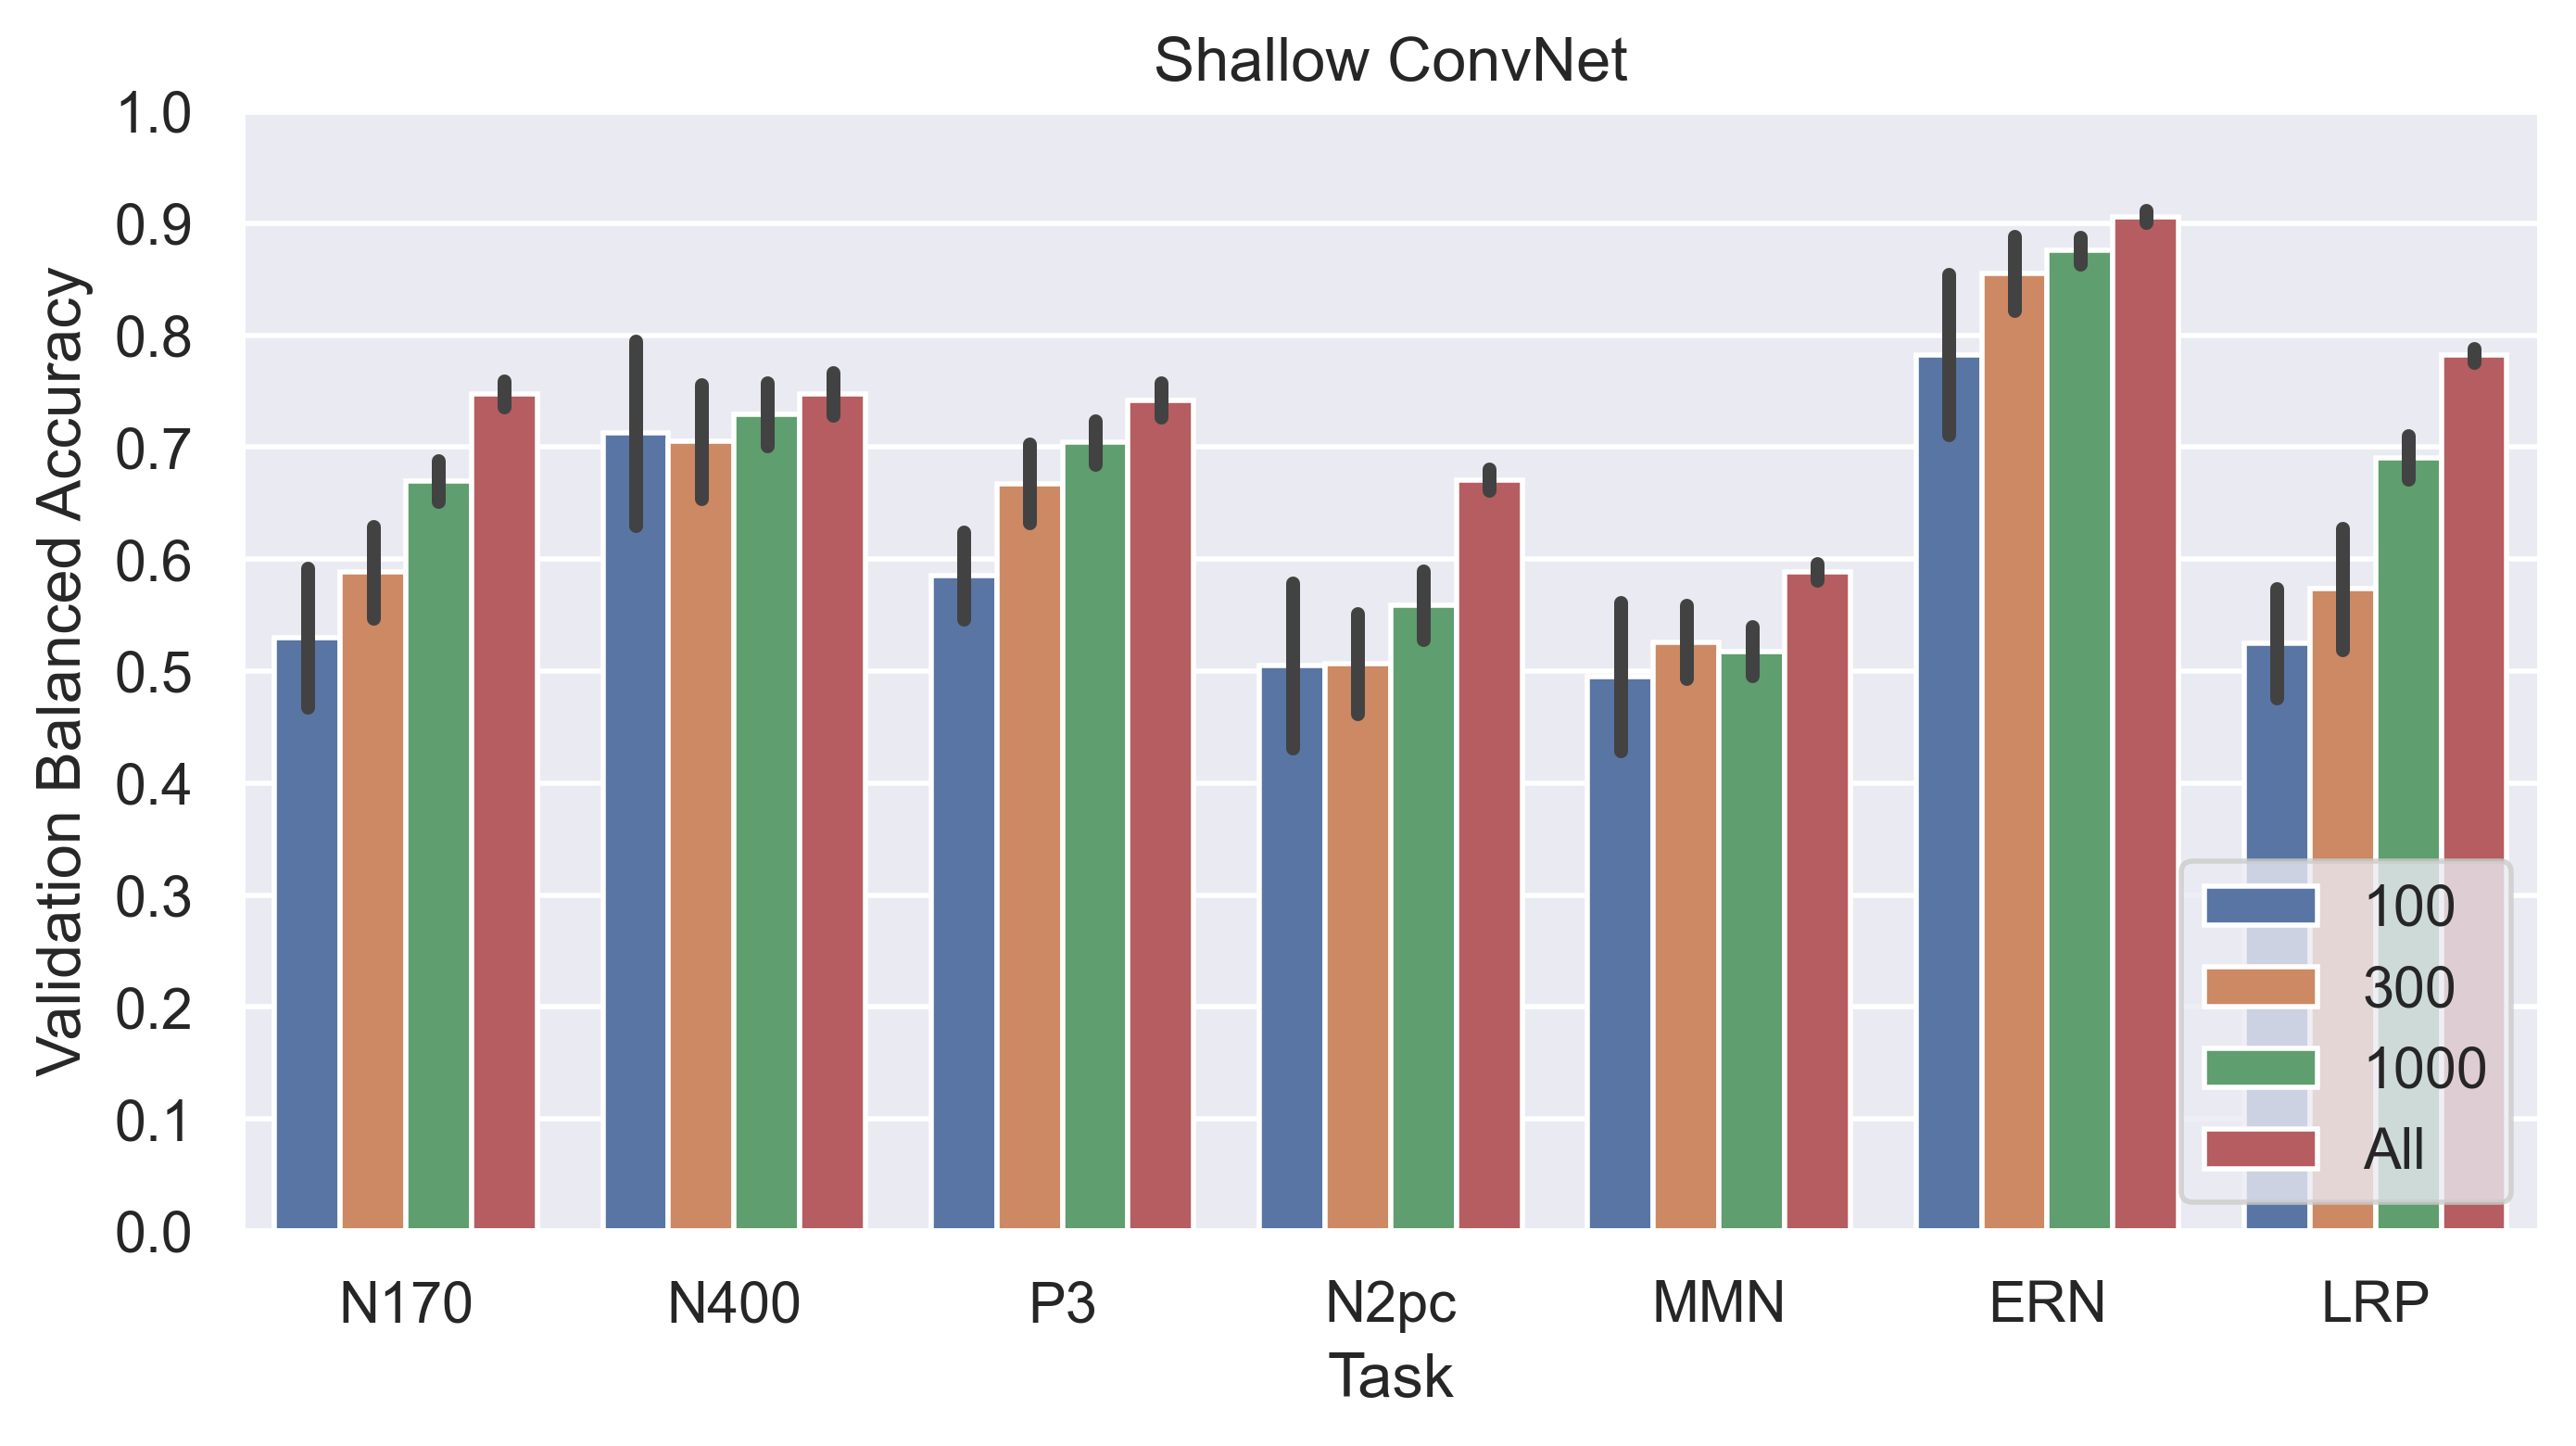

In [173]:
sns.set(style="darkgrid")
plt.figure(figsize=(8, 4), dpi=400)
plt.title("Shallow ConvNet")
g = sns.barplot(x="Task", y="Validation Balanced Accuracy", 
            hue="Sample Count", 
            data=df_task[df_task["Model"]=="shallow"], ci="sd")
g.set_yticks(np.round(np.arange(0,1.1,0.1),1))
l = plt.legend(loc='lower right');

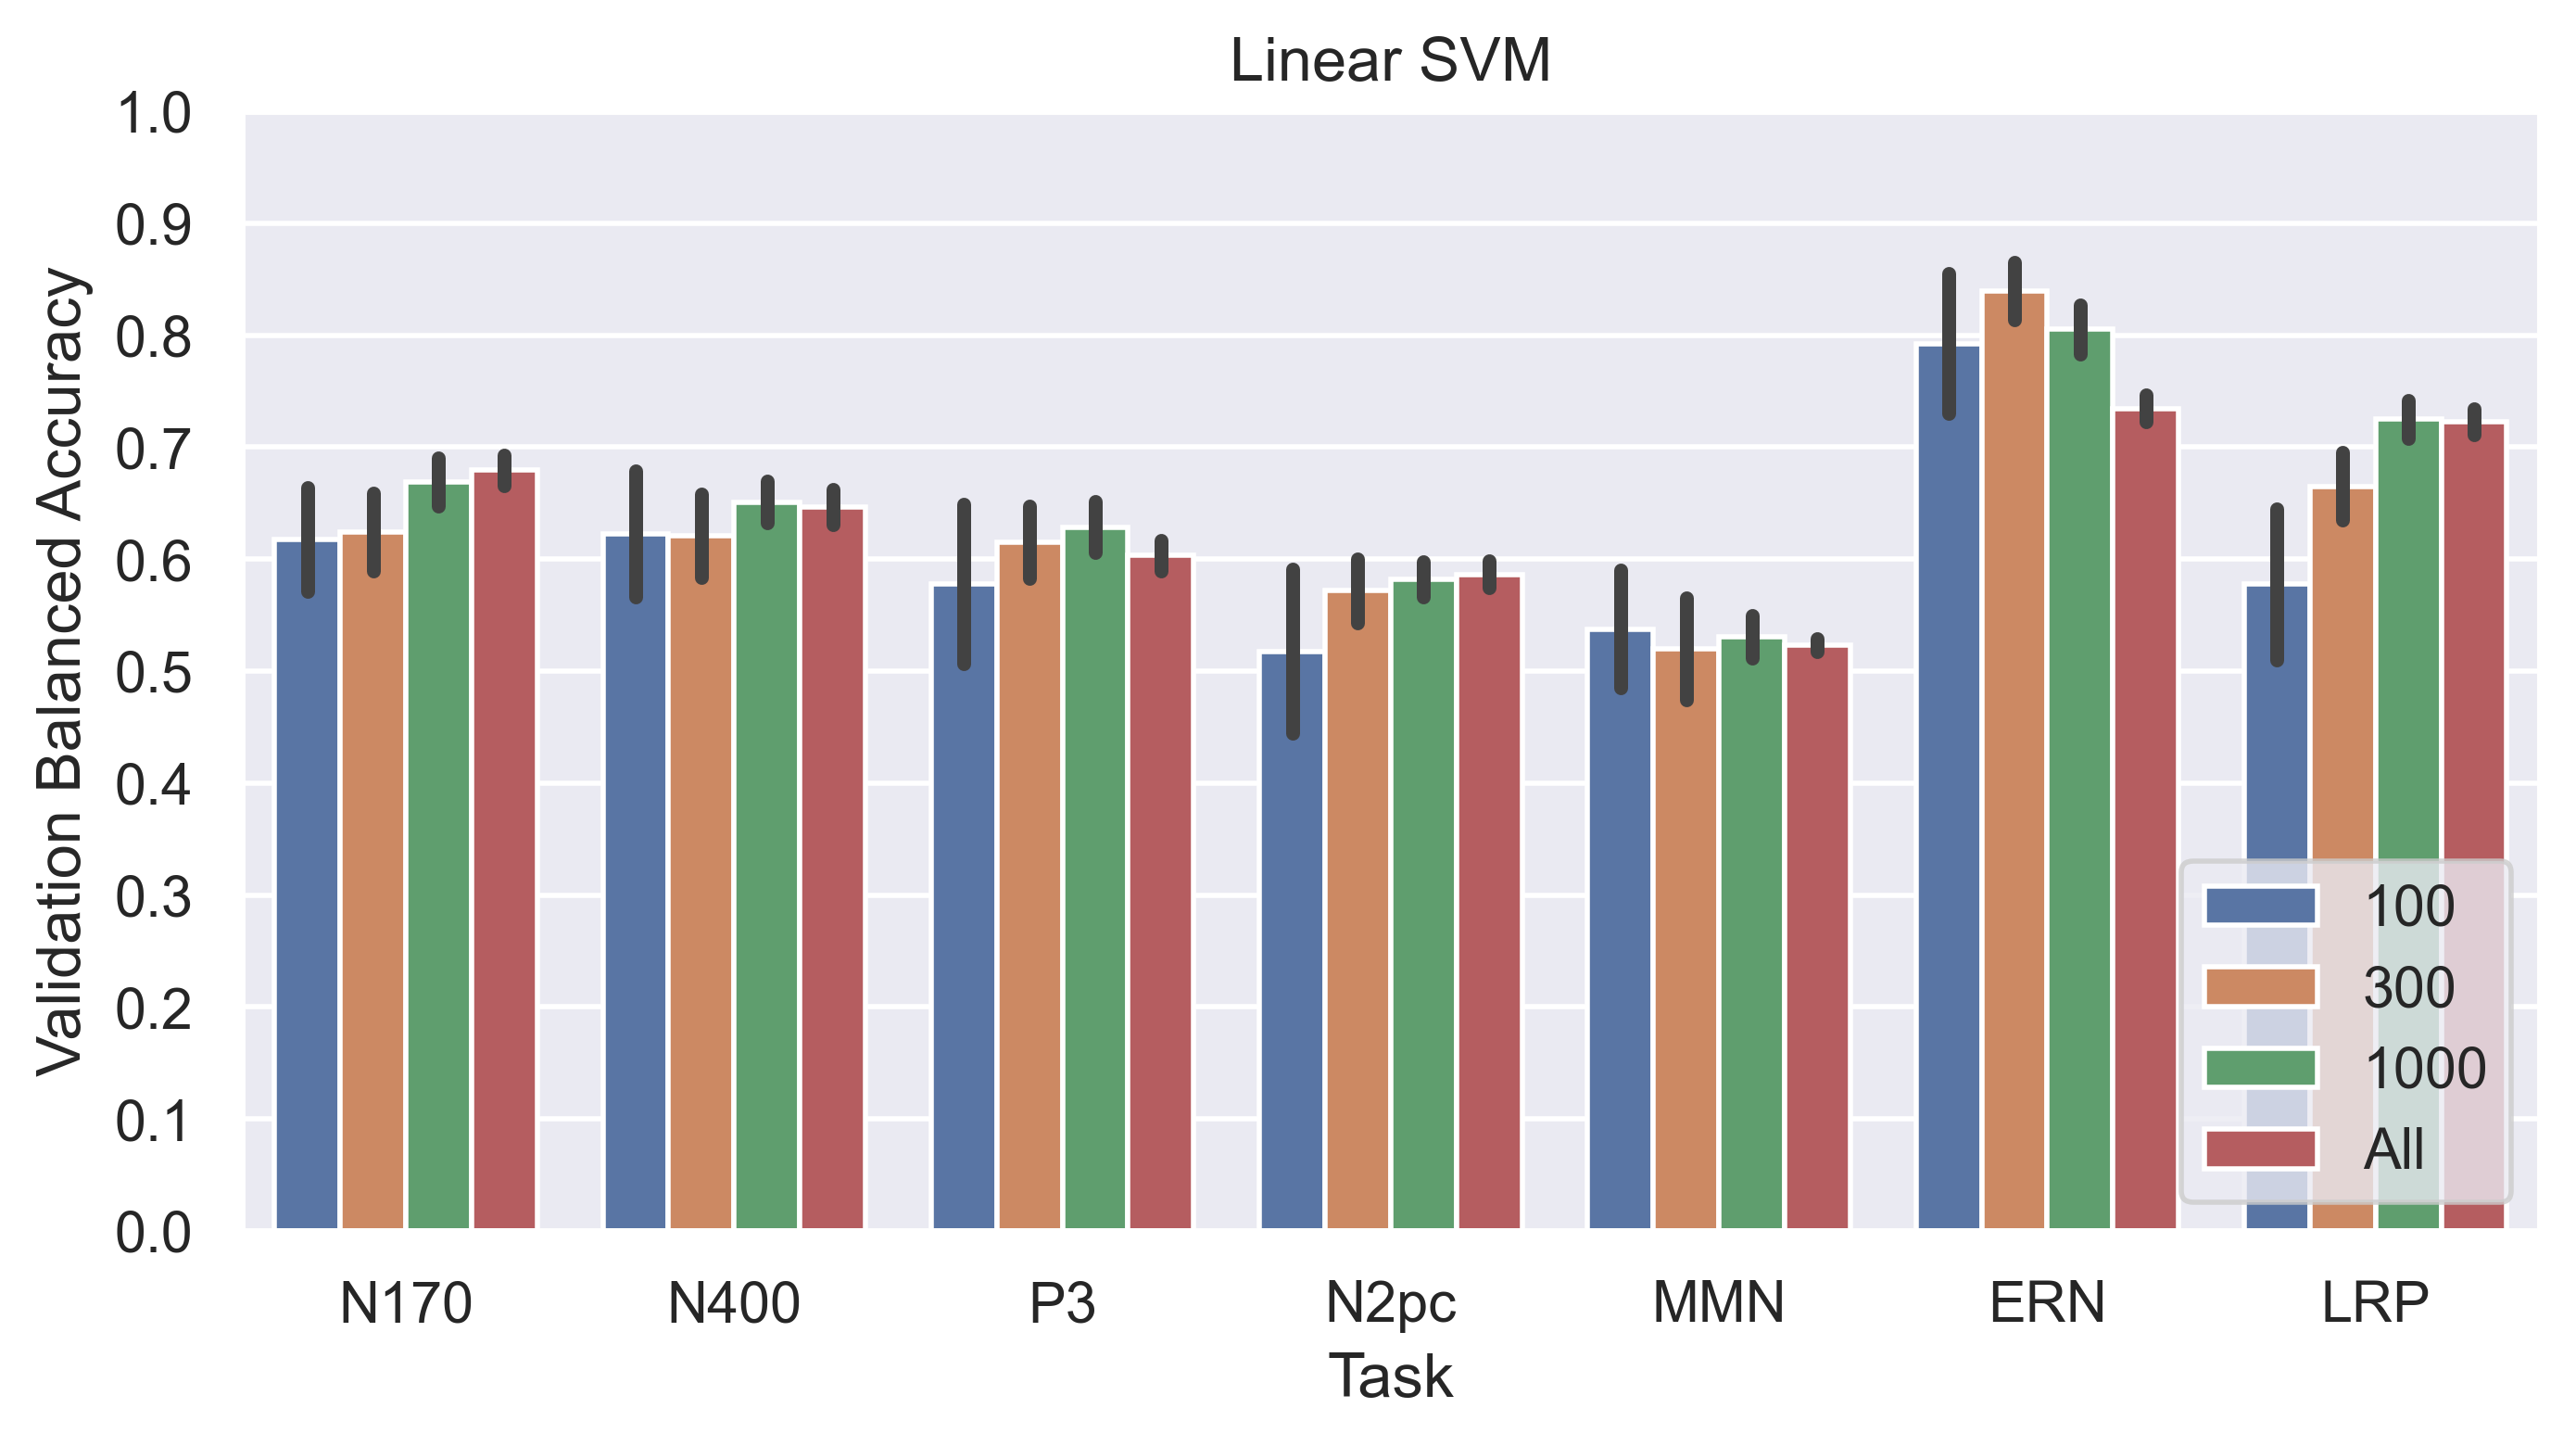

In [174]:
sns.set(style="darkgrid")
plt.figure(figsize=(8, 4), dpi=400)
plt.title("Linear SVM")
g = sns.barplot(x="Task", y="Validation Balanced Accuracy", 
            hue="Sample Count", 
            data=df_task[df_task["Model"]=="SVM"], ci="sd")
g.set_yticks(np.round(np.arange(0,1.1,0.1),1))
l = plt.legend(loc='lower right');

# Preprocessing

In [7]:
data_path = "F:/Masterthesis/Data/"
preprocessing = "heavy"
model_folder = "ModelComparison"
n_epochs = 25
n_splits = 10

for task in ["N170", "N400", "N2pc", "MMN", "ERN", "LRP"]:
    df = DataLoader.load_df(data_path, task, preprocessing)
    print(task,df.shape[0])

N170 5603
N400 3341
N2pc 9429
MMN 35733
ERN 13559
LRP 13985


In [8]:
data_path = "F:/Masterthesis/Data/"
preprocessing = "medium"
model_folder = "ModelComparison"
n_epochs = 25
n_splits = 10

for task in ["N170", "N400", "N2pc", "MMN", "ERN", "LRP"]:
    df = DataLoader.load_df(data_path, task, preprocessing)
    print(task,df.shape[0])

N170 5781
N400 3443
N2pc 10826
MMN 39232
ERN 16048
LRP 16048


In [3]:
data_path = "F:/Masterthesis/Data/"
preprocessing = "heavy"
model_folder = "ModelComparison"
n_epochs = 25
n_splits = 10

for model_name in ["shallow", "eegnet"]:
    if model_name == "eegnet":
        lr = 0.03
    else:
        lr = 0.01
    for task in ["N170", "N400", "N2pc", "MMN", "ERN", "LRP"]:
        df = DataLoader.load_df(data_path, task, preprocessing)
        data, labels = DataLoader.create_data_labels(df)
        Training.run_exp(data, labels, task, preprocessing, model_folder, model_name, 
                lr, n_epochs, n_splits, batch_size=64)

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 0 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.5300        0.9285                     0.5637        0.7274  0.0100  1.2508
      2                     0.5756        0.7516                     0.6347        0.6437  0.0100  0.5119
      3                     0.6256        0.7286                     0.5853        0.8584  0.0098  0.4935
      4                     0.6428        0.7049                     0.7023        0.5804  0.0096  0.4687
      5                     0.6347        0.7244                     0.6102        0.8121  0.0093  0.4795
      6                     0.6575        0.7141                     0.6906        0.5998  0.0090  0.4904
      7                     0.6796        0.6337              

      9                     0.6943        0.6141                     0.6816        0.5848  0.0075  0.4698
     10                     0.6890        0.6300                     0.7257        0.5548  0.0069  0.4686
     11                     0.7102        0.5859                     0.7065        0.5722  0.0063  0.4686
     12                     0.7221        0.5731                     0.6913        0.6263  0.0057  0.4688
     13                     0.7166        0.5924                     0.7342        0.5441  0.0050  0.4697
     14                     0.7289        0.5642                     0.7270        0.5231  0.0043  0.4693
     15                     0.7405        0.5294                     0.7362        0.5169  0.0037  0.4699
     16                     0.7497        0.5084                     0.7336        0.5198  0.0031  0.4698
     17                     0.7660        0.4966                     0.7450        0.5093  0.0025  0.4691
     18                     0.7635        0.49

     20                     0.7881        0.4654                     0.7527        0.5187  0.0010  0.4688
     21                     0.7894        0.4585                     0.7484        0.5134  0.0007  0.4698
     22                     0.7852        0.4600                     0.7510        0.5156  0.0004  0.4691
     23                     0.7968        0.4440                     0.7449        0.5145  0.0002  0.4693
     24                     0.7861        0.4585                     0.7483        0.5141  0.0000  0.4704
     25                     0.8017        0.4437                     0.7484        0.5134  0.0000  0.4696
Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.5294        0.9605              

      2                     0.5525        0.7992                     0.5610        0.7762  0.0100  0.4697
      3                     0.5921        0.7338                     0.6272        0.6529  0.0098  0.4714
      4                     0.6155        0.7552                     0.6356        0.6537  0.0096  0.4687
      5                     0.6709        0.6656                     0.6844        0.6062  0.0093  0.4700
      6                     0.6705        0.6477                     0.6948        0.5671  0.0090  0.4688
      7                     0.6756        0.6675                     0.7059        0.5661  0.0085  0.4677
      8                     0.6892        0.6154                     0.6733        0.6170  0.0080  0.4705
      9                     0.7024        0.5961                     0.6871        0.6141  0.0075  0.4700
     10                     0.7137        0.5742                     0.7422        0.5244  0.0069  0.4709
     11                     0.7218        0.56

     12                     0.7254        0.5647                     0.7018        0.5932  0.0057  0.4696
     13                     0.7371        0.5523                     0.7241        0.5582  0.0050  0.4710
     14                     0.7514        0.5230                     0.7308        0.5417  0.0043  0.4704
     15                     0.7548        0.5082                     0.7306        0.5308  0.0037  0.4700
     16                     0.7724        0.4847                     0.7320        0.5439  0.0031  0.4688
     17                     0.7561        0.4987                     0.7258        0.5498  0.0025  0.4707
     18                     0.7657        0.4876                     0.7348        0.5320  0.0020  0.4696
     19                     0.7760        0.4776                     0.7395        0.5200  0.0015  0.4699
     20                     0.7778        0.4672                     0.7379        0.5244  0.0010  0.4707
     21                     0.7829        0.46

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 1 1 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.6140        0.8719                     0.6624        0.6213  0.0100  0.6896
      2                     0.6715        0.6865                     0.6701        0.6626  0.0100  0.2803
      3                     0.6838        0.6888                     0.7087        0.5710  0.0098  0.2802
      4                     0.6975        0.6142                     0.7215        0.5550  0.0096  0.2793
      5                     0.7255        0.5786                     0.6560        0.7069  0.0093  0.2837
      6                     0.7238        0.5769                     0.6988        0.5845  0.0090  0.2822
      7                     0.7423        0.5479              

     10                     0.7745        0.4844                     0.7110        0.5541  0.0069  0.2813
     11                     0.7675        0.4967                     0.7354        0.5266  0.0063  0.2790
     12                     0.7785        0.4761                     0.7203        0.5700  0.0057  0.2808
     13                     0.7776        0.4624                     0.7282        0.5642  0.0050  0.2793
     14                     0.7968        0.4443                     0.7457        0.5889  0.0043  0.2815
     15                     0.8043        0.4373                     0.7410        0.5670  0.0037  0.2805
     16                     0.8082        0.4089                     0.7273        0.5597  0.0031  0.2812
     17                     0.8149        0.3978                     0.7282        0.5631  0.0025  0.2783
     18                     0.8309        0.3784                     0.7381        0.5551  0.0020  0.2812
     19                     0.8294        0.37

     22                     0.8501        0.3410                     0.7565        0.5421  0.0004  0.2793
     23                     0.8530        0.3402                     0.7532        0.5425  0.0002  0.2806
     24                     0.8470        0.3483                     0.7535        0.5430  0.0000  0.2793
     25                     0.8526        0.3314                     0.7535        0.5432  0.0000  0.2793
Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.6097        0.8640                     0.7173        0.5688  0.0100  0.2733
      2                     0.6561        0.6883                     0.7149        0.6023  0.0100  0.2812
      3                     0.6842        0.6435              

      6                     0.7170        0.5762                     0.7215        0.5296  0.0090  0.2813
      7                     0.7147        0.5927                     0.7431        0.5364  0.0085  0.2806
      8                     0.7356        0.5432                     0.7477        0.5310  0.0080  0.2793
      9                     0.7493        0.5385                     0.7406        0.5280  0.0075  0.2802
     10                     0.7521        0.5288                     0.7618        0.5048  0.0069  0.2783
     11                     0.7505        0.5168                     0.7700        0.5138  0.0063  0.2802
     12                     0.7720        0.4869                     0.7683        0.4907  0.0057  0.2782
     13                     0.7755        0.4731                     0.7635        0.4934  0.0050  0.2819
     14                     0.7859        0.4535                     0.7491        0.5646  0.0043  0.2798
     15                     0.7957        0.44

     17                     0.8092        0.4175                     0.7354        0.5316  0.0025  0.2814
     18                     0.8247        0.3906                     0.7361        0.5344  0.0020  0.2793
     19                     0.8322        0.3753                     0.7333        0.5266  0.0015  0.2815
     20                     0.8319        0.3788                     0.7365        0.5390  0.0010  0.2812
     21                     0.8498        0.3602                     0.7409        0.5307  0.0007  0.2792
     22                     0.8348        0.3818                     0.7376        0.5230  0.0004  0.2823
     23                     0.8398        0.3592                     0.7426        0.5250  0.0002  0.2793
     24                     0.8441        0.3608                     0.7402        0.5255  0.0000  0.2803
     25                     0.8463        0.3530                     0.7427        0.5244  0.0000  0.2803


C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 0 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.5100        1.0044                     0.5377        0.7086  0.0100  1.2458
      2                     0.5351        0.7674                     0.5789        0.7372  0.0100  0.7869
      3                     0.5629        0.7632                     0.5841        0.7060  0.0098  0.7855
      4                     0.5877        0.7275                     0.5782        0.7333  0.0096  0.7872
      5                     0.5997        0.7311                     0.5984        0.6603  0.0093  0.7866
      6                     0.6045        0.7102                     0.6435        0.6366  0.0090  0.7878
      7                     0.6058        0.6897              

      8                     0.6189        0.6796                     0.6483        0.6444  0.0080  0.7902
      9                     0.6272        0.6681                     0.6304        0.6644  0.0075  0.7924
     10                     0.6360        0.6589                     0.6191        0.6840  0.0069  0.7873
     11                     0.6430        0.6538                     0.6438        0.6277  0.0063  0.7867
     12                     0.6588        0.6346                     0.6461        0.6331  0.0057  0.7858
     13                     0.6579        0.6331                     0.6525        0.6345  0.0050  0.7891
     14                     0.6541        0.6263                     0.6564        0.6282  0.0043  0.7867
     15                     0.6713        0.6178                     0.6401        0.6417  0.0037  0.7890
     16                     0.6698        0.6140                     0.6665        0.6271  0.0031  0.7889
     17                     0.6705        0.61

     18                     0.6752        0.5973                     0.6686        0.6145  0.0020  0.7893
     19                     0.6827        0.5995                     0.6740        0.6088  0.0015  0.7858
     20                     0.6930        0.5876                     0.6733        0.6073  0.0010  0.7866
     21                     0.6933        0.5840                     0.6701        0.6083  0.0007  0.7861
     22                     0.6862        0.5847                     0.6686        0.6061  0.0004  0.7871
     23                     0.6967        0.5795                     0.6686        0.6060  0.0002  0.7865
     24                     0.6949        0.5807                     0.6707        0.6062  0.0000  0.7894
     25                     0.6923        0.5793                     0.6702        0.6064  0.0000  0.7879
Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_bala

      2                     0.5191        0.8110                     0.5553        0.7660  0.0100  0.7877
      3                     0.5635        0.7536                     0.5858        0.6650  0.0098  0.7864
      4                     0.5836        0.7410                     0.5956        0.7110  0.0096  0.7868
      5                     0.6018        0.7024                     0.6167        0.6691  0.0093  0.7860
      6                     0.6113        0.7031                     0.6071        0.6778  0.0090  0.7882
      7                     0.6153        0.6842                     0.6438        0.6275  0.0085  0.7860
      8                     0.6179        0.6775                     0.6376        0.6257  0.0080  0.7873
      9                     0.6256        0.6661                     0.6380        0.6388  0.0075  0.7868
     10                     0.6353        0.6519                     0.6415        0.6296  0.0069  0.7876
     11                     0.6419        0.64

     11                     0.6461        0.6403                     0.6350        0.6397  0.0063  0.7872
     12                     0.6503        0.6386                     0.6490        0.6371  0.0057  0.7863
     13                     0.6501        0.6331                     0.6568        0.6280  0.0050  0.7885
     14                     0.6608        0.6237                     0.6486        0.6205  0.0043  0.7868
     15                     0.6627        0.6177                     0.6588        0.6169  0.0037  0.7865
     16                     0.6773        0.6099                     0.6542        0.6371  0.0031  0.7880
     17                     0.6747        0.6097                     0.6564        0.6171  0.0025  0.7880
     18                     0.6815        0.5982                     0.6548        0.6198  0.0020  0.7844
     19                     0.6818        0.5950                     0.6526        0.6196  0.0015  0.7888
     20                     0.6874        0.58

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 0 0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.5066        0.8882                     0.5149        0.7288  0.0100  3.3870
      2                     0.5157        0.7784                     0.5150        0.7191  0.0100  2.9825
      3                     0.5291        0.7209                     0.5608        0.6808  0.0098  2.9821
      4                     0.5438        0.7014                     0.5836        0.6768  0.0096  2.9794
      5                     0.5503        0.6920                     0.5799        0.6793  0.0093  2.9760
      6                     0.5540        0.6894                     0.5610        0.6838  0.0090  2.9757
      7                     0.5548        0.6880              

      8                     0.5587        0.6858                     0.5732        0.6798  0.0080  2.9841
      9                     0.5546        0.6873                     0.5724        0.6779  0.0075  2.9814
     10                     0.5669        0.6836                     0.5666        0.6810  0.0069  2.9859
     11                     0.5592        0.6851                     0.5809        0.6762  0.0063  2.9850
     12                     0.5688        0.6825                     0.5828        0.6762  0.0057  2.9792
     13                     0.5687        0.6823                     0.5771        0.6774  0.0050  2.9814
     14                     0.5711        0.6798                     0.5833        0.6755  0.0043  2.9822
     15                     0.5757        0.6781                     0.5763        0.6760  0.0037  2.9836
     16                     0.5782        0.6764                     0.5831        0.6754  0.0031  2.9969
     17                     0.5754        0.67

     17                     0.5824        0.6756                     0.5755        0.6774  0.0025  2.9912
     18                     0.5800        0.6748                     0.5812        0.6769  0.0020  2.9936
     19                     0.5871        0.6729                     0.5807        0.6761  0.0015  2.9986
     20                     0.5849        0.6723                     0.5876        0.6744  0.0010  2.9909
     21                     0.5924        0.6703                     0.5838        0.6742  0.0007  2.9893
     22                     0.5922        0.6694                     0.5837        0.6748  0.0004  2.9952
     23                     0.5912        0.6690                     0.5828        0.6745  0.0002  2.9899
     24                     0.5981        0.6679                     0.5835        0.6744  0.0000  2.9923
     25                     0.5962        0.6686                     0.5839        0.6744  0.0000  2.9958
Re-initializing optimizer because the followin

      2                     0.5105        0.7708                     0.5318        0.6976  0.0100  2.9547
      3                     0.5252        0.7228                     0.5442        0.6892  0.0098  2.9539
      4                     0.5415        0.7017                     0.5402        0.6945  0.0096  2.9540
      5                     0.5556        0.6908                     0.5616        0.6822  0.0093  2.9538
      6                     0.5541        0.6893                     0.5485        0.6828  0.0090  2.9522
      7                     0.5553        0.6862                     0.5736        0.6786  0.0085  2.9521
      8                     0.5544        0.6882                     0.5705        0.6799  0.0080  2.9601
      9                     0.5552        0.6876                     0.5719        0.6785  0.0075  2.9575
     10                     0.5558        0.6870                     0.5807        0.6768  0.0069  2.9515
     11                     0.5611        0.68

     12                     0.5715        0.6811                     0.5671        0.6828  0.0057  2.9562
     13                     0.5716        0.6816                     0.5706        0.6828  0.0050  2.9587
     14                     0.5734        0.6788                     0.5619        0.6833  0.0043  2.9549
     15                     0.5807        0.6768                     0.5652        0.6848  0.0037  2.9537
     16                     0.5797        0.6764                     0.5743        0.6810  0.0031  2.9542
     17                     0.5832        0.6739                     0.5761        0.6820  0.0025  2.9591
     18                     0.5825        0.6735                     0.5727        0.6806  0.0020  2.9565
     19                     0.5903        0.6716                     0.5745        0.6803  0.0015  2.9556
     20                     0.5924        0.6704                     0.5747        0.6804  0.0010  2.9570
     21                     0.5909        0.67

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[1 1 0 ... 0 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.7184        0.7479                     0.8310        0.3989  0.0100  1.4013
      2                     0.7764        0.5424                     0.8446        0.4079  0.0100  1.1198
      3                     0.8234        0.4666                     0.8212        0.4412  0.0098  1.1226
      4                     0.8258        0.4448                     0.8744        0.3291  0.0096  1.1196
      5                     0.8386        0.4070                     0.8797        0.3260  0.0093  1.1202
      6                     0.8407        0.4165                     0.8670        0.3445  0.0090  1.1205
      7                     0.8495        0.3879              

      8                     0.8544        0.3659                     0.8635        0.3618  0.0080  1.1243
      9                     0.8546        0.3503                     0.8432        0.4266  0.0075  1.1229
     10                     0.8683        0.3403                     0.8677        0.3670  0.0069  1.1245
     11                     0.8764        0.3120                     0.8660        0.3375  0.0063  1.1219
     12                     0.8764        0.3042                     0.8754        0.3453  0.0057  1.1232
     13                     0.8802        0.3007                     0.8770        0.3230  0.0050  1.1225
     14                     0.8921        0.2790                     0.8903        0.3235  0.0043  1.1220
     15                     0.8882        0.2738                     0.8759        0.3157  0.0037  1.1239
     16                     0.9026        0.2629                     0.8805        0.3078  0.0031  1.1245
     17                     0.8991        0.26

     17                     0.8996        0.2527                     0.8894        0.3051  0.0025  1.1236
     18                     0.9035        0.2520                     0.8957        0.2659  0.0020  1.1258
     19                     0.9105        0.2420                     0.8901        0.2640  0.0015  1.1566
     20                     0.9098        0.2437                     0.8959        0.2640  0.0010  1.1255
     21                     0.9166        0.2209                     0.8939        0.2633  0.0007  1.1244
     22                     0.9147        0.2205                     0.8883        0.2631  0.0004  1.1260
     23                     0.9124        0.2199                     0.8913        0.2595  0.0002  1.1230
     24                     0.9164        0.2192                     0.8900        0.2589  0.0000  1.1243
     25                     0.9155        0.2229                     0.8913        0.2597  0.0000  1.1243
Re-initializing optimizer because the followin

      2                     0.7744        0.5956                     0.8494        0.3611  0.0100  1.1210
      3                     0.8120        0.4625                     0.7935        0.5176  0.0098  1.1214
      4                     0.8184        0.4667                     0.8562        0.3439  0.0096  1.1209
      5                     0.8257        0.4346                     0.8578        0.3144  0.0093  1.1227
      6                     0.8388        0.4088                     0.8788        0.2861  0.0090  1.1218
      7                     0.8507        0.3742                     0.8461        0.3412  0.0085  1.1230
      8                     0.8552        0.3701                     0.8705        0.3189  0.0080  1.1201
      9                     0.8547        0.3717                     0.8819        0.2947  0.0075  1.1230
     10                     0.8719        0.3337                     0.8821        0.2877  0.0069  1.1227
     11                     0.8783        0.31

     11                     0.8751        0.3186                     0.8560        0.3407  0.0063  1.1214
     12                     0.8797        0.3048                     0.8648        0.3329  0.0057  1.1231
     13                     0.8912        0.2852                     0.8548        0.3168  0.0050  1.1273
     14                     0.8858        0.2786                     0.8716        0.3120  0.0043  1.1234
     15                     0.8900        0.2757                     0.8584        0.3128  0.0037  1.1221
     16                     0.8944        0.2653                     0.8633        0.3202  0.0031  1.1218
     17                     0.8987        0.2527                     0.8743        0.3012  0.0025  1.1220
     18                     0.9107        0.2431                     0.8537        0.3534  0.0020  1.1227
     19                     0.8969        0.2461                     0.8855        0.2953  0.0015  1.1242
     20                     0.9087        0.23

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[1 0 0 ... 0 0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.5374        0.8619                     0.6189        0.6552  0.0100  1.6361
      2                     0.6192        0.6950                     0.6656        0.6244  0.0100  1.1561
      3                     0.6464        0.6684                     0.7014        0.5690  0.0098  1.1558
      4                     0.6737        0.6374                     0.6938        0.5952  0.0096  1.1559
      5                     0.6787        0.6372                     0.7298        0.5232  0.0093  1.1561
      6                     0.6988        0.5894                     0.7463        0.5122  0.0090  1.1555
      7                     0.7145        0.5687              

      6                     0.7024        0.5911                     0.7098        0.5521  0.0090  1.1580
      7                     0.7100        0.5792                     0.7230        0.5369  0.0085  1.1565
      8                     0.7209        0.5588                     0.7572        0.4998  0.0080  1.1545
      9                     0.7318        0.5494                     0.7603        0.5000  0.0075  1.1576
     10                     0.7392        0.5367                     0.7568        0.4978  0.0069  1.1576
     11                     0.7430        0.5283                     0.7369        0.5264  0.0063  1.1573
     12                     0.7402        0.5237                     0.7635        0.4961  0.0057  1.1560
     13                     0.7515        0.5134                     0.7469        0.5151  0.0050  1.1583
     14                     0.7528        0.5081                     0.7665        0.4891  0.0043  1.1586
     15                     0.7595        0.50

     13                     0.7554        0.5047                     0.7649        0.4829  0.0050  1.1599
     14                     0.7626        0.5000                     0.7684        0.4894  0.0043  1.1589
     15                     0.7615        0.4901                     0.7601        0.4873  0.0037  1.1612
     16                     0.7680        0.4872                     0.7680        0.4850  0.0031  1.1606
     17                     0.7723        0.4793                     0.7732        0.4759  0.0025  1.1615
     18                     0.7656        0.4768                     0.7745        0.4699  0.0020  1.1607
     19                     0.7799        0.4676                     0.7760        0.4687  0.0015  1.1592
     20                     0.7761        0.4665                     0.7773        0.4664  0.0010  1.1615
     21                     0.7806        0.4640                     0.7816        0.4649  0.0007  1.1595
     22                     0.7837        0.45

     20                     0.7773        0.4673                     0.7843        0.4674  0.0010  1.1601
     21                     0.7835        0.4625                     0.7836        0.4660  0.0007  1.1607
     22                     0.7792        0.4628                     0.7866        0.4654  0.0004  1.1618
     23                     0.7847        0.4643                     0.7851        0.4652  0.0002  1.1637
     24                     0.7834        0.4586                     0.7869        0.4645  0.0000  1.1608
     25                     0.7842        0.4571                     0.7858        0.4647  0.0000  1.1618
Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.5521        0.8422              

      2                     0.6136        0.7133                     0.6922        0.5813  0.0100  1.1586
      3                     0.6508        0.6699                     0.7093        0.5704  0.0098  1.1583
      4                     0.6704        0.6518                     0.7262        0.5473  0.0096  1.1609
      5                     0.6964        0.5980                     0.7369        0.5207  0.0093  1.1577
      6                     0.7148        0.5715                     0.7364        0.5237  0.0090  1.1584
      7                     0.7241        0.5656                     0.7482        0.5070  0.0085  1.1578
      8                     0.7227        0.5565                     0.7570        0.5098  0.0080  1.1585
      9                     0.7355        0.5391                     0.7533        0.5047  0.0075  1.1576
     10                     0.7360        0.5390                     0.7609        0.4985  0.0069  1.1601
     11                     0.7502        0.51

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 0 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.5565        0.7261                     0.6089        0.7640  0.0300  1.5112
      2                     0.6428        0.6345                     0.7252        0.5589  0.0299  1.4526
      3                     0.6759        0.6074                     0.7218        0.5571  0.0295  1.4521
      4                     0.6858        0.5929                     0.7264        0.5790  0.0289  1.4522
      5                     0.7048        0.5741                     0.6711        0.6066  0.0280  1.4525
      6                     0.6967        0.5838                     0.7334        0.5418  0.0269  1.4527
      7                     0.7214        0.5582              

      8                     0.7134        0.5608                     0.7136        0.5689  0.0241  1.4527
      9                     0.7261        0.5435                     0.7179        0.5620  0.0225  1.4529
     10                     0.7061        0.5703                     0.7144        0.5509  0.0207  1.4548
     11                     0.7332        0.5403                     0.7055        0.5729  0.0189  1.4520
     12                     0.7231        0.5501                     0.7392        0.5354  0.0170  1.4531
     13                     0.7498        0.5138                     0.7441        0.5287  0.0150  1.4519
     14                     0.7484        0.5117                     0.7411        0.5091  0.0130  1.4530
     15                     0.7494        0.5087                     0.7358        0.5140  0.0111  1.4514
     16                     0.7725        0.4912                     0.7557        0.5020  0.0093  1.4531
     17                     0.7759        0.47

     19                     0.7853        0.4548                     0.7769        0.4933  0.0044  1.4722
     20                     0.7888        0.4526                     0.7636        0.4845  0.0031  1.4706
     21                     0.7979        0.4450                     0.7653        0.4818  0.0020  1.4706
     22                     0.7974        0.4439                     0.7653        0.4823  0.0011  1.4712
     23                     0.8017        0.4367                     0.7654        0.4790  0.0005  1.4713
     24                     0.7977        0.4363                     0.7681        0.4784  0.0001  1.4713
     25                     0.7966        0.4353                     0.7699        0.4784  0.0000  1.4726
Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  ------------

      2                     0.6599        0.6198                     0.6739        0.6523  0.0299  1.4716
      3                     0.6817        0.5962                     0.7048        0.5681  0.0295  1.4707
      4                     0.6940        0.5853                     0.6918        0.5812  0.0289  1.4713
      5                     0.6903        0.5924                     0.6969        0.5785  0.0280  1.4715
      6                     0.6961        0.5845                     0.7004        0.5591  0.0269  1.4711
      7                     0.7052        0.5737                     0.7180        0.5569  0.0256  1.4716
      8                     0.7228        0.5563                     0.7237        0.5488  0.0241  1.4701
      9                     0.7156        0.5547                     0.7295        0.5432  0.0225  1.4700
     10                     0.7072        0.5733                     0.7423        0.5314  0.0207  1.4677
     11                     0.7326        0.53

     11                     0.7374        0.5261                     0.7575        0.5333  0.0189  1.4706
     12                     0.7421        0.5181                     0.7470        0.5272  0.0170  1.4715
     13                     0.7489        0.5124                     0.7556        0.5278  0.0150  1.4694
     14                     0.7529        0.5155                     0.7421        0.5208  0.0130  1.4725
     15                     0.7649        0.4911                     0.7463        0.5135  0.0111  1.4705
     16                     0.7535        0.5021                     0.7542        0.5140  0.0093  1.4713
     17                     0.7766        0.4802                     0.7546        0.5028  0.0075  1.4696
     18                     0.7700        0.4909                     0.7613        0.5077  0.0059  1.4719
     19                     0.7798        0.4653                     0.7736        0.4874  0.0044  1.4719
     20                     0.7835        0.45

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 1 1 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.6731        0.6409                     0.7182        1.0283  0.0300  0.9176
      2                     0.7276        0.5321                     0.7277        0.6454  0.0299  0.8765
      3                     0.7396        0.5291                     0.7101        0.5979  0.0295  0.8747
      4                     0.7221        0.5425                     0.7386        0.5429  0.0289  0.8769
      5                     0.7507        0.5146                     0.7293        0.5248  0.0280  0.8747
      6                     0.7491        0.4986                     0.7147        0.5800  0.0269  0.8751
      7                     0.7444        0.5119              

     11                     0.7596        0.4875                     0.5835        0.7988  0.0189  0.8738
     12                     0.7623        0.4823                     0.6780        0.6245  0.0170  0.8756
     13                     0.7638        0.4743                     0.5988        0.8031  0.0150  0.8736
     14                     0.7693        0.4748                     0.6473        0.9168  0.0130  0.8768
     15                     0.7668        0.4718                     0.5283        1.3862  0.0111  0.8766
     16                     0.7840        0.4597                     0.7316        0.5158  0.0093  0.8737
     17                     0.7893        0.4559                     0.7480        0.5037  0.0075  0.8766
     18                     0.7866        0.4447                     0.7569        0.4896  0.0059  0.8758
     19                     0.7864        0.4463                     0.7601        0.4909  0.0044  0.8748
     20                     0.8074        0.42

     24                     0.7913        0.4270                     0.7466        0.5135  0.0001  0.8741
     25                     0.7879        0.4313                     0.7450        0.5143  0.0000  0.8751
Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.6720        0.6457                     0.6842        0.9210  0.0300  0.8735
      2                     0.7093        0.5603                     0.7370        0.6503  0.0299  0.8727
      3                     0.7101        0.5628                     0.7454        0.5195  0.0295  0.8736
      4                     0.7316        0.5320                     0.7295        0.5409  0.0289  0.8744
      5                     0.7353        0.5265              

      9                     0.7470        0.5121                     0.7450        0.5366  0.0225  0.8735
     10                     0.7460        0.5068                     0.7211        0.5710  0.0207  0.8731
     11                     0.7600        0.4883                     0.7444        0.5432  0.0189  0.8734
     12                     0.7622        0.4902                     0.7478        0.5001  0.0170  0.8719
     13                     0.7694        0.4826                     0.7399        0.5341  0.0150  0.8746
     14                     0.7580        0.4873                     0.7107        0.5862  0.0130  0.8754
     15                     0.7682        0.4758                     0.7350        0.5396  0.0111  0.8737
     16                     0.7808        0.4620                     0.7378        0.5394  0.0093  0.8760
     17                     0.7777        0.4604                     0.7518        0.4965  0.0075  0.8804
     18                     0.7864        0.45

     21                     0.7987        0.4232                     0.7087        0.5587  0.0020  0.8816
     22                     0.7998        0.4238                     0.7574        0.4936  0.0011  0.8826
     23                     0.8033        0.4190                     0.7469        0.5449  0.0005  0.8786
     24                     0.8181        0.4050                     0.7619        0.5207  0.0001  0.8837
     25                     0.8099        0.4095                     0.7746        0.5068  0.0000  0.8806


C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 0 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.5613        0.7161                     0.6291        0.6550  0.0300  2.5233
      2                     0.6157        0.6572                     0.5409        0.7014  0.0299  2.4833
      3                     0.6280        0.6489                     0.5966        0.6726  0.0295  2.4895
      4                     0.6248        0.6532                     0.5786        0.6654  0.0289  2.4854
      5                     0.6337        0.6452                     0.5832        0.6848  0.0280  2.4686
      6                     0.6325        0.6453                     0.6355        0.6498  0.0269  2.4652
      7                     0.6371        0.6373              

     10                     0.6461        0.6338                     0.5189        0.7255  0.0207  2.4877
     11                     0.6452        0.6345                     0.6330        0.6376  0.0189  2.4974
     12                     0.6482        0.6306                     0.5835        0.6702  0.0170  2.4963
     13                     0.6512        0.6302                     0.5870        0.6679  0.0150  2.4933
     14                     0.6590        0.6279                     0.5881        0.6708  0.0130  2.4804
     15                     0.6631        0.6174                     0.6256        0.6440  0.0111  2.4664
     16                     0.6567        0.6195                     0.5956        0.6667  0.0093  2.4674
     17                     0.6619        0.6131                     0.6611        0.6273  0.0075  2.4704
     18                     0.6749        0.6056                     0.6650        0.6311  0.0059  2.4694
     19                     0.6786        0.60

     21                     0.6734        0.5983                     0.6554        0.6228  0.0020  2.4692
     22                     0.6842        0.5977                     0.6582        0.6206  0.0011  2.4655
     23                     0.6813        0.5940                     0.6613        0.6232  0.0005  2.4686
     24                     0.6839        0.5924                     0.6586        0.6211  0.0001  2.4685
     25                     0.6839        0.5930                     0.6581        0.6210  0.0000  2.4688
Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.5612        0.7235                     0.5681        0.7177  0.0300  2.4658
      2                     0.6107        0.6621              

      4                     0.6229        0.6514                     0.6165        0.6511  0.0289  2.4694
      5                     0.6202        0.6523                     0.5910        0.7210  0.0280  2.4666
      6                     0.6307        0.6475                     0.6256        0.6450  0.0269  2.4714
      7                     0.6379        0.6406                     0.6059        0.6747  0.0256  2.4694
      8                     0.6367        0.6408                     0.5073        0.7293  0.0241  2.4672
      9                     0.6373        0.6425                     0.5736        0.6720  0.0225  2.4699
     10                     0.6416        0.6354                     0.5466        0.7031  0.0207  2.4684
     11                     0.6455        0.6304                     0.6346        0.6386  0.0189  2.4665
     12                     0.6528        0.6290                     0.6373        0.6386  0.0170  2.4701
     13                     0.6481        0.63

     16                     0.6624        0.6196                     0.6650        0.6213  0.0093  2.4402
     17                     0.6699        0.6099                     0.6412        0.6407  0.0075  2.4400
     18                     0.6632        0.6137                     0.6653        0.6187  0.0059  2.4395
     19                     0.6704        0.6091                     0.6601        0.6300  0.0044  2.4404
     20                     0.6766        0.6027                     0.6523        0.6363  0.0031  2.4399
     21                     0.6774        0.6006                     0.6648        0.6150  0.0020  2.4404
     22                     0.6827        0.5969                     0.6708        0.6176  0.0011  2.4409
     23                     0.6838        0.5951                     0.6696        0.6163  0.0005  2.4416
     24                     0.6817        0.5922                     0.6625        0.6111  0.0001  2.4400
     25                     0.6894        0.59

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 0 0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.5241        0.7110                     0.5477        0.6894  0.0300  9.2495
      2                     0.5541        0.6877                     0.5349        0.6935  0.0299  9.1926
      3                     0.5559        0.6871                     0.5625        0.6822  0.0295  9.2074
      4                     0.5575        0.6866                     0.5483        0.6890  0.0289  9.2092
      5                     0.5587        0.6863                     0.5001        0.6978  0.0280  9.2213
      6                     0.5483        0.6906                     0.5794        0.6797  0.0269  9.2417
      7                     0.5521        0.6885              

     10                     0.5660        0.6827                     0.5727        0.6783  0.0207  9.2385
     11                     0.5666        0.6803                     0.5728        0.6794  0.0189  9.2386
     12                     0.5719        0.6801                     0.5245        0.6903  0.0170  9.2365
     13                     0.5723        0.6790                     0.5151        0.6941  0.0150  9.2384
     14                     0.5774        0.6774                     0.5564        0.6835  0.0130  9.2387
     15                     0.5854        0.6753                     0.4998        0.7137  0.0111  9.2383
     16                     0.5832        0.6737                     0.5404        0.6877  0.0093  9.4739
     17                     0.5905        0.6713                     0.5008        0.8675  0.0075  9.3580
     18                     0.5946        0.6696                     0.4988        0.7506  0.0059  10.0058
     19                     0.5982        0.6

     22                     0.6039        0.6624                     0.5966        0.6677  0.0011  11.1351
     23                     0.6059        0.6616                     0.5968        0.6702  0.0005  10.6018
     24                     0.6097        0.6605                     0.5991        0.6638  0.0001  10.7540
     25                     0.6095        0.6607                     0.6018        0.6635  0.0000  10.7857
Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr      dur
-------  -------------------------  ------------  -------------------------  ------------  ------  -------
      1                     0.5318        0.7077                     0.5736        0.6865  0.0300  10.3080
      2                     0.5551        0.6872                     0.5513        0.6905  0.0299  9.4261
      3                     0.5474        0.6903       

      5                     0.5527        0.6886                     0.5727        0.6806  0.0280  11.7258
      6                     0.5565        0.6858                     0.5089        0.6949  0.0269  11.6846
      7                     0.5568        0.6877                     0.5092        0.7060  0.0256  11.6714
      8                     0.5529        0.6878                     0.5530        0.6862  0.0241  11.6494
      9                     0.5622        0.6853                     0.5250        0.6919  0.0225  11.7818
     10                     0.5626        0.6827                     0.5000        1.1275  0.0207  11.8579
     11                     0.5621        0.6833                     0.5003        0.7167  0.0189  11.8343
     12                     0.5719        0.6803                     0.5026        0.7231  0.0170  11.6253
     13                     0.5758        0.6790                     0.5838        0.6743  0.0150  11.5368
     14                     0.5759   

     17                     0.5922        0.6691                     0.5550        0.6839  0.0075  9.3494
     18                     0.5936        0.6686                     0.5649        0.6863  0.0059  9.3477
     19                     0.5967        0.6668                     0.5523        0.6877  0.0044  9.3478
     20                     0.6020        0.6637                     0.5677        0.6842  0.0031  9.3518
     21                     0.6039        0.6613                     0.5784        0.6833  0.0020  9.3479
     22                     0.6072        0.6600                     0.5219        0.7105  0.0011  9.3441
     23                     0.6083        0.6578                     0.5818        0.6770  0.0005  9.3420
     24                     0.6125        0.6575                     0.5842        0.6732  0.0001  9.3462
     25                     0.6095        0.6585                     0.5853        0.6733  0.0000  9.3481


C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[1 1 0 ... 0 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.8059        0.4496                     0.8179        0.4362  0.0300  3.5863
      2                     0.8391        0.3885                     0.8330        0.3812  0.0299  3.5473
      3                     0.8422        0.3749                     0.7111        0.7539  0.0295  3.5459
      4                     0.8469        0.3633                     0.8059        0.4630  0.0289  3.5463
      5                     0.8498        0.3642                     0.7908        0.4616  0.0280  3.5465
      6                     0.8497        0.3590                     0.7612        0.4745  0.0269  3.5490
      7                     0.8568        0.3559              

     10                     0.8683        0.3169                     0.7778        0.4632  0.0207  3.5509
     11                     0.8687        0.3178                     0.6663        0.7107  0.0189  3.5491
     12                     0.8609        0.3306                     0.6942        0.6543  0.0170  3.5469
     13                     0.8680        0.3083                     0.6526        0.9133  0.0150  3.5493
     14                     0.8812        0.3001                     0.5665        1.3586  0.0130  3.5493
     15                     0.8832        0.3006                     0.7947        0.4839  0.0111  3.5487
     16                     0.8828        0.2885                     0.7390        0.5251  0.0093  3.5481
     17                     0.8809        0.2801                     0.7678        0.4976  0.0075  3.5500
     18                     0.8916        0.2754                     0.6013        0.7593  0.0059  3.5536
     19                     0.8964        0.26

     22                     0.9068        0.2386                     0.8744        0.2994  0.0011  3.5142
     23                     0.9088        0.2326                     0.8774        0.2887  0.0005  3.5126
     24                     0.9142        0.2289                     0.8959        0.2595  0.0001  3.5116
     25                     0.9142        0.2278                     0.9013        0.2500  0.0000  3.5130
Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.7942        0.4572                     0.8138        0.3988  0.0300  3.5044
      2                     0.8384        0.3793                     0.8400        0.3741  0.0299  3.5067
      3                     0.8309        0.3851              

      5                     0.8487        0.3652                     0.6624        0.6455  0.0280  3.5114
      6                     0.8532        0.3546                     0.6914        0.5618  0.0269  3.5077
      7                     0.8489        0.3552                     0.7558        0.5510  0.0256  3.5097
      8                     0.8463        0.3620                     0.6958        0.5810  0.0241  3.5088
      9                     0.8534        0.3435                     0.7706        0.4644  0.0225  3.5107
     10                     0.8619        0.3361                     0.6480        0.8673  0.0207  3.5083
     11                     0.8586        0.3402                     0.8449        0.3647  0.0189  3.5090
     12                     0.8670        0.3290                     0.8032        0.4170  0.0170  3.5111
     13                     0.8737        0.3217                     0.5617        1.0763  0.0150  3.5104
     14                     0.8689        0.31

     18                     0.8947        0.2703                     0.5431        1.0691  0.0059  3.5411
     19                     0.8967        0.2594                     0.7817        0.5414  0.0044  3.5430
     20                     0.9023        0.2581                     0.7580        0.4968  0.0031  3.5389
     21                     0.8991        0.2479                     0.8804        0.3078  0.0020  3.5406
     22                     0.9114        0.2368                     0.8486        0.3498  0.0011  3.5404
     23                     0.9117        0.2338                     0.8786        0.2794  0.0005  3.5400
     24                     0.9133        0.2309                     0.8780        0.2914  0.0001  3.5399
     25                     0.9124        0.2302                     0.8952        0.2734  0.0000  3.5411


C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[1 0 0 ... 0 0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.6831        0.6027                     0.7326        0.5537  0.0300  3.6932
      2                     0.7412        0.5347                     0.7588        0.5061  0.0299  3.6503
      3                     0.7491        0.5243                     0.6786        0.6331  0.0295  3.6568
      4                     0.7432        0.5258                     0.6783        0.5875  0.0289  3.6496
      5                     0.7548        0.5166                     0.6571        0.6455  0.0280  3.6513
      6                     0.7485        0.5223                     0.6307        0.7217  0.0269  3.6506
      7                     0.7571        0.5061              

      8                     0.7641        0.4944                     0.6585        0.6381  0.0241  3.6478
      9                     0.7594        0.5026                     0.7007        0.5774  0.0225  3.6495
     10                     0.7679        0.4931                     0.5644        0.8279  0.0207  3.6496
     11                     0.7754        0.4855                     0.7182        0.5445  0.0189  3.6479
     12                     0.7832        0.4710                     0.7099        0.5601  0.0170  3.6477
     13                     0.7778        0.4773                     0.7221        0.5617  0.0150  3.6477
     14                     0.7796        0.4654                     0.7364        0.5335  0.0130  3.6474
     15                     0.7924        0.4548                     0.6858        0.5838  0.0111  3.6467
     16                     0.7905        0.4525                     0.6777        0.6078  0.0093  3.6484
     17                     0.7976        0.43

     20                     0.8124        0.4184                     0.7731        0.4638  0.0031  3.6492
     21                     0.8127        0.4168                     0.7770        0.4653  0.0020  3.6489
     22                     0.8186        0.4073                     0.7218        0.5354  0.0011  3.6519
     23                     0.8178        0.4048                     0.8190        0.4065  0.0005  3.6481
     24                     0.8218        0.4064                     0.8166        0.4051  0.0001  3.6500
     25                     0.8213        0.4013                     0.8187        0.4048  0.0000  3.6490
Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.6206        0.6541              

      3                     0.7469        0.5212                     0.7102        0.5631  0.0295  3.6510
      4                     0.7481        0.5174                     0.6712        0.6022  0.0289  3.6496
      5                     0.7527        0.5133                     0.7344        0.5394  0.0280  3.6503
      6                     0.7623        0.5079                     0.6889        0.6369  0.0269  3.6508
      7                     0.7560        0.5036                     0.6913        0.5972  0.0256  3.6536
      8                     0.7675        0.4950                     0.6078        0.7353  0.0241  3.6532
      9                     0.7664        0.4963                     0.7541        0.5300  0.0225  3.6514
     10                     0.7693        0.4850                     0.5648        0.6776  0.0207  3.6513
     11                     0.7760        0.4789                     0.6311        0.7033  0.0189  3.6523
     12                     0.7772        0.47

     14                     0.7899        0.4580                     0.6182        0.7509  0.0130  3.6081
     15                     0.7925        0.4543                     0.7523        0.5136  0.0111  3.6089
     16                     0.7955        0.4469                     0.7857        0.4556  0.0093  3.6088
     17                     0.7984        0.4382                     0.7356        0.5195  0.0075  3.6099
     18                     0.8070        0.4299                     0.7835        0.4632  0.0059  3.6105
     19                     0.8119        0.4208                     0.7935        0.4508  0.0044  3.6099
     20                     0.8110        0.4178                     0.7530        0.5121  0.0031  3.6112
     21                     0.8129        0.4138                     0.7218        0.5485  0.0020  3.6099
     22                     0.8210        0.4054                     0.7984        0.4354  0.0011  3.6112
     23                     0.8215        0.40

In [6]:
data_path = "F:/Masterthesis/Data/"
model_folder = "ModelComparison"
preprocessing = "light"

df_svm = pd.DataFrame()
for task in ["MMN"]:
    df = DataLoader.load_df(data_path, task, preprocessing)
    #df = df.groupby(["condition"]).sample(1000, random_state=42)
    data, labels = DataLoader.create_data_labels(df)
    cv = StratifiedShuffleSplit(10, test_size=0.2, random_state=42)
    cv_split = cv.split(data, labels)
    svc = LinearSVC(class_weight="balanced")
    clf = Pipeline([('LinearSVC', svc)])
    # memory issues
    if task == "MMN":
        scores = cross_val_score(clf, data.reshape(-1, 30*251), labels, cv=cv, n_jobs=4, scoring="balanced_accuracy")
    else:
        scores = cross_val_score(clf, data.reshape(-1, 30*251), labels, cv=cv, n_jobs=10, scoring="balanced_accuracy")
    for score in scores:
        data = {'Task': task,
                'Model': "SVM",
                'Preprocessing': "medium",
                'Validation Balanced Accuracy': score}
        df_svm = df_svm.append(data, ignore_index=True)
    print(task+": "+str(np.mean(scores)))
df_path = os.getcwd()+"\\"+model_folder+"\\"
df_svm.to_csv(df_path+"df_svm_light4.csv",index=False)

MMN: 0.5246995519942148


In [9]:
# Get Results
results = []
for model_name in ["eegnet","shallow","deep"]:
    for preprocessing in ["light","medium","heavy"]:
        for task in ["N170", "N400", "P3", "N2pc", "MMN", "ERN", "LRP"]:
            df = Training.load_exp(model_folder, model_name, task, preprocessing, n_splits)
            df["Model"] = model_name
            df["Preprocessing"] = preprocessing
            df["Task"] = task
            results.append(df.iloc[-1])
df_results = pd.concat(results, axis=1)
df_results = df_results.transpose().reset_index()
# Put results in correct dataframe for seaborn plot
df_task = df_results[["Task", "Model", "Preprocessing","valid_balanced_accuracy"]]
df_task = df_task.rename(columns={"valid_balanced_accuracy": "Validation Balanced Accuracy"})
list = []
for i in range(3,13):
    list.append(df_task.iloc[:,[0,1,2,i]])
df_task = pd.concat(list, axis=0)
df_task

Task   Model Preprocessing Validation Balanced Accuracy
0   N170  eegnet         light                     0.774922
1   N400  eegnet         light                     0.756639
2     P3  eegnet         light                     0.746711
3   N2pc  eegnet         light                     0.673269
4    MMN  eegnet         light                     0.593513
..   ...     ...           ...                          ...
58    P3    deep         heavy                     0.767723
59  N2pc    deep         heavy                      0.66442
60   MMN    deep         heavy                     0.585673
61   ERN    deep         heavy                     0.892489
62   LRP    deep         heavy                     0.812478

[630 rows x 4 columns]

In [10]:
df_path = os.getcwd()+"\\"+model_folder+"\\"
df_svm = pd.read_csv(df_path+"df_svm_light.csv")
df_task = df_task.append(df_svm, ignore_index=True)
df_svm = pd.read_csv(df_path+"df_svm_medium.csv")
df_task = df_task.append(df_svm, ignore_index=True)
df_svm = pd.read_csv(df_path+"df_svm_heavy.csv")
df_task = df_task.append(df_svm, ignore_index=True)

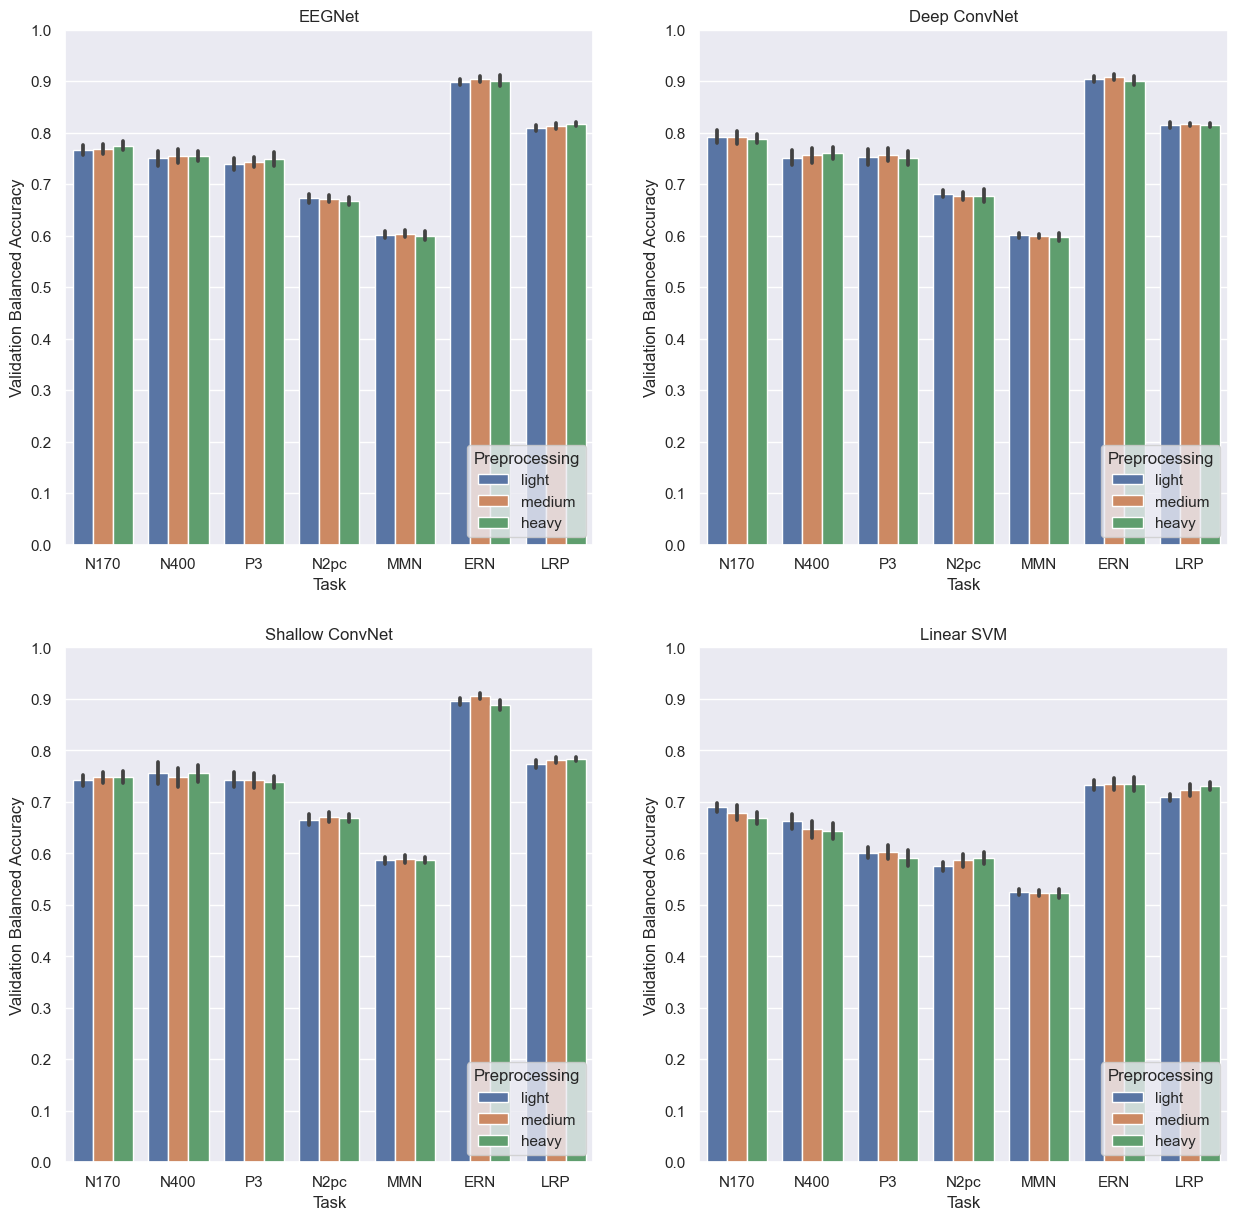

In [11]:
sns.set(style="darkgrid")
fig, axes = plt.subplots(2, 2, figsize=(15, 15), dpi=100)
#axes[0,0].title("EEGNet")
sns.barplot(ax=axes[0,0], x="Task", y="Validation Balanced Accuracy", 
            hue="Preprocessing", 
            data=df_task[df_task["Model"]=="eegnet"], ci="sd")
axes[0,0].set_yticks(np.round(np.arange(0,1.1,0.1),1))
axes[0,0].set_title("EEGNet")
axes[0,0].legend(title="Preprocessing", loc='lower right');

sns.barplot(ax=axes[0,1], x="Task", y="Validation Balanced Accuracy", 
            hue="Preprocessing", 
            data=df_task[df_task["Model"]=="deep"], ci="sd")
axes[0,1].set_yticks(np.round(np.arange(0,1.1,0.1),1))
axes[0,1].set_title("Deep ConvNet")
axes[0,1].legend(title="Preprocessing", loc='lower right');

sns.barplot(ax=axes[1,0], x="Task", y="Validation Balanced Accuracy", 
            hue="Preprocessing", 
            data=df_task[df_task["Model"]=="shallow"], ci="sd")
axes[1,0].set_yticks(np.round(np.arange(0,1.1,0.1),1))
axes[1,0].set_title("Shallow ConvNet")
axes[1,0].legend(title="Preprocessing", loc='lower right');

sns.barplot(ax=axes[1,1], x="Task", y="Validation Balanced Accuracy", 
            hue="Preprocessing", 
            data=df_task[df_task["Model"]=="SVM"], ci="sd")
axes[1,1].set_yticks(np.round(np.arange(0,1.1,0.1),1))
axes[1,1].set_title("Linear SVM")
axes[1,1].legend(title="Preprocessing", loc='lower right');

In [148]:
data_path = "F:/Masterthesis/Data/"
model_folder = "ModelComparison"
n_epochs = 25
n_splits = 10

# Get Results
results = []
for model_name in ["eegnet","shallow","deep"]:
    for preprocessing in ["medium"]:
        for task in ["N170", "N400", "P3", "N2pc", "MMN", "ERN", "LRP"]:
            df = Training.load_exp(model_folder, model_name, task, preprocessing, n_splits)
            df["Model"] = model_name
            df["Preprocessing"] = preprocessing
            df["Task"] = task
            results.append(df.iloc[-1])
df_results = pd.concat(results, axis=1)
df_results = df_results.transpose().reset_index()
# Put results in correct dataframe for seaborn plot
df_task = df_results[["Task", "Model", "Preprocessing","valid_balanced_accuracy"]]
df_task = df_task.rename(columns={"valid_balanced_accuracy": "Validation Balanced Accuracy"})
list = []
for i in range(3,13):
    list.append(df_task.iloc[:,[0,1,2,i]])
df_task = pd.concat(list, axis=0)
#df_task
"""model_folder = "ModelComparison_EqualSamples1000"
df_path = os.getcwd()+"\\"+model_folder+"\\"
df_svm = pd.read_csv(df_path+"df_svm.csv")
df_task = df_svm"""

model = "deep"
print(df_task[df_task["Model"]==model].mean())
average_std = 0
for task in ["N170", "N400", "P3", "N2pc", "MMN", "ERN", "LRP"]:
    average_std += df_task[(df_task["Task"]==task) & (df_task["Model"]==model)].std()
average_std/7

Validation Balanced Accuracy    0.757902
dtype: float64


Validation Balanced Accuracy    0.008936
dtype: float64

In [149]:
model_folder = "ModelComparison"
df_path = os.getcwd()+"\\"+model_folder+"\\"
df_svm = pd.read_csv(df_path+"df_svm.csv")
df_task = df_svm

In [150]:
print(df_task[df_task["Model"]=="SVM"].mean())
average_std = 0
for task in ["N170", "N400", "P3", "N2pc", "MMN", "ERN", "LRP"]:
    average_std += df_task[(df_task["Task"]==task) & (df_task["Model"]=="SVM")].std()
average_std/7

Validation Balanced Accuracy    0.64222
dtype: float64


Validation Balanced Accuracy    0.012804
dtype: float64

### SVM Tests

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler


data_path = "F:/Masterthesis/Data/"
preprocessing = "medium"

scores_list = []
for task in ["N170", "N400", "P3", "N2pc", "MMN", "ERN", "LRP"]:
#for task in ["N170"]:
    df = DataLoader.load_df(data_path, task, preprocessing)
    df = df.groupby(["condition"]).sample(1338)
    data, labels = DataLoader.create_data_labels(df)
    #class_weights=class_weight.compute_class_weight('balanced',np.unique(labels),labels)
    cv = StratifiedShuffleSplit(10, test_size=0.2, random_state=42)
    cv_split = cv.split(data, labels)
    svc = LinearSVC(class_weight="balanced")
    clf = Pipeline([("StandardScaler",StandardScaler()), ('LinearSVC', svc)])
    scores = cross_val_score(clf, data.reshape(-1, 28*251), labels, cv=cv, n_jobs=-1, scoring="balanced_accuracy")
    scores_list.append(scores)
    #class_balance = np.mean(labels == labels[0])
    #class_balance = max(class_balance, 1. - class_balance)
    print(task+": "+str(np.mean(scores)))
    #print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
    #                                                          class_balance))

N170: 0.6759328358208956
N400: 0.6505597014925374
P3: 0.6401119402985074
N2pc: 0.5912313432835821
MMN: 0.5287313432835822
ERN: 0.8
LRP: 0.7055970149253732


In [20]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler


data_path = "F:/Masterthesis/Data/"
preprocessing = "medium_reference"

scores_list = []
for task in ["N170", "N400", "P3", "N2pc", "MMN", "ERN", "LRP"]:
#for task in ["N170"]:
    df = DataLoader.load_df(data_path, task, preprocessing)
    df = df.groupby(["condition"]).sample(1338)
    data, labels = DataLoader.create_data_labels(df)
    #class_weights=class_weight.compute_class_weight('balanced',np.unique(labels),labels)
    cv = StratifiedShuffleSplit(10, test_size=0.2, random_state=42)
    cv_split = cv.split(data, labels)
    svc = LinearSVC(class_weight="balanced")
    clf = Pipeline([("StandardScaler",StandardScaler()), ('LinearSVC', svc)])
    scores = cross_val_score(clf, data.reshape(-1, 28*251), labels, cv=cv, n_jobs=-1, scoring="balanced_accuracy")
    scores_list.append(scores)
    #class_balance = np.mean(labels == labels[0])
    #class_balance = max(class_balance, 1. - class_balance)
    print(task+": "+str(np.mean(scores)))
    #print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
    #                                                          class_balance))

N170: 0.6886194029850746
N400: 0.6468283582089552
P3: 0.6347014925373134
N2pc: 0.5805970149253732
MMN: 0.5242537313432836
ERN: 0.8087686567164178
LRP: 0.7014925373134329


In [8]:
model_folder = "ModelComparison"

# Get Results
results = []
for model_name in ["eegnet","shallow","deep"]:
    for preprocessing in ["medium"]:
        for task in ["N170", "N400", "P3", "N2pc", "MMN", "ERN", "LRP"]:
            df = Training.load_exp(model_folder, model_name, task, preprocessing, n_splits)
            df["Model"] = model_name
            df["Preprocessing"] = preprocessing
            df["Task"] = task
            results.append(df.iloc[-1])
df_results = pd.concat(results, axis=1)
df_results = df_results.transpose().reset_index()
# Put results in correct dataframe for seaborn plot
df_task = df_results[["Task", "Model", "Preprocessing","valid_balanced_accuracy"]]
df_task = df_task.rename(columns={"valid_balanced_accuracy": "Validation Balanced Accuracy"})
list = []
for i in range(3,8):
    list.append(df_task.iloc[:,[0,1,2,i]])
df_task = pd.concat(list, axis=0)

In [26]:
pd.DataFrame([["N170","svm","medium",0.9]], columns = ["Model","Preprocessing", "Task", "Validation Balanced Accuracy"])

Model Preprocessing    Task  Validation Balanced Accuracy
0  N170           svm  medium                           0.9

In [30]:
df_task = df_task.append(pd.DataFrame([["N170","svm","medium",0.7013059701492538]], columns = ["Task","Model", "Preprocessing", "Validation Balanced Accuracy"]), ignore_index=True)
df_task = df_task.append(pd.DataFrame([["N400","svm","medium",0.730410447761194]], columns = ["Task","Model", "Preprocessing", "Validation Balanced Accuracy"]), ignore_index=True)
df_task = df_task.append(pd.DataFrame([["P3","svm","medium",0.7091417910447761]], columns = ["Task","Model", "Preprocessing", "Validation Balanced Accuracy"]), ignore_index=True)
df_task = df_task.append(pd.DataFrame([["N2pc","svm","medium",0.6259328358208954]], columns = ["Task","Model", "Preprocessing", "Validation Balanced Accuracy"]), ignore_index=True)
df_task = df_task.append(pd.DataFrame([["MMN","svm","medium",0.5384328358208954]], columns = ["Task","Model", "Preprocessing", "Validation Balanced Accuracy"]), ignore_index=True)
df_task = df_task.append(pd.DataFrame([["ERN","svm","medium",0.8649253731343285]], columns = ["Task","Model", "Preprocessing", "Validation Balanced Accuracy"]), ignore_index=True)
df_task = df_task.append(pd.DataFrame([["LRP","svm","medium",0.717910447761194]], columns = ["Task","Model", "Preprocessing", "Validation Balanced Accuracy"]), ignore_index=True)


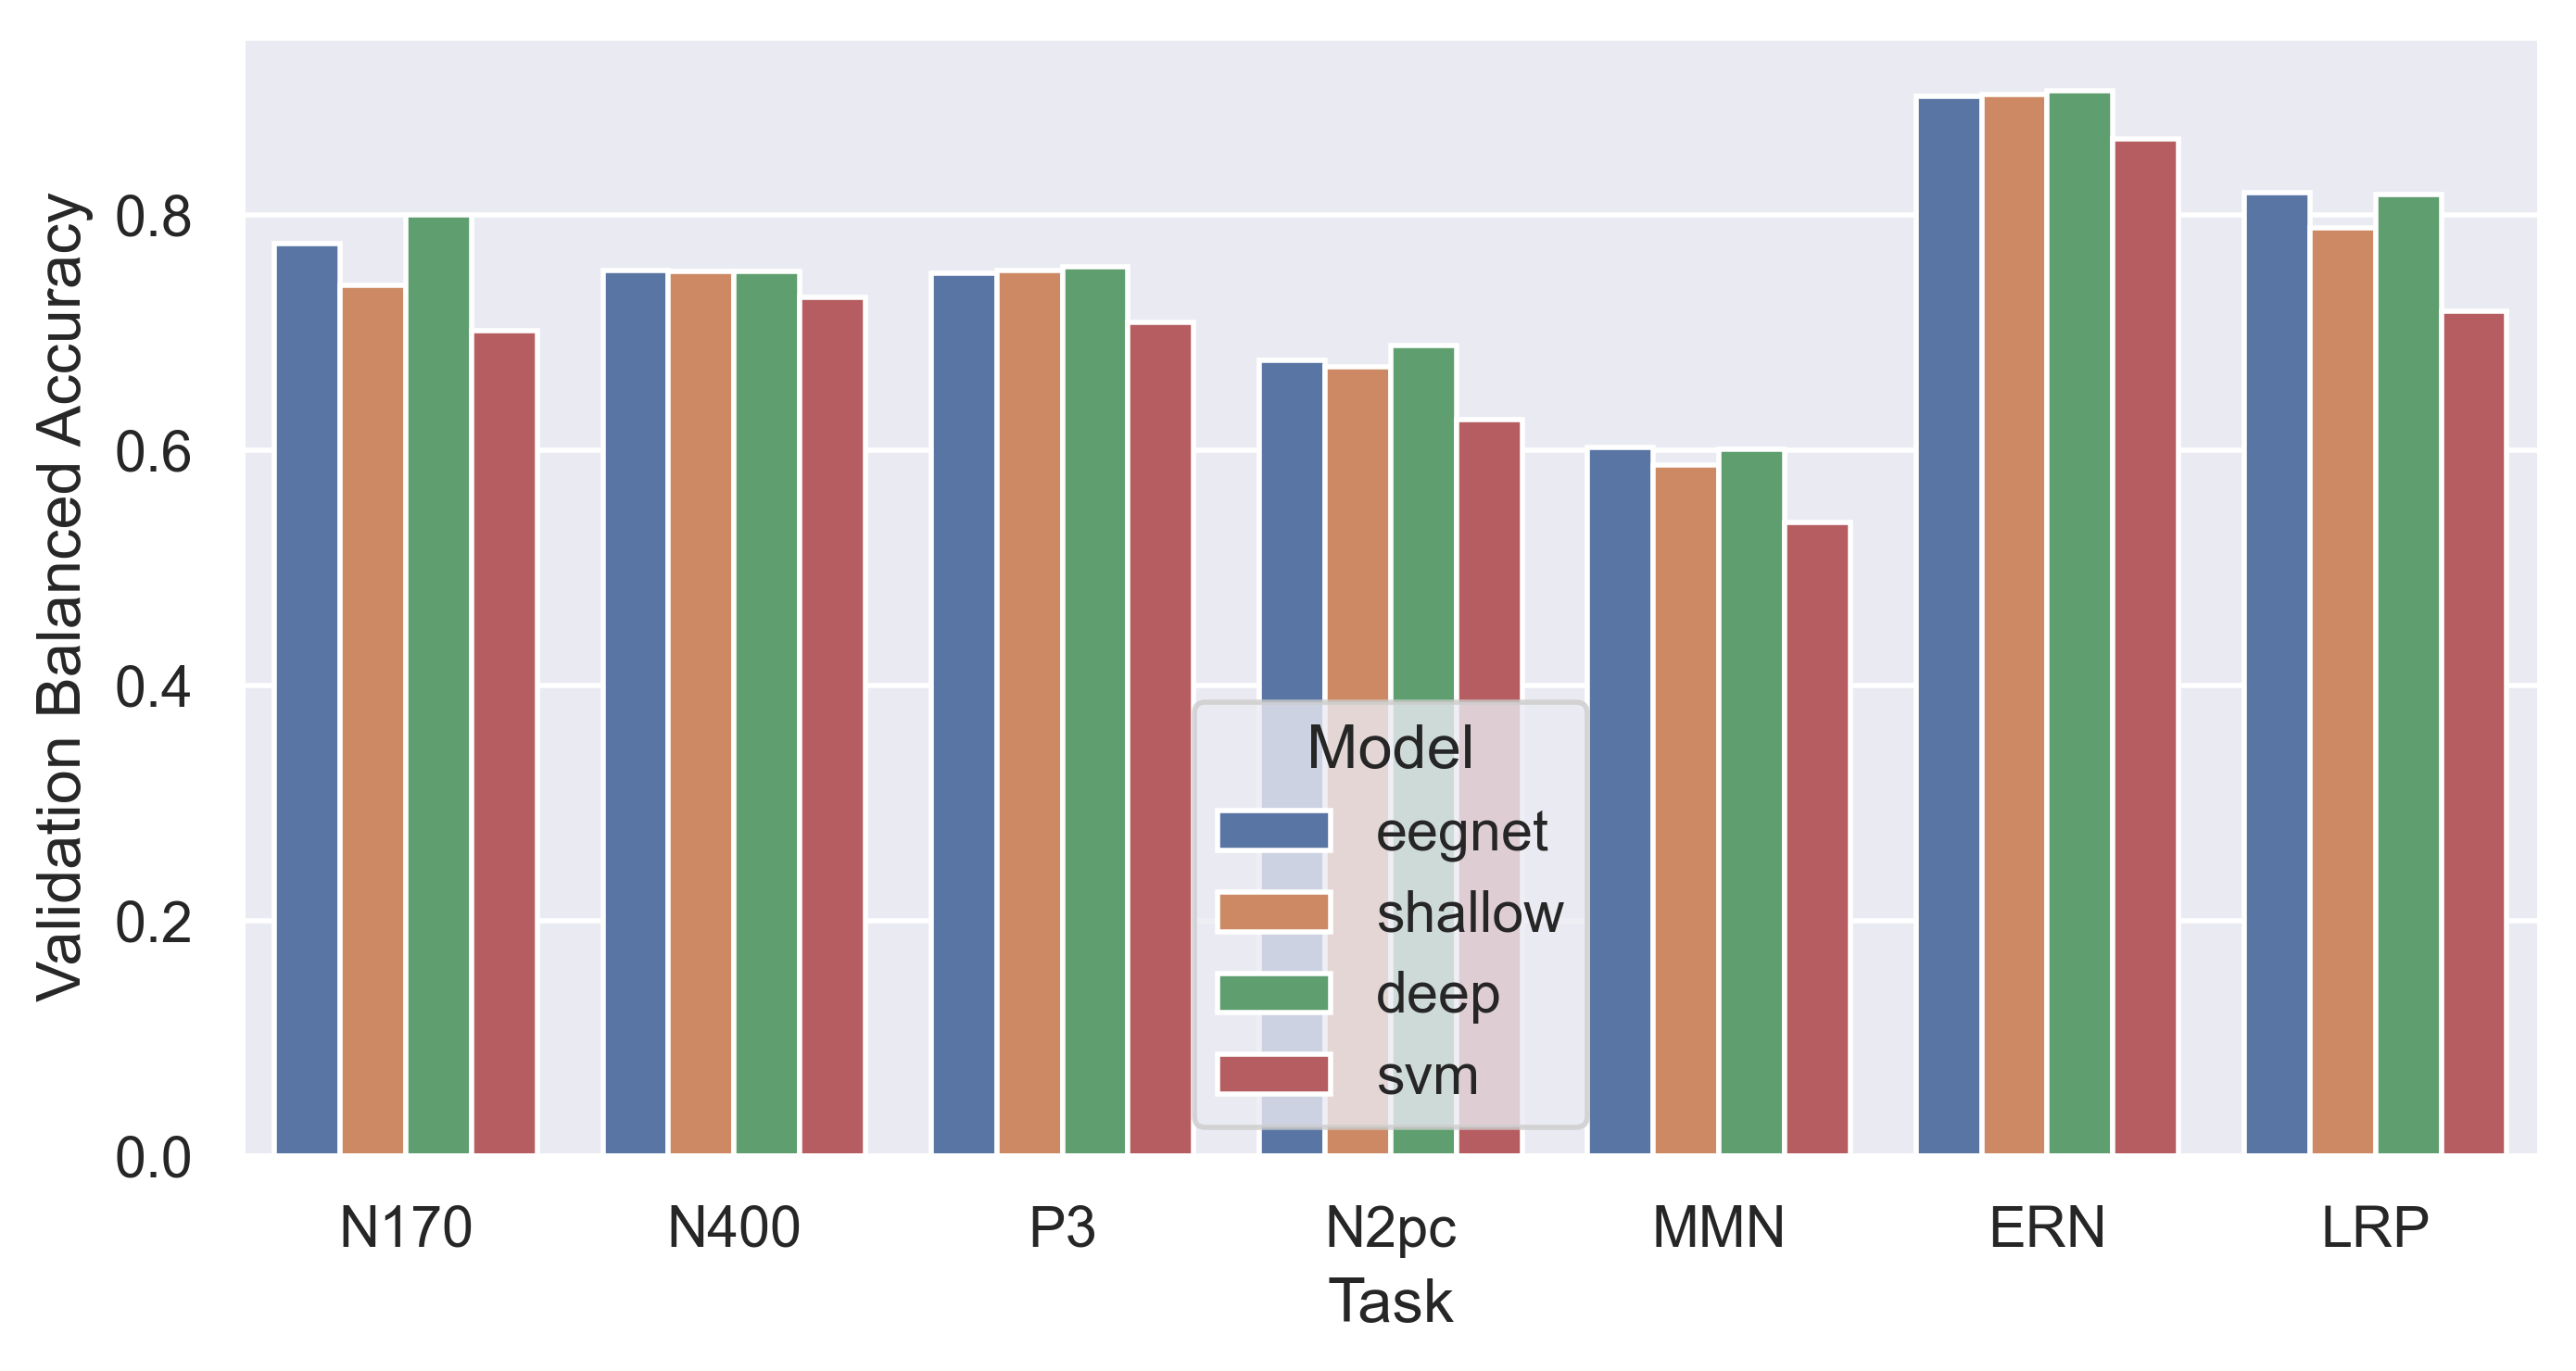

In [32]:
# N170 plot, no downsampling
sns.set(style="darkgrid")
plt.figure(figsize=(8, 4), dpi=400)
sns.barplot(x="Task", y="Validation Balanced Accuracy", 
            hue="Model", 
            data=df_task, ci=None);

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.utils import class_weight

data_path = "F:/Masterthesis/Data/"
preprocessing = "medium"

for task in ["N170", "N400", "P3"]:
#for task in ["N170"]:
    df = DataLoader.load_df(data_path, task, preprocessing)
    data, labels = DataLoader.create_data_labels(df)
    #class_weights=class_weight.compute_class_weight('balanced',np.unique(labels),labels)
    cv = StratifiedShuffleSplit(1, test_size=0.2, random_state=42)
    cv_split = cv.split(data, labels)
    rc = RidgeClassifier(class_weight="balanced")
    clf = Pipeline([('RidgeClassifier', rc)])
    scores = cross_val_score(clf, data.reshape(-1, 28*251), labels, cv=cv, n_jobs=-1, scoring="balanced_accuracy")
    #class_balance = np.mean(labels == labels[0])
    #class_balance = max(class_balance, 1. - class_balance)
    print(task+": "+str(np.mean(scores)))

N170: 0.6326146076146075
N400: 0.5038811813771384
P3: 0.61614673198277


In [3]:
data_path = "F:/Masterthesis/Data/"
preprocessing = "medium_reference"
model_folder = "ModelComparison_EqualSamples"
n_epochs = 25
n_splits = 10
lr = 0.01

for model_name in ["deep"]:
    for task in ["N170", "N400", "P3", "N2pc", "MMN", "ERN", "LRP"]:
        df = DataLoader.load_df(data_path, task, preprocessing)
        # lowest number of samples is P3 condition 0 with 1338 samples
        df = df.groupby(["condition"]).sample(1338)
        data, labels = DataLoader.create_data_labels(df)
        Training.run_exp(data, labels, task, preprocessing, model_folder, model_name, 
                lr, n_epochs, n_splits, batch_size=64)

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.5472        1.5441                     0.6119        0.6733  0.0100  1.3542
      2                     0.6168        0.7226                     0.6007        0.7206  0.0100  0.2215
      3                     0.6332        0.6912                     0.6679        0.6099  0.0098  0.2160
      4                     0.6486        0.7711                     0.5672        1.2183  0.0096  0.2158
      5                     0.6463        0.7348                     0.6903        0.5942  0.0093  0.2382
      6                     0.7112        0.5833                     0.7071        0.6102  0.0090  0.2503
      7                     0.7182        0.5707              

      9                     0.7439        0.5260                     0.7015        0.5890  0.0075  0.2174
     10                     0.7364        0.5279                     0.6903        0.6013  0.0069  0.2194
     11                     0.7561        0.4975                     0.7201        0.5660  0.0063  0.2174
     12                     0.7407        0.5202                     0.7276        0.5719  0.0057  0.2165
     13                     0.7645        0.4856                     0.6698        0.6647  0.0050  0.2167
     14                     0.7752        0.4852                     0.7295        0.5540  0.0043  0.2184
     15                     0.7883        0.4494                     0.7351        0.5737  0.0037  0.2173
     16                     0.7991        0.4380                     0.7313        0.5709  0.0031  0.2159
     17                     0.8042        0.4279                     0.7295        0.5538  0.0025  0.2163
     18                     0.8014        0.43

     19                     0.8042        0.4193                     0.7369        0.5183  0.0015  0.2184
     20                     0.8159        0.4067                     0.7332        0.5295  0.0010  0.2184
     21                     0.8252        0.3927                     0.7444        0.5253  0.0007  0.2178
     22                     0.8215        0.3959                     0.7444        0.5349  0.0004  0.2234
     23                     0.8224        0.3941                     0.7444        0.5336  0.0002  0.2294
     24                     0.8234        0.4017                     0.7444        0.5344  0.0000  0.2184
     25                     0.8257        0.3903                     0.7407        0.5351  0.0000  0.2174
Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  ------------

      3                     0.6350        0.6979                     0.6735        0.5985  0.0098  0.2194
      4                     0.6505        0.6820                     0.6231        0.7224  0.0096  0.2234
      5                     0.6617        0.6318                     0.6138        0.7849  0.0093  0.2234
      6                     0.6692        0.6762                     0.7090        0.6217  0.0090  0.2175
      7                     0.7014        0.6202                     0.6586        0.6350  0.0085  0.2174
      8                     0.7070        0.5988                     0.6884        0.6215  0.0080  0.2201
      9                     0.7075        0.5973                     0.6772        0.5973  0.0075  0.2192
     10                     0.7327        0.5498                     0.7537        0.5252  0.0069  0.2191
     11                     0.7435        0.5357                     0.7519        0.5351  0.0063  0.2185
     12                     0.7598        0.50

     13                     0.7537        0.5082                     0.7425        0.5347  0.0050  0.2174
     14                     0.7589        0.4899                     0.7444        0.5157  0.0043  0.2214
     15                     0.7738        0.4776                     0.7444        0.5114  0.0037  0.2185
     16                     0.7673        0.4795                     0.7369        0.5500  0.0031  0.2174
     17                     0.7790        0.4655                     0.7369        0.5241  0.0025  0.2174
     18                     0.7855        0.4477                     0.7575        0.5197  0.0020  0.2168
     19                     0.7963        0.4365                     0.7631        0.5011  0.0015  0.2194
     20                     0.8033        0.4269                     0.7593        0.5093  0.0010  0.2182
     21                     0.8061        0.4281                     0.7612        0.5063  0.0007  0.2190
     22                     0.8145        0.41

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.6257        1.3633                     0.7164        0.7662  0.0100  0.2134
      2                     0.6925        0.6444                     0.6287        0.8848  0.0100  0.2216
      3                     0.6888        0.6673                     0.6381        0.8167  0.0098  0.2161
      4                     0.6925        0.6703                     0.7071        0.6246  0.0096  0.2176
      5                     0.7145        0.5801                     0.6698        0.5980  0.0093  0.2175
      6                     0.7103        0.5965                     0.7015        0.5739  0.0090  0.2218
      7                     0.7126        0.5815              

     11                     0.7402        0.5299                     0.7183        0.5668  0.0063  0.2198
     12                     0.7565        0.5117                     0.7146        0.5529  0.0057  0.2166
     13                     0.7397        0.5294                     0.7127        0.5965  0.0050  0.2174
     14                     0.7654        0.4903                     0.7425        0.5183  0.0043  0.2183
     15                     0.7477        0.4993                     0.7276        0.5213  0.0037  0.2151
     16                     0.7612        0.4808                     0.6810        0.5836  0.0031  0.2204
     17                     0.7673        0.4662                     0.7276        0.5497  0.0025  0.2170
     18                     0.7706        0.4675                     0.7164        0.5404  0.0020  0.2193
     19                     0.7794        0.4564                     0.7332        0.5297  0.0015  0.2147
     20                     0.7850        0.45

     24                     0.7916        0.4412                     0.7612        0.5190  0.0000  0.2176
     25                     0.7832        0.4386                     0.7575        0.5193  0.0000  0.2204
Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.6290        1.3392                     0.6418        0.9105  0.0100  0.2114
      2                     0.6953        0.6818                     0.7146        0.5728  0.0100  0.2214
      3                     0.6949        0.6484                     0.7239        0.5841  0.0098  0.2174
      4                     0.7248        0.5930                     0.7071        0.5708  0.0096  0.2160
      5                     0.7266        0.5452              

     10                     0.7126        0.5811                     0.7388        0.5777  0.0069  0.2181
     11                     0.7444        0.5243                     0.7351        0.5146  0.0063  0.2184
     12                     0.7565        0.4893                     0.7425        0.5152  0.0057  0.2184
     13                     0.7678        0.4798                     0.7388        0.5153  0.0050  0.2178
     14                     0.7678        0.4790                     0.7593        0.5083  0.0043  0.2170
     15                     0.7673        0.4875                     0.7146        0.5301  0.0037  0.2164
     16                     0.7748        0.4612                     0.7425        0.5199  0.0031  0.2174
     17                     0.7785        0.4559                     0.7593        0.5323  0.0025  0.2184
     18                     0.7799        0.4670                     0.7481        0.5184  0.0020  0.2171
     19                     0.7841        0.45

     22                     0.7967        0.4250                     0.7537        0.5284  0.0004  0.2165
     23                     0.8023        0.4247                     0.7519        0.5292  0.0002  0.2185
     24                     0.8047        0.4183                     0.7519        0.5284  0.0000  0.2204
     25                     0.7935        0.4219                     0.7556        0.5287  0.0000  0.2174


C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.5738        1.3481                     0.5149        1.0071  0.0100  0.2164
      2                     0.6444        0.7021                     0.6250        0.6914  0.0100  0.2195
      3                     0.6827        0.6376                     0.6362        0.7950  0.0098  0.2175
      4                     0.6584        0.6516                     0.5765        0.7343  0.0096  0.2169
      5                     0.6584        0.7284                     0.6828        0.6634  0.0093  0.2212
      6                     0.6967        0.6193                     0.6772        0.6480  0.0090  0.2177
      7                     0.7009        0.6215              

      9                     0.7009        0.5886                     0.6922        0.6083  0.0075  0.2184
     10                     0.7023        0.6173                     0.6847        0.6086  0.0069  0.2219
     11                     0.6939        0.5759                     0.6959        0.6165  0.0063  0.2164
     12                     0.7271        0.5609                     0.6978        0.6224  0.0057  0.2180
     13                     0.7458        0.5363                     0.7369        0.5476  0.0050  0.2194
     14                     0.7308        0.5290                     0.7201        0.5663  0.0043  0.2184
     15                     0.7355        0.5329                     0.7276        0.5538  0.0037  0.2175
     16                     0.7500        0.5126                     0.7463        0.5356  0.0031  0.2166
     17                     0.7561        0.5035                     0.7090        0.5644  0.0025  0.2214
     18                     0.7575        0.50

     20                     0.7860        0.4542                     0.7183        0.6343  0.0010  0.2214
     21                     0.7869        0.4565                     0.7239        0.6275  0.0007  0.2190
     22                     0.7864        0.4490                     0.7220        0.6235  0.0004  0.2176
     23                     0.7813        0.4576                     0.7239        0.6263  0.0002  0.2172
     24                     0.7893        0.4500                     0.7220        0.6260  0.0000  0.2185
     25                     0.7832        0.4584                     0.7220        0.6263  0.0000  0.2211
Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.5449        1.3983              

      3                     0.6631        0.6779                     0.6194        1.0926  0.0098  0.2198
      4                     0.6514        0.6989                     0.6399        0.8870  0.0096  0.2164
      5                     0.6963        0.6167                     0.6772        0.7916  0.0093  0.2171
      6                     0.6972        0.5960                     0.6884        0.6692  0.0090  0.2171
      7                     0.7005        0.6499                     0.6530        0.7960  0.0085  0.2194
      8                     0.6897        0.6195                     0.6922        0.6449  0.0080  0.2174
      9                     0.7136        0.5751                     0.6791        0.6461  0.0075  0.2164
     10                     0.7276        0.5443                     0.6791        0.6298  0.0069  0.2182
     11                     0.7332        0.5408                     0.6735        0.6591  0.0063  0.2214
     12                     0.7252        0.54

     16                     0.7570        0.5142                     0.7090        0.5602  0.0031  0.2163
     17                     0.7505        0.5130                     0.6698        0.6317  0.0025  0.2194
     18                     0.7607        0.5051                     0.7127        0.5581  0.0020  0.2146
     19                     0.7715        0.4759                     0.7313        0.5391  0.0015  0.2204
     20                     0.7748        0.4749                     0.7369        0.5439  0.0010  0.2174
     21                     0.7776        0.4735                     0.7388        0.5535  0.0007  0.2164
     22                     0.7729        0.4805                     0.7332        0.5454  0.0004  0.2214
     23                     0.7790        0.4697                     0.7313        0.5436  0.0002  0.2174
     24                     0.7850        0.4593                     0.7444        0.5447  0.0000  0.2175
     25                     0.7799        0.46

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.5093        1.6600                     0.4869        1.0292  0.0100  0.2124
      2                     0.5079        0.8656                     0.4851        0.8338  0.0100  0.2185
      3                     0.4879        1.1663                     0.4907        0.8133  0.0098  0.2204
      4                     0.5075        0.7777                     0.5280        0.7348  0.0096  0.2189
      5                     0.5182        0.7554                     0.5037        0.7095  0.0093  0.2183
      6                     0.5215        0.7506                     0.5187        0.7128  0.0090  0.2165
      7                     0.5299        0.9845              

     10                     0.5640        0.7361                     0.5019        0.9294  0.0069  0.2172
     11                     0.6150        0.7182                     0.5951        0.6750  0.0063  0.2204
     12                     0.6271        0.6910                     0.5728        0.6830  0.0057  0.2188
     13                     0.6248        0.7052                     0.6045        0.6545  0.0050  0.2163
     14                     0.6341        0.6677                     0.5634        0.8621  0.0043  0.2189
     15                     0.6341        0.6908                     0.6493        0.6283  0.0037  0.2170
     16                     0.6575        0.6301                     0.6530        0.6494  0.0031  0.2188
     17                     0.6607        0.6381                     0.6549        0.6570  0.0025  0.2191
     18                     0.6636        0.6233                     0.6493        0.6190  0.0020  0.2166
     19                     0.6654        0.61

     22                     0.6836        0.5964                     0.6437        0.6266  0.0004  0.2179
     23                     0.6846        0.6020                     0.6418        0.6272  0.0002  0.2214
     24                     0.6822        0.5993                     0.6455        0.6261  0.0000  0.2169
     25                     0.6916        0.5984                     0.6437        0.6274  0.0000  0.2174
Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.4949        1.6375                     0.4925        2.8624  0.0100  0.2124
      2                     0.5229        1.2500                     0.5000        0.7699  0.0100  0.2207
      3                     0.5065        0.8298              

      6                     0.5425        0.7600                     0.5280        0.7038  0.0090  0.2174
      7                     0.5243        1.0622                     0.5149        0.7734  0.0085  0.2183
      8                     0.5416        0.7754                     0.5336        0.6895  0.0080  0.2172
      9                     0.5631        0.6965                     0.5616        0.6874  0.0075  0.2165
     10                     0.5930        0.6804                     0.5858        0.6810  0.0069  0.2234
     11                     0.6112        0.7151                     0.5578        0.7156  0.0063  0.2174
     12                     0.6014        0.6897                     0.5840        0.6836  0.0057  0.2178
     13                     0.6565        0.6546                     0.6175        0.6587  0.0050  0.2171
     14                     0.6640        0.6375                     0.6493        0.6350  0.0043  0.2214
     15                     0.6575        0.62

     17                     0.6682        0.6165                     0.6679        0.6155  0.0025  0.2213
     18                     0.6682        0.6203                     0.6866        0.6547  0.0020  0.2164
     19                     0.6696        0.6149                     0.6996        0.6067  0.0015  0.2184
     20                     0.6752        0.6016                     0.6922        0.6218  0.0010  0.2194
     21                     0.6822        0.6003                     0.6828        0.6168  0.0007  0.2184
     22                     0.6893        0.5984                     0.6772        0.6124  0.0004  0.2194
     23                     0.6757        0.6123                     0.6847        0.6263  0.0002  0.2164
     24                     0.6748        0.6027                     0.6810        0.6292  0.0000  0.2203
     25                     0.6766        0.6030                     0.6922        0.6219  0.0000  0.2164


C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.5243        1.5068                     0.5336        1.0740  0.0100  0.2224
      2                     0.5290        0.9368                     0.5131        1.4617  0.0100  0.2224
      3                     0.5112        0.9302                     0.5261        0.7566  0.0098  0.2205
      4                     0.5346        0.7632                     0.5746        0.6878  0.0096  0.2214
      5                     0.5103        1.0294                     0.5168        0.6946  0.0093  0.2160
      6                     0.5500        0.7272                     0.5597        0.6912  0.0090  0.2163
      7                     0.5575        0.6965              

     12                     0.5822        0.6965                     0.5784        0.6948  0.0057  0.2294
     13                     0.5757        0.6994                     0.5896        0.6826  0.0050  0.2364
     14                     0.6009        0.6828                     0.5914        0.6876  0.0043  0.2281
     15                     0.5939        0.6701                     0.5933        0.6942  0.0037  0.2513
     16                     0.6028        0.6684                     0.5896        0.7048  0.0031  0.2364
     17                     0.6009        0.6664                     0.5970        0.6870  0.0025  0.2274
     18                     0.5944        0.6633                     0.5746        0.7084  0.0020  0.2342
     19                     0.6079        0.6616                     0.5709        0.7000  0.0015  0.2473
     20                     0.6150        0.6556                     0.5951        0.6861  0.0010  0.2435
     21                     0.6243        0.65

     25                     0.6341        0.6451                     0.5877        0.6844  0.0000  0.2293
Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.5009        1.4522                     0.5261        1.0159  0.0100  0.2294
      2                     0.5229        0.8804                     0.5224        0.9630  0.0100  0.2324
      3                     0.5252        0.9302                     0.5485        0.7728  0.0098  0.2217
      4                     0.5341        0.9153                     0.4925        0.9697  0.0096  0.2343
      5                     0.5056        0.9327                     0.5131        0.7641  0.0093  0.2247
      6                     0.5589        0.7378              

      9                     0.5752        0.7125                     0.5429        0.7404  0.0075  0.2188
     10                     0.5813        0.7023                     0.5933        0.7728  0.0069  0.2173
     11                     0.5846        0.6982                     0.5299        0.7206  0.0063  0.2176
     12                     0.5916        0.6969                     0.5448        0.7362  0.0057  0.2202
     13                     0.5850        0.7136                     0.5690        0.8010  0.0050  0.2197
     14                     0.5958        0.7044                     0.5840        0.7794  0.0043  0.2193
     15                     0.6033        0.6725                     0.5989        0.7415  0.0037  0.2214
     16                     0.5869        0.6840                     0.5709        0.6937  0.0031  0.2245
     17                     0.6196        0.6623                     0.6063        0.6915  0.0025  0.2364
     18                     0.6145        0.67

     22                     0.6023        0.6614                     0.6437        0.6629  0.0004  0.2293
     23                     0.6140        0.6582                     0.6399        0.6653  0.0002  0.2223
     24                     0.5995        0.6574                     0.6343        0.6664  0.0000  0.2269
     25                     0.5963        0.6591                     0.6269        0.6668  0.0000  0.2314


C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.7089        1.0984                     0.8265        0.4998  0.0100  0.2224
      2                     0.7846        0.5555                     0.7873        0.6591  0.0100  0.2213
      3                     0.7949        0.5197                     0.8582        0.3436  0.0098  0.2220
      4                     0.8089        0.4526                     0.8302        0.4021  0.0096  0.2177
      5                     0.8136        0.4980                     0.8358        0.4203  0.0093  0.2260
      6                     0.8355        0.3998                     0.8694        0.3262  0.0090  0.2191
      7                     0.8327        0.3898              

     10                     0.8500        0.3505                     0.8396        0.3606  0.0069  0.2613
     11                     0.8748        0.3214                     0.8638        0.3127  0.0063  0.2424
     12                     0.8626        0.3278                     0.8769        0.3021  0.0057  0.2383
     13                     0.8734        0.3423                     0.8937        0.2811  0.0050  0.2244
     14                     0.8678        0.3357                     0.8787        0.3164  0.0043  0.2214
     15                     0.8738        0.3063                     0.8881        0.2854  0.0037  0.2174
     16                     0.8846        0.2783                     0.8638        0.2959  0.0031  0.2499
     17                     0.8860        0.2792                     0.8974        0.2751  0.0025  0.2308
     18                     0.8911        0.2741                     0.8918        0.2734  0.0020  0.2300
     19                     0.9005        0.25

     21                     0.9047        0.2355                     0.8825        0.2859  0.0007  0.2256
     22                     0.9098        0.2336                     0.8918        0.2886  0.0004  0.2204
     23                     0.9079        0.2346                     0.8899        0.2863  0.0002  0.2242
     24                     0.9159        0.2234                     0.8918        0.2863  0.0000  0.2244
     25                     0.9107        0.2260                     0.8899        0.2863  0.0000  0.2264
Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.7266        1.0183                     0.7220        0.8821  0.0100  0.2174
      2                     0.7804        0.5833              

      6                     0.8463        0.3786                     0.8265        0.4471  0.0090  0.2189
      7                     0.8308        0.4150                     0.8228        0.4604  0.0085  0.2161
      8                     0.8449        0.3605                     0.8321        0.4212  0.0080  0.2164
      9                     0.8654        0.3406                     0.7854        0.5677  0.0075  0.2164
     10                     0.8729        0.3396                     0.8470        0.3894  0.0069  0.2175
     11                     0.8748        0.3140                     0.8414        0.3986  0.0063  0.2170
     12                     0.8720        0.3266                     0.8209        0.4793  0.0057  0.2164
     13                     0.8626        0.3156                     0.8507        0.3912  0.0050  0.2166
     14                     0.8776        0.2862                     0.8451        0.3710  0.0043  0.2164
     15                     0.8949        0.26

     17                     0.8967        0.2649                     0.8489        0.3254  0.0025  0.2158
     18                     0.8897        0.2685                     0.8750        0.2957  0.0020  0.2174
     19                     0.9065        0.2518                     0.8601        0.3014  0.0015  0.2174
     20                     0.9079        0.2427                     0.8750        0.2900  0.0010  0.2224
     21                     0.8991        0.2433                     0.8750        0.2928  0.0007  0.2176
     22                     0.9014        0.2328                     0.8675        0.3014  0.0004  0.2164
     23                     0.9126        0.2277                     0.8694        0.2957  0.0002  0.2164
     24                     0.9238        0.2257                     0.8675        0.2950  0.0000  0.2377
     25                     0.9051        0.2343                     0.8657        0.2929  0.0000  0.2304


C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.4972        1.7341                     0.5149        2.0811  0.0100  0.2134
      2                     0.5294        0.9895                     0.6119        0.6585  0.0100  0.2224
      3                     0.6014        0.8085                     0.5765        0.8073  0.0098  0.2294
      4                     0.6561        0.6650                     0.6791        0.6219  0.0096  0.2264
      5                     0.7047        0.6046                     0.6847        0.5960  0.0093  0.2224
      6                     0.7196        0.5757                     0.7425        0.5097  0.0090  0.2195
      7                     0.7687        0.5161              

      8                     0.7645        0.5203                     0.7612        0.5346  0.0080  0.2334
      9                     0.7738        0.4965                     0.8060        0.4841  0.0075  0.2379
     10                     0.7836        0.4658                     0.7519        0.5172  0.0069  0.2229
     11                     0.7734        0.4902                     0.7780        0.4716  0.0063  0.2405
     12                     0.7766        0.4751                     0.7724        0.4897  0.0057  0.2234
     13                     0.8005        0.4468                     0.7929        0.4476  0.0050  0.2244
     14                     0.8084        0.4366                     0.7873        0.4921  0.0043  0.2205
     15                     0.7958        0.4389                     0.7929        0.4671  0.0037  0.2354
     16                     0.8093        0.4234                     0.7780        0.4913  0.0031  0.2324
     17                     0.8065        0.41

     19                     0.8178        0.3987                     0.8265        0.4005  0.0015  0.2374
     20                     0.8285        0.3902                     0.8153        0.4184  0.0010  0.2364
     21                     0.8257        0.3831                     0.8209        0.4080  0.0007  0.2354
     22                     0.8327        0.3788                     0.8190        0.4111  0.0004  0.2399
     23                     0.8290        0.3834                     0.8172        0.4106  0.0002  0.2354
     24                     0.8243        0.3920                     0.8153        0.4132  0.0000  0.2360
     25                     0.8322        0.3758                     0.8153        0.4100  0.0000  0.2374
Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  ------------

      2                     0.5318        0.9282                     0.6082        0.6842  0.0100  0.2164
      3                     0.5949        0.7130                     0.6828        0.5901  0.0098  0.2164
      4                     0.6678        0.6711                     0.6343        0.6820  0.0096  0.2165
      5                     0.6799        0.6454                     0.7015        0.6050  0.0093  0.2164
      6                     0.6776        0.7788                     0.6660        1.0009  0.0090  0.2205
      7                     0.7061        0.6578                     0.7313        0.5459  0.0085  0.2186
      8                     0.7481        0.5319                     0.7537        0.5071  0.0080  0.2166
      9                     0.7411        0.5495                     0.7668        0.4895  0.0075  0.2165
     10                     0.7827        0.4780                     0.7724        0.4952  0.0069  0.2174
     11                     0.7822        0.47

     12                     0.7664        0.4955                     0.7929        0.4644  0.0057  0.2383
     13                     0.7822        0.4639                     0.7892        0.4630  0.0050  0.2334
     14                     0.7860        0.4552                     0.7612        0.4839  0.0043  0.2331
     15                     0.8084        0.4284                     0.7724        0.4779  0.0037  0.2314
     16                     0.8028        0.4348                     0.7705        0.4723  0.0031  0.2194
     17                     0.8210        0.4075                     0.7649        0.4919  0.0025  0.2568
     18                     0.8065        0.4162                     0.7743        0.4663  0.0020  0.2183
     19                     0.8182        0.4007                     0.7743        0.4612  0.0015  0.2159
     20                     0.8168        0.3927                     0.7724        0.4658  0.0010  0.2190
     21                     0.8257        0.38

In [9]:
# Get Results
results = []
for model_name in ["deep"]:
    for preprocessing in ["medium", "medium_reference"]:
        for task in ["N170", "N400", "P3", "N2pc", "MMN", "ERN", "LRP"]:
            df = Training.load_exp(model_folder, model_name, task, preprocessing, n_splits)
            df["Model"] = model_name
            df["Preprocessing"] = preprocessing
            df["Task"] = task
            results.append(df.iloc[-1])
df_results = pd.concat(results, axis=1)
df_results = df_results.transpose().reset_index()
# Put results in correct dataframe for seaborn plot
df_task = df_results[["Task", "Model", "Preprocessing","valid_balanced_accuracy"]]
df_task = df_task.rename(columns={"valid_balanced_accuracy": "Validation Balanced Accuracy"})
list = []
for i in range(3,8):
    list.append(df_task.iloc[:,[0,1,2,i]])
df_task = pd.concat(list, axis=0)
df_task

Task Model     Preprocessing Validation Balanced Accuracy
0   N170  deep            medium                     0.751866
1   N400  deep            medium                      0.76306
2     P3  deep            medium                     0.731343
3   N2pc  deep            medium                     0.652985
4    MMN  deep            medium                     0.617537
..   ...   ...               ...                          ...
9     P3  deep  medium_reference                     0.722015
10  N2pc  deep  medium_reference                     0.643657
11   MMN  deep  medium_reference                     0.587687
12   ERN  deep  medium_reference                     0.889925
13   LRP  deep  medium_reference                     0.815299

[70 rows x 4 columns]

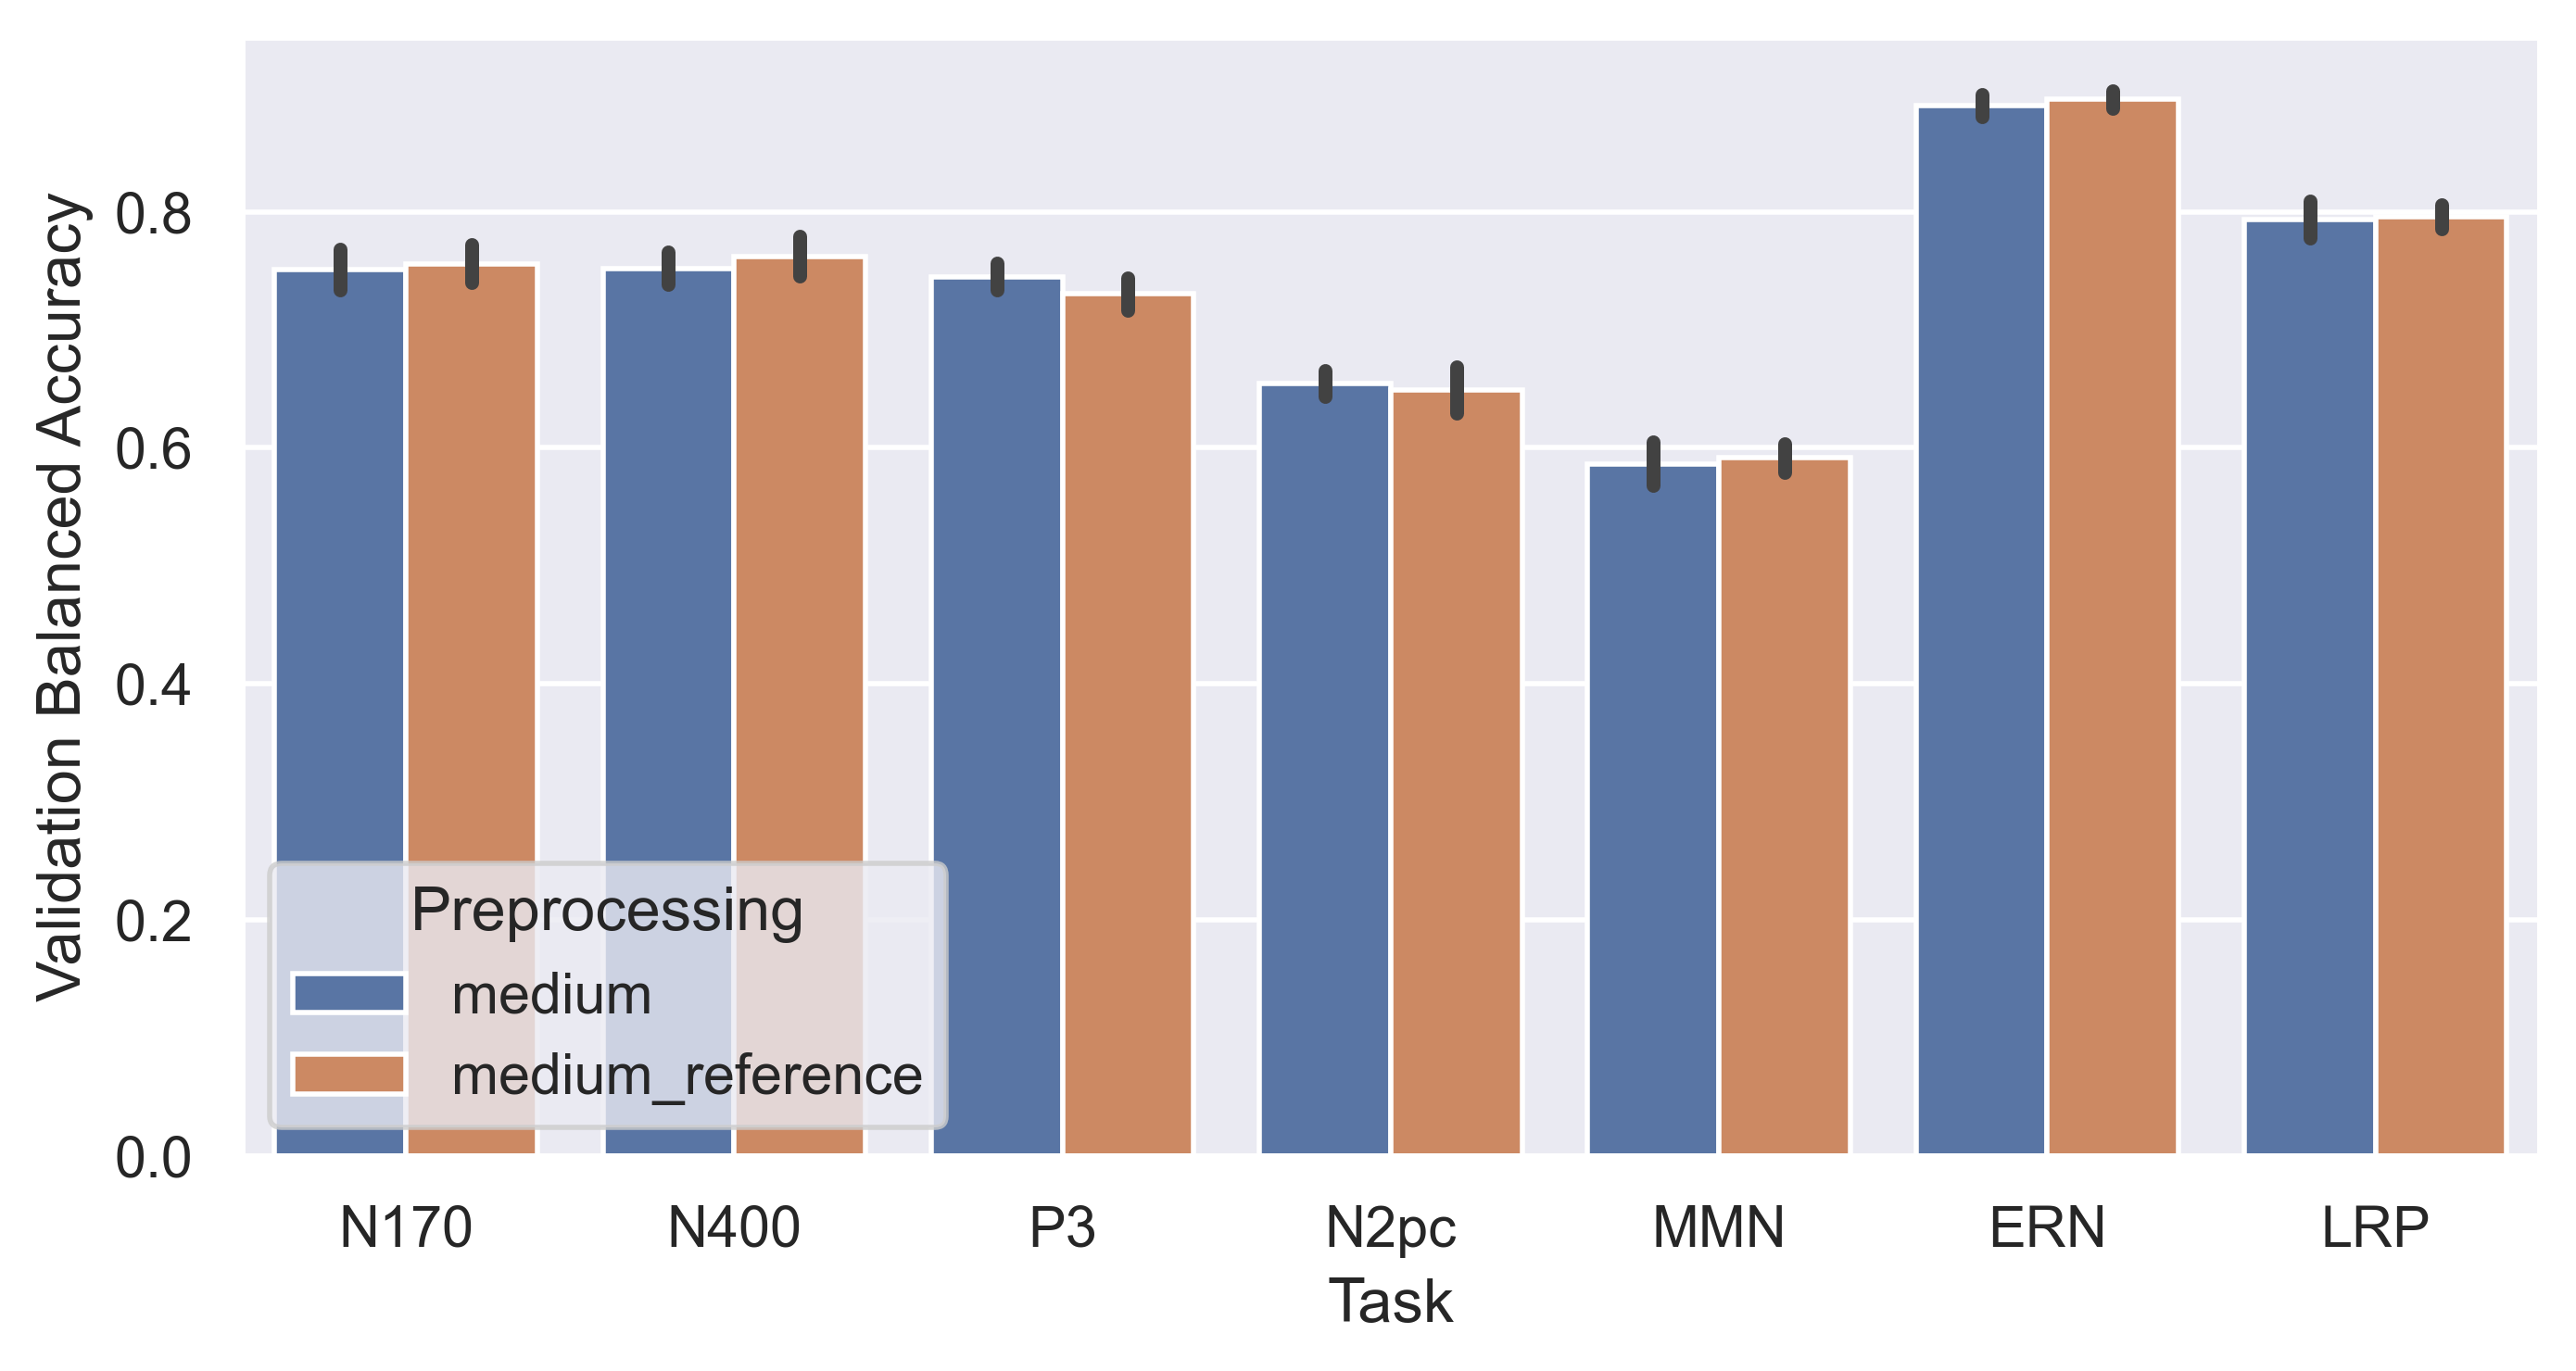

In [12]:
sns.set(style="darkgrid")
plt.figure(figsize=(8, 4), dpi=400)
sns.barplot(x="Task", y="Validation Balanced Accuracy", 
            hue="Preprocessing", 
            data=df_task, ci="sd");